# One Pixel Attack Tutorial

![](images/pred2.png "All it takes is one pixel")

This notebook will demonstrate the one pixel attack with a few different convolutional neural network models. By using differential evolution, we find a special pixel that can modify a target image such that the network misclassifies the image (which it previously correctly classified).

In theory, we want models that don't get fooled by such tiny changes. Especially in images, it is undesirable to have a small alteration in the input result in a drastic change in the output. However, even the most accurate neural networks are susceptible to this type of attack.

Let's get started.

## Imports

Ensure that you have numpy, pandas, scipy, matplotlib, and keras installed.

In [1]:
# Python Libraries
%matplotlib inline
import numpy as np
import pandas as pd
from keras.datasets import cifar10
import matplotlib
from matplotlib import pyplot as plt
from scipy.optimize import differential_evolution
from scipy.stats import truncnorm
from IPython.display import clear_output

# Custom Networks
from networks.lecun_net import LecunNet
from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet

# Helper functions
from helper import plot_image, plot_images, evaluate_models, visualize_attack, attack_stats

matplotlib.style.use('ggplot')

/home/hyper/Documents/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load Dataset

For this attack, we will use the [Cifar10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) packaged by Keras. The task of the dataset is to correctly classify a 32x32 pixel image in 1 of 10 categories (e.g., bird, deer, truck).

The code below will load the Cifar10 dataset. Keras will need to download the dataset if it is not cached locally already.

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

We can access and display any image in the dataset by its index. For instance, here is a horse.

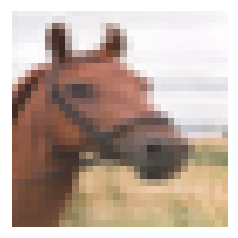

In [4]:
image = 99 # Image index in the test set
plot_image(x_test[image])

## Image Perturbation

To begin, we need a function to modify one or more pixels in an image. 

We can define the perturbation of a pixel as a 5-tuple 

$$\textbf{x} = (x, y, r, g, b)$$

where $x, y$ are the coordinates of the pixel from 0 to 31, and $r,g,b$ are the red, green, and blue values from 0 to 255. Then multiple perturbations can simply be a concatenation of these tuples:

$$\textbf{X} = (x_1, y_1, r_1, g_1, b_1, x_2, y_2, r_2, g_2, b_2, ...)$$

We could instead use an array of tuples, but the optimization algorithm we will use requires it to be a flat 1-d vector.

Then the function to perturb an image can take as an input the image and $\textbf{X}$, and output a copy of the image with each pixel at $x_i, y_i$ modified to have the color $r_i, g_i, b_i$.

In [ ]:
def perturb_image(x, img):
    # Copy the image to keep the original unchanged
    img = np.copy(img) 
    
    # Split into an array of 5-tuples (perturbation pixels)
    pixels = np.split(x.astype(int), len(x) // 5)
    
    # At each pixel's x,y position, assign its rgb value
    for pixel in pixels:
        x_pos, y_pos, *rgb = pixel
        img[x_pos, y_pos] = rgb
    return img

Now we can modify the pixels of any image we want.

Let's modify our horse image by making pixel (16,16) yellow.

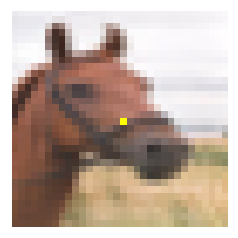

In [6]:
image = 99 # Image index in the test set
pixel = np.array([16, 16, 255, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, x_test[image])

plot_image(image_perturbed)

## Load Models

To demonstrate the attack, we need some neural network models trained on the Cifar10 dataset. We will load some pretrained models in the `networks/models` directory, which range from 74% to 94% classification accuracy. Note that there are more networks available in the `networks` directory, but must be trained before testing them here.

It is also recommended to use Keras with a GPU enabled. The code below can be used to check (if using Tensorflow).
```python
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
```

In [7]:
# Available pretrained models
lecun_net = LecunNet()
pure_cnn = PureCnn()
net_in_net = NetworkInNetwork()
resnet = ResNet()
densenet = DenseNet()
wide_resnet = WideResNet()

models = [lecun_net, pure_cnn, net_in_net, resnet]

# If your machine can handle it, uncomment for more pretrained models
# models = [lecun_net, pure_cnn, net_in_net, resnet, densenet, wide_resnet]

Successfully loaded lecun_net
Successfully loaded pure_cnn
Successfully loaded net_in_net
Successfully loaded resnet
Successfully loaded densenet
Successfully loaded wide_resnet


### Calculate Model Accuracies

After loading the models, we would like to evaluate all test images with each model to ensure that we only attack the images which have been classified correctly. The code below will also display the accuracy and number of parameters of each model.

In [8]:
network_stats, correct_imgs = evaluate_models(models, x_test, y_test)
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])

network_stats

Evaluating lecun_net
Evaluating pure_cnn
Evaluating net_in_net
Evaluating resnet


name  accuracy  param_count
0   lecun_net    0.7488        62006
1    pure_cnn    0.8877      1369738
2  net_in_net    0.9074       972658
3      resnet    0.9231       470218

### Prediction Function

Define a function that runs a perturbed image on a given model and returns the model's confidence (probability output) in a target class. If the target class is the correct class, this will be the function that we want to minimize so that the model will be most confident in another class (which is incorrect). Otherwise, the target is an incorrect class and we will want to maximize it.

In [9]:
def predict_class(x, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    img_perturbed = perturb_image(x, img)
    prediction = model.predict_one(img_perturbed)[target_class]
    
    # This function should always be minimized, so return its complement if needed
    return prediction if minimize else 1 - prediction

Below we can modify a pixel in an image and see how the confidence of the model changes.

In [ ]:
image = 102
pixel = np.array([16, 16, 255, 255, 0])

true_class = y_test[image,0]
model = resnet
confidence = predict_class(pixel, x_test[image], true_class, model)

print('Confidence in true class', class_names[true_class], 'is', confidence)
plot_image(perturb_image(pixel, x_test[image]))

## The Attack

Here we will demonstrate two variants of the one pixel attack: untargeted and targeted.

### Targeted vs. Untargeted Attacks

The objective of an untargeted attack is to cause a model to misclassify an image. This means we want to perterb an image as to minimize the confidence probability of the correct classification category and maximize the sum of the probabilities of all other categories.

The objective of a targeted attack is to cause a model to classify an image as a given  target class. We want to perturb an image as to maximize the probability of a class of our own choosing.

### Success Criterion

The success criterion function below will output `True` whenever a perturbation is sufficient to fool a model.

In [11]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = perturb_image(x, x_test[img])
    confidence = model.predict_one(attack_image)
    predicted_class = np.argmax(confidence)
    
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True
    if (verbose):
        print('Confidence:', confidence[target_class])
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True

Here we demonstrate the usage of the success criterion function.

Confidence: 0.9999976
Attack success: False


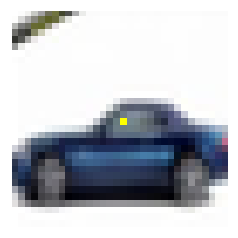

In [12]:
image = 105
pixel = np.array([16, 16, 255, 255, 0])
model = resnet
success = attack_success(pixel, image, y_test[image,0], model, verbose=True)

print('Attack success:', success == True)
plot_image(perturb_image(pixel, x_test[image]))

### Attack Function

In [13]:
def attack(img, model, target=None, pixel_count=1, 
           maxiter=30, popsize=30, verbose=False):
    
    targeted_attack = target is not None
    target_class = target if targeted_attack else y_test[img][0]
    
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    
    # Format the predict/callback functions for the differential evolution algorithm
    predict_fn = lambda x: predict_class(
        x, x_test[img], target_class, model, target is None)
    callback_fn = lambda x, convergence: attack_success(
        x, img, target_class, model, targeted_attack, verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=(popsize // pixel_count),
        recombination=1, atol=-1, callback=callback_fn)

    attack_image = perturb_image(attack_result.x, x_test[img])
    prior_probs = model.predict_one(x_test[img])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img][0]
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    plot_image(attack_image, actual_class, class_names, predicted_class)

    return [model.name, pixel_count, img, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_image]

#### Untargeted Attack

Let's look at one iteration of the untargeted attack.

Confidence: 0.9731295
Confidence: 0.7859155
Confidence: 0.7859155
Confidence: 0.7859155
Confidence: 0.62636065
Confidence: 0.4261915


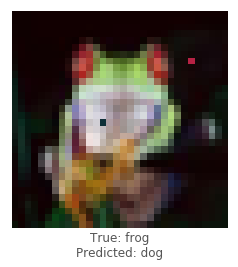

In [14]:
image = 102
pixels = 2
model = resnet
_ = attack(image, model, pixel_count=pixels, verbose=True)

#### Targeted Attack

Attacking with target automobile
Confidence: 0.02378367
Confidence: 0.02378367
Confidence: 0.02378367
Confidence: 0.026306313
Confidence: 0.026306313
Confidence: 0.0513022
Confidence: 0.0513022
Confidence: 0.06527986
Confidence: 0.06527986
Confidence: 0.07052445
Confidence: 0.07052445
Confidence: 0.07886145
Confidence: 0.15710153
Confidence: 0.15710153
Confidence: 0.15710153
Confidence: 0.15710153
Confidence: 0.15710153
Confidence: 0.15710153
Confidence: 0.15710153
Confidence: 0.15710153
Confidence: 0.15710153
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.40506834
Confidence: 0.4104339
Confidence: 0.5042228


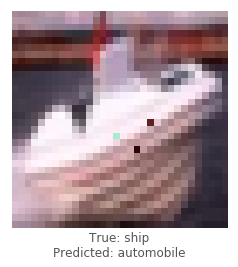

In [15]:
image = 108
target_class = 1 # Integer in range 0-9
pixels = 3
model = lecun_net
print('Attacking with target', class_names[target_class])
_ = attack(image, model, target_class, pixel_count=pixels, popsize=50, maxiter=40, verbose=True)

### Collect Results

In [16]:
def attack_all(models, samples=100, pixels=(1,2,3), targeted=False, verbose=False):
    results = []
    for model in models:
        valid_imgs = correct_imgs[correct_imgs.name == model.name].img
        img_samples = np.random.choice(valid_imgs, samples)
        for pixel_count in pixels:
            for i,img in enumerate(img_samples):
                print(model.name, '- image', img, '-', i+1, '/', len(img_samples))
                targets = [None] if not targeted else range(10)
                
                for target in targets:
                    if (targeted):
                        print('Attacking with target', class_names[target])
                        if (target == y_test[img][0]):
                            continue
                    result = attack(img, model, target, pixel_count, verbose=verbose)
                    results.append(result)
    return results

lecun_net - image 3223 - 1 / 100


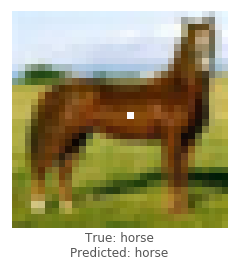

lecun_net - image 601 - 2 / 100


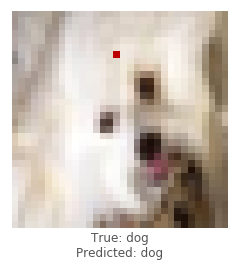

lecun_net - image 4867 - 3 / 100


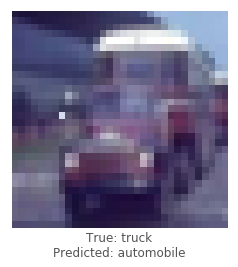

lecun_net - image 8821 - 4 / 100


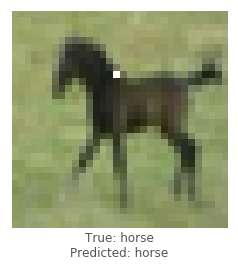

lecun_net - image 5032 - 5 / 100


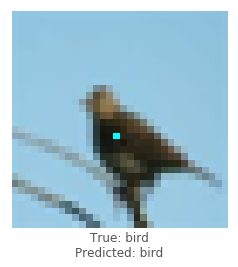

lecun_net - image 4115 - 6 / 100


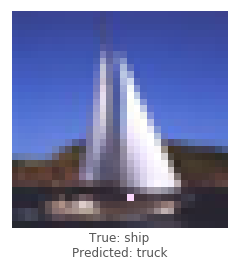

lecun_net - image 2564 - 7 / 100


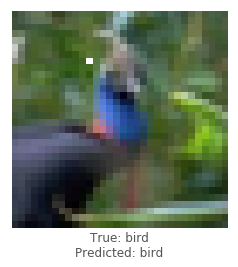

lecun_net - image 4256 - 8 / 100


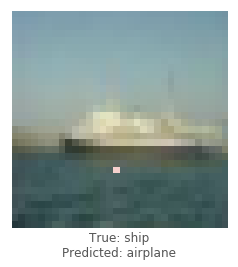

lecun_net - image 4066 - 9 / 100


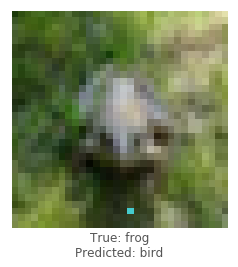

lecun_net - image 8961 - 10 / 100


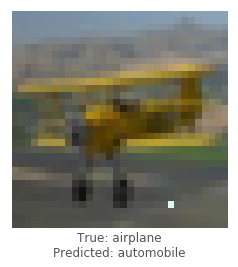

lecun_net - image 3581 - 11 / 100


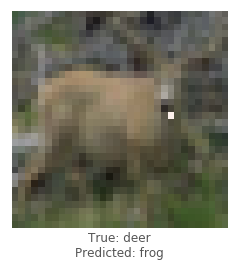

lecun_net - image 4617 - 12 / 100


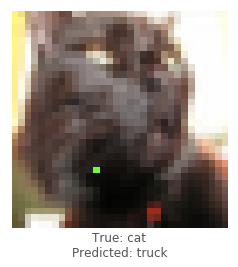

lecun_net - image 4533 - 13 / 100


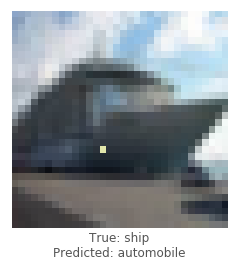

lecun_net - image 230 - 14 / 100


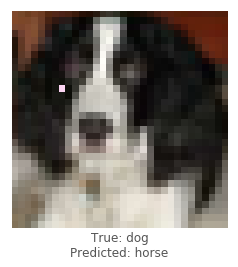

lecun_net - image 7063 - 15 / 100


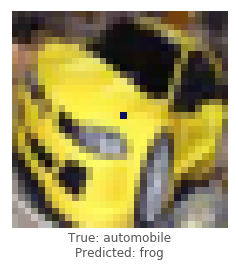

lecun_net - image 7321 - 16 / 100


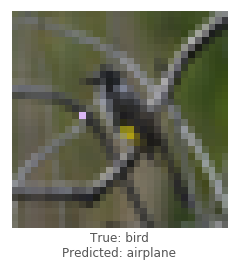

lecun_net - image 9115 - 17 / 100


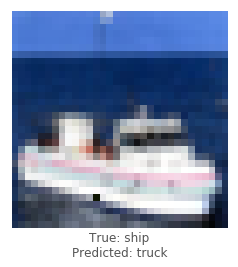

lecun_net - image 4878 - 18 / 100


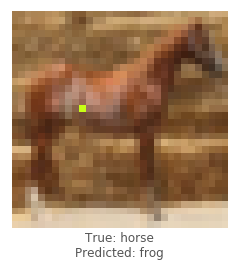

lecun_net - image 5237 - 19 / 100


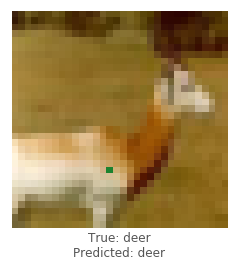

lecun_net - image 8849 - 20 / 100


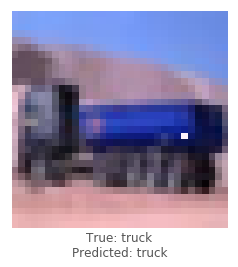

lecun_net - image 5679 - 21 / 100


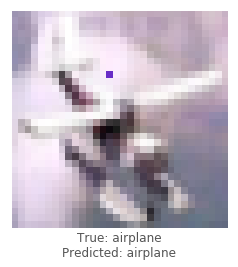

lecun_net - image 8424 - 22 / 100


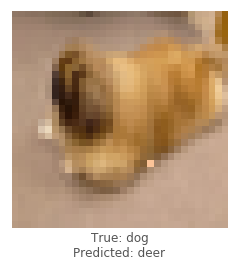

lecun_net - image 4991 - 23 / 100


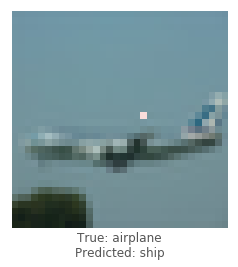

lecun_net - image 2138 - 24 / 100


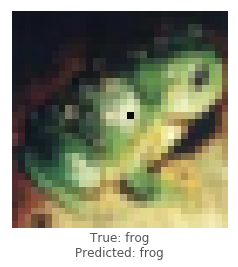

lecun_net - image 6801 - 25 / 100


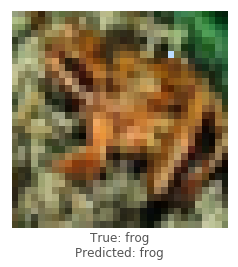

lecun_net - image 3109 - 26 / 100


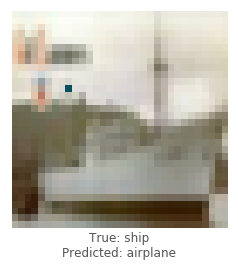

lecun_net - image 9057 - 27 / 100


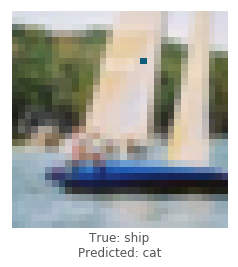

lecun_net - image 2921 - 28 / 100


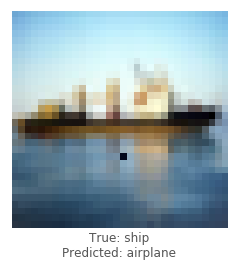

lecun_net - image 1563 - 29 / 100


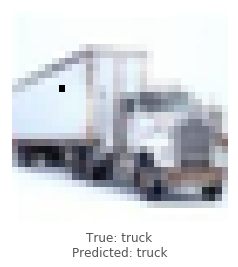

lecun_net - image 4017 - 30 / 100


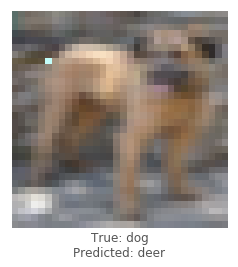

lecun_net - image 4383 - 31 / 100


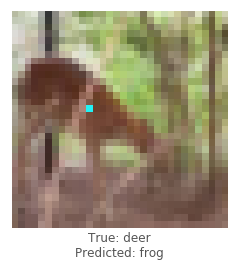

lecun_net - image 6230 - 32 / 100


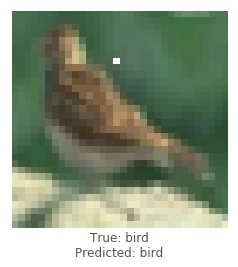

lecun_net - image 4761 - 33 / 100


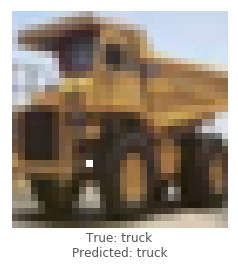

lecun_net - image 2824 - 34 / 100


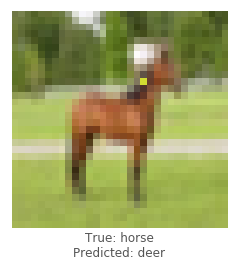

lecun_net - image 5865 - 35 / 100


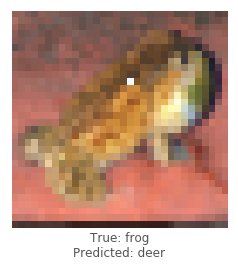

lecun_net - image 7487 - 36 / 100


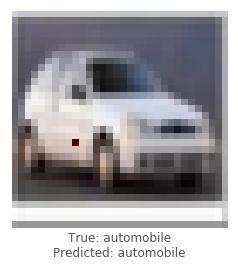

lecun_net - image 2970 - 37 / 100


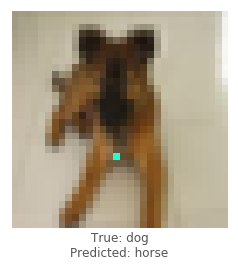

lecun_net - image 1811 - 38 / 100


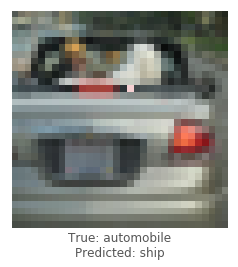

lecun_net - image 7115 - 39 / 100


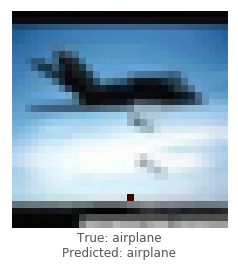

lecun_net - image 7570 - 40 / 100


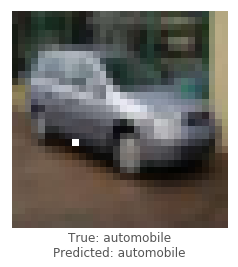

lecun_net - image 103 - 41 / 100


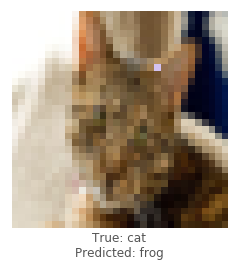

lecun_net - image 1473 - 42 / 100


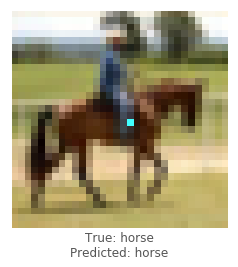

lecun_net - image 8299 - 43 / 100


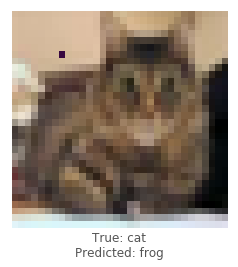

lecun_net - image 163 - 44 / 100


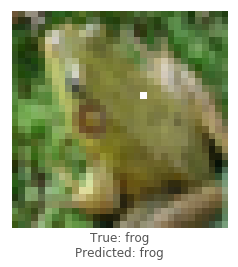

lecun_net - image 8678 - 45 / 100


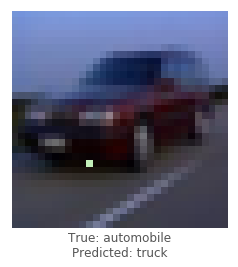

lecun_net - image 5671 - 46 / 100


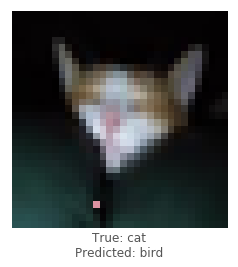

lecun_net - image 5725 - 47 / 100


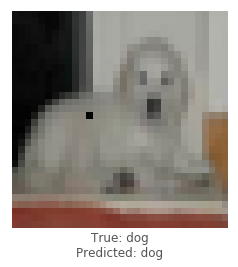

lecun_net - image 1742 - 48 / 100


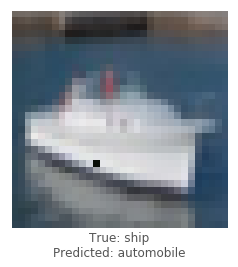

lecun_net - image 7320 - 49 / 100


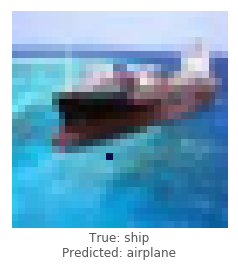

lecun_net - image 1703 - 50 / 100


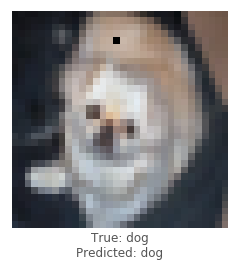

lecun_net - image 5064 - 51 / 100


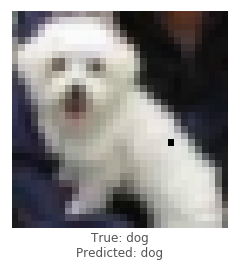

lecun_net - image 4834 - 52 / 100


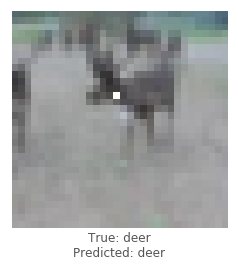

lecun_net - image 6676 - 53 / 100


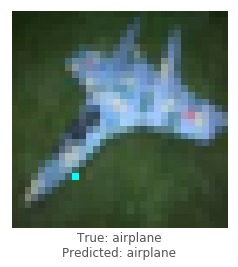

lecun_net - image 7690 - 54 / 100


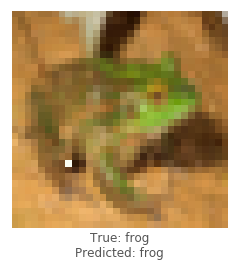

lecun_net - image 4868 - 55 / 100


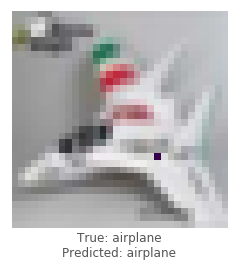

lecun_net - image 6592 - 56 / 100


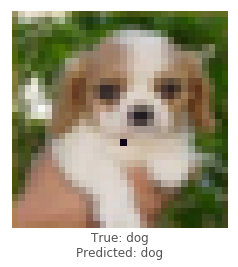

lecun_net - image 2778 - 57 / 100


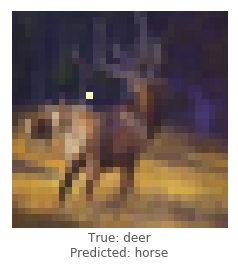

lecun_net - image 9387 - 58 / 100


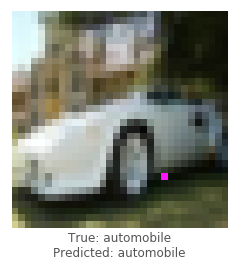

lecun_net - image 4025 - 59 / 100


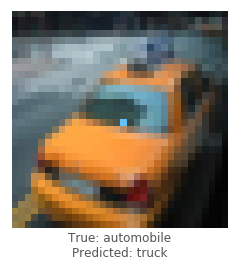

lecun_net - image 6479 - 60 / 100


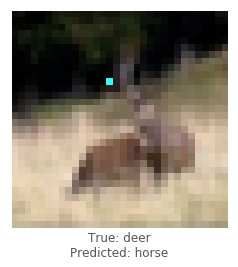

lecun_net - image 5293 - 61 / 100


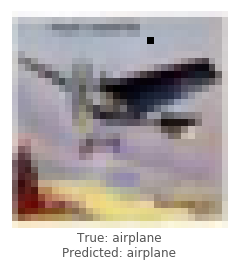

lecun_net - image 2682 - 62 / 100


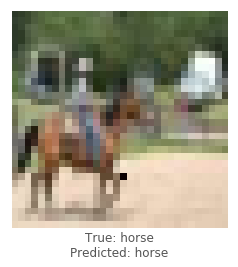

lecun_net - image 5513 - 63 / 100


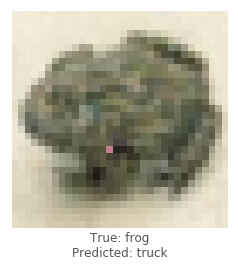

lecun_net - image 9790 - 64 / 100


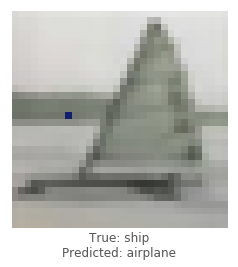

lecun_net - image 9768 - 65 / 100


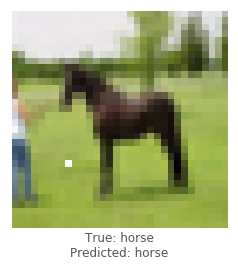

lecun_net - image 6867 - 66 / 100


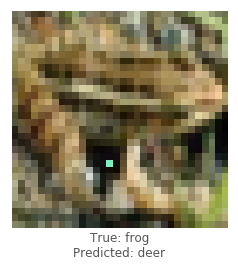

lecun_net - image 3252 - 67 / 100


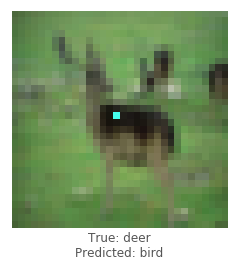

lecun_net - image 9783 - 68 / 100


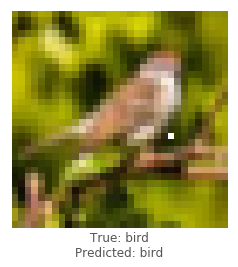

lecun_net - image 5657 - 69 / 100


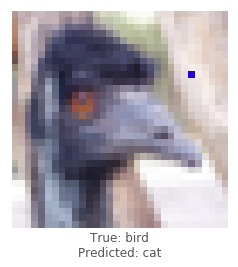

lecun_net - image 2879 - 70 / 100


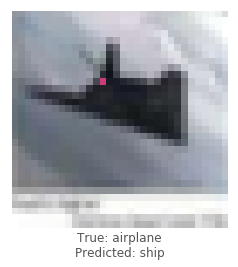

lecun_net - image 7943 - 71 / 100


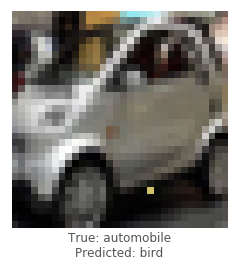

lecun_net - image 7155 - 72 / 100


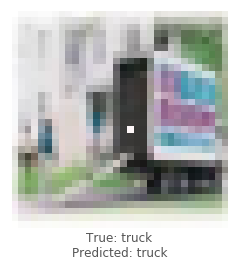

lecun_net - image 2438 - 73 / 100


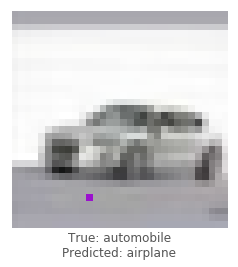

lecun_net - image 9614 - 74 / 100


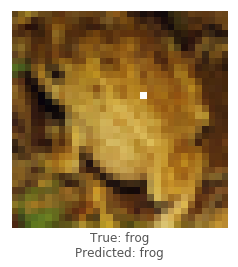

lecun_net - image 5026 - 75 / 100


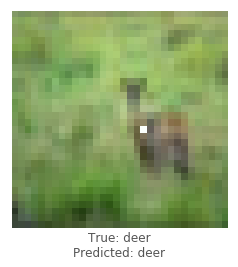

lecun_net - image 9153 - 76 / 100


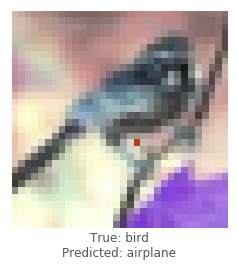

lecun_net - image 1809 - 77 / 100


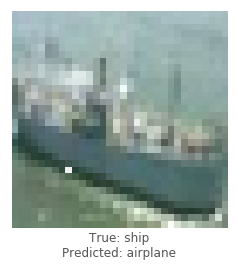

lecun_net - image 7601 - 78 / 100


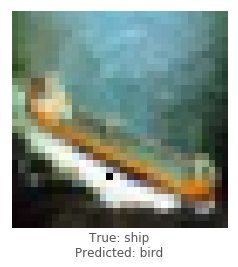

lecun_net - image 2338 - 79 / 100


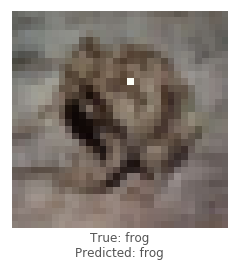

lecun_net - image 2289 - 80 / 100


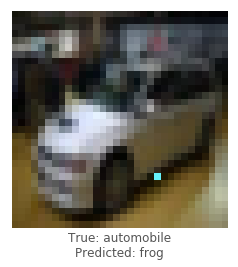

lecun_net - image 9988 - 81 / 100


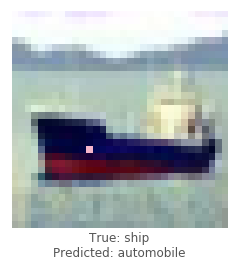

lecun_net - image 608 - 82 / 100


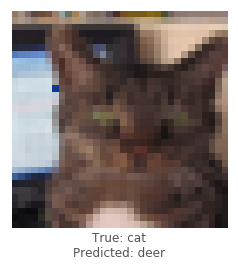

lecun_net - image 4958 - 83 / 100


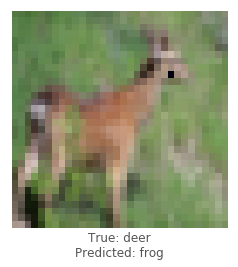

lecun_net - image 4332 - 84 / 100


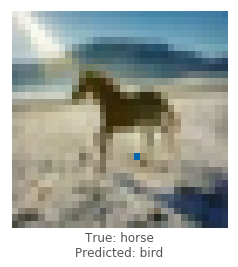

lecun_net - image 2443 - 85 / 100


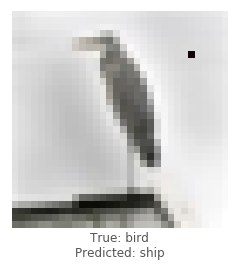

lecun_net - image 6045 - 86 / 100


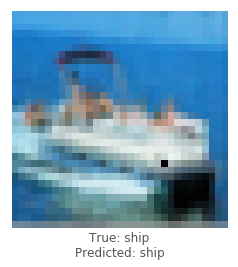

lecun_net - image 9210 - 87 / 100


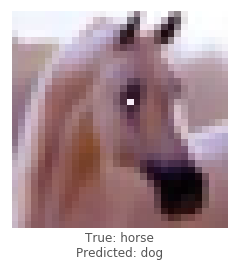

lecun_net - image 3024 - 88 / 100


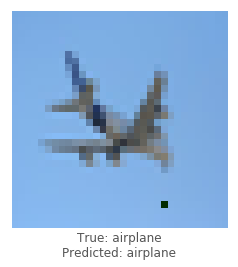

lecun_net - image 6755 - 89 / 100


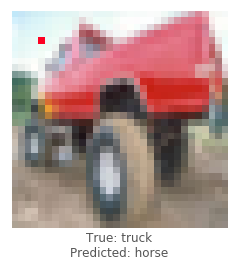

lecun_net - image 2112 - 90 / 100


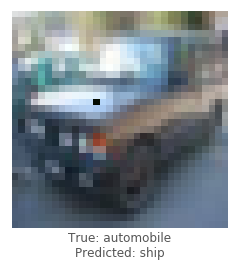

lecun_net - image 9978 - 91 / 100


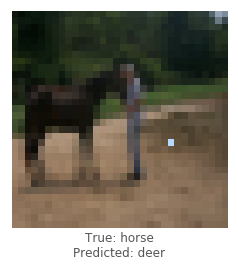

lecun_net - image 7917 - 92 / 100


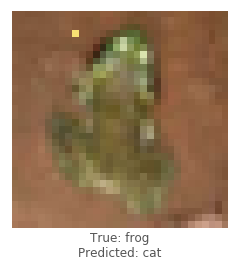

lecun_net - image 5459 - 93 / 100


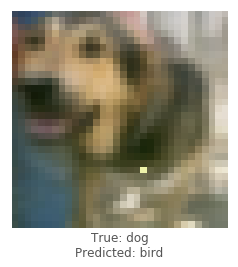

lecun_net - image 7460 - 94 / 100


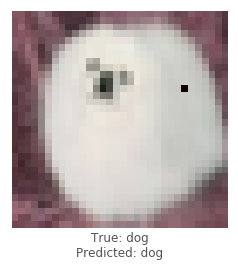

lecun_net - image 4822 - 95 / 100


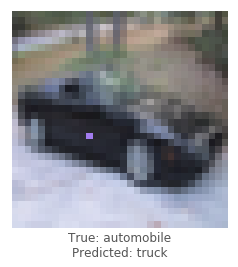

lecun_net - image 4406 - 96 / 100


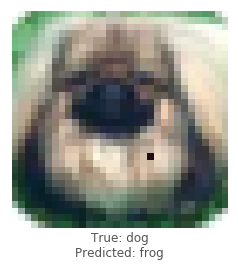

lecun_net - image 5476 - 97 / 100


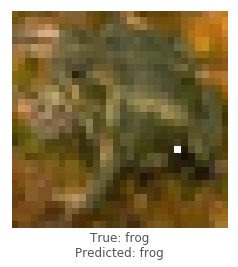

lecun_net - image 5757 - 98 / 100


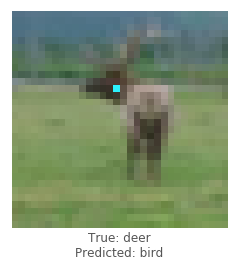

lecun_net - image 2391 - 99 / 100


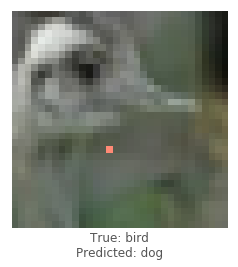

lecun_net - image 5626 - 100 / 100


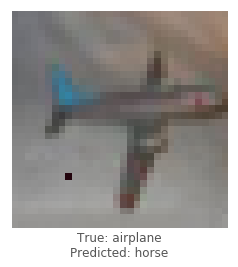

lecun_net - image 3223 - 1 / 100


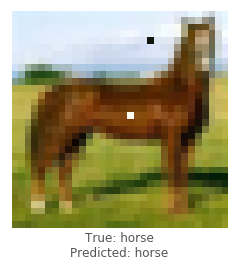

lecun_net - image 601 - 2 / 100


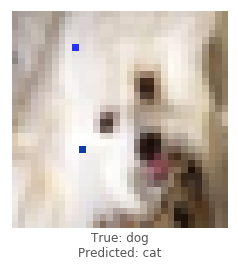

lecun_net - image 4867 - 3 / 100


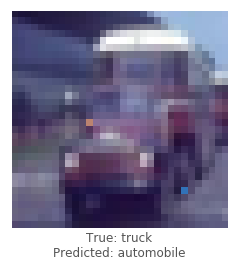

lecun_net - image 8821 - 4 / 100


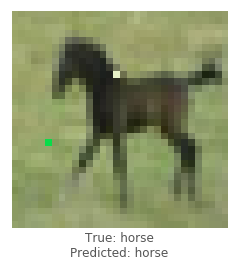

lecun_net - image 5032 - 5 / 100


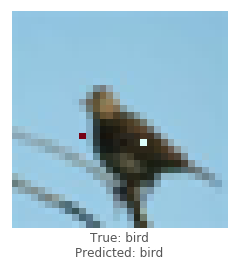

lecun_net - image 4115 - 6 / 100


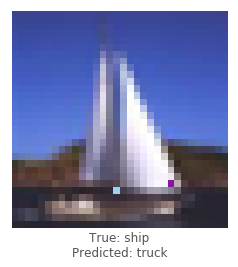

lecun_net - image 2564 - 7 / 100


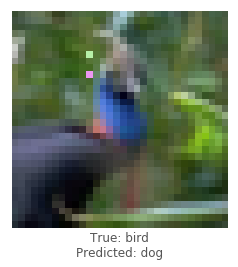

lecun_net - image 4256 - 8 / 100


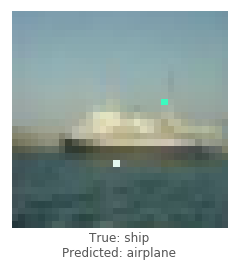

lecun_net - image 4066 - 9 / 100


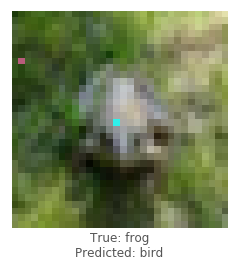

lecun_net - image 8961 - 10 / 100


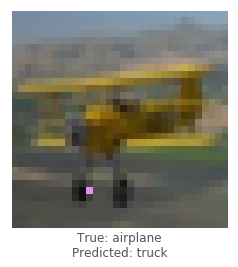

lecun_net - image 3581 - 11 / 100


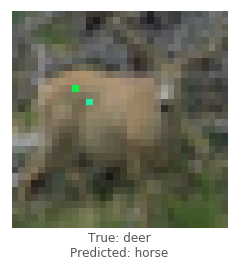

lecun_net - image 4617 - 12 / 100


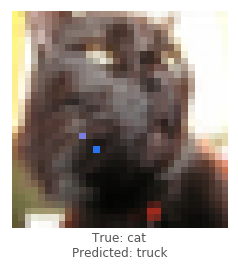

lecun_net - image 4533 - 13 / 100


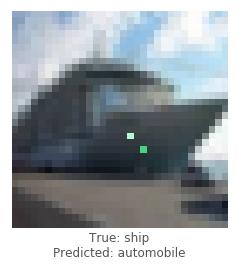

lecun_net - image 230 - 14 / 100


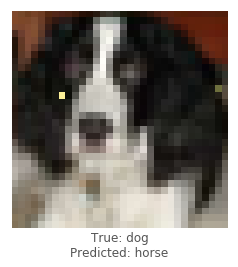

lecun_net - image 7063 - 15 / 100


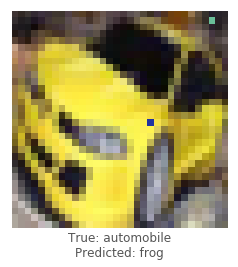

lecun_net - image 7321 - 16 / 100


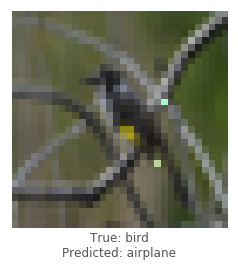

lecun_net - image 9115 - 17 / 100


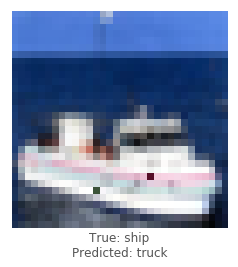

lecun_net - image 4878 - 18 / 100


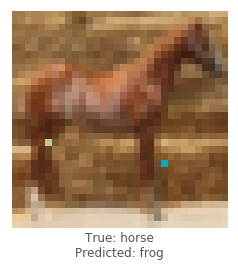

lecun_net - image 5237 - 19 / 100


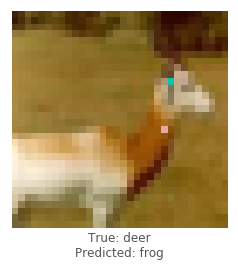

lecun_net - image 8849 - 20 / 100


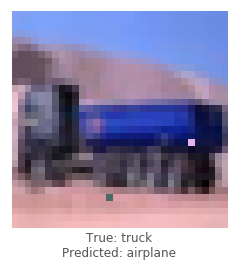

lecun_net - image 5679 - 21 / 100


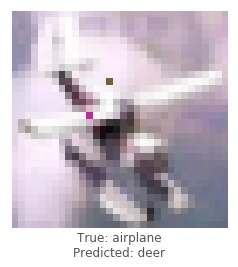

lecun_net - image 8424 - 22 / 100


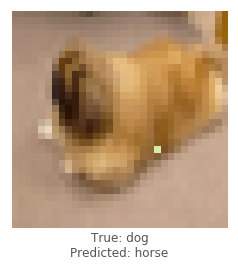

lecun_net - image 4991 - 23 / 100


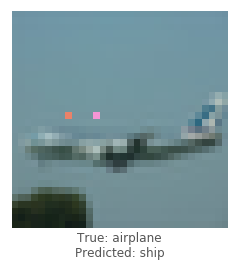

lecun_net - image 2138 - 24 / 100


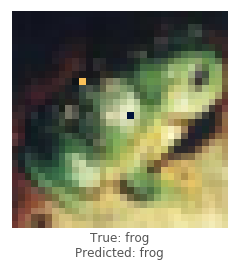

lecun_net - image 6801 - 25 / 100


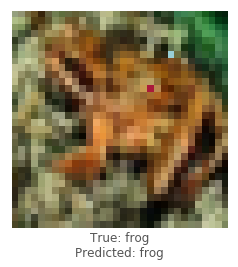

lecun_net - image 3109 - 26 / 100


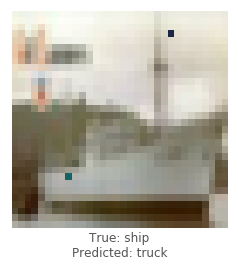

lecun_net - image 9057 - 27 / 100


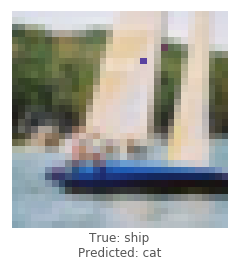

lecun_net - image 2921 - 28 / 100


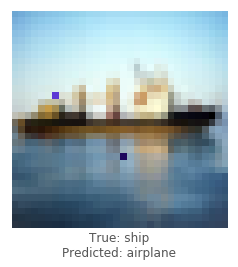

lecun_net - image 1563 - 29 / 100


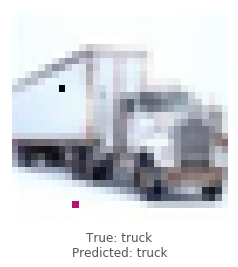

lecun_net - image 4017 - 30 / 100


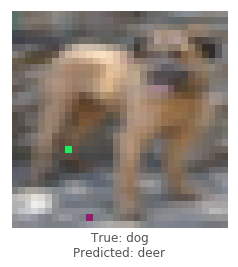

lecun_net - image 4383 - 31 / 100


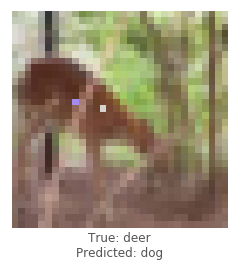

lecun_net - image 6230 - 32 / 100


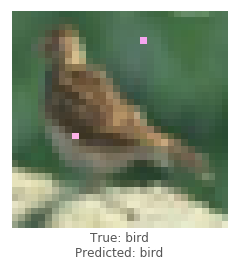

lecun_net - image 4761 - 33 / 100


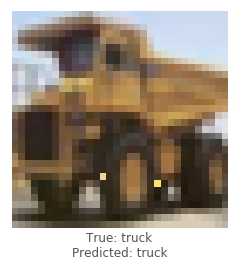

lecun_net - image 2824 - 34 / 100


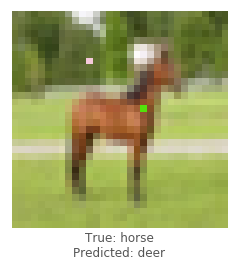

lecun_net - image 5865 - 35 / 100


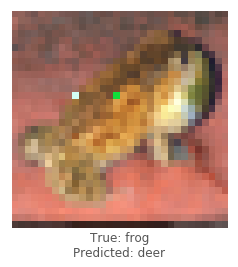

lecun_net - image 7487 - 36 / 100


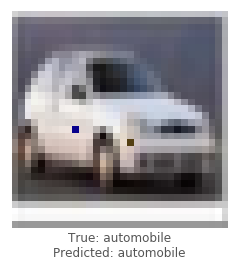

lecun_net - image 2970 - 37 / 100


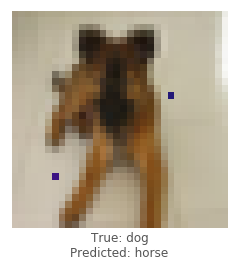

lecun_net - image 1811 - 38 / 100


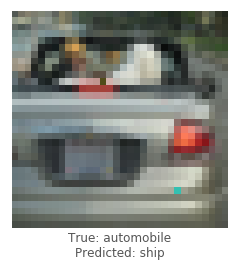

lecun_net - image 7115 - 39 / 100


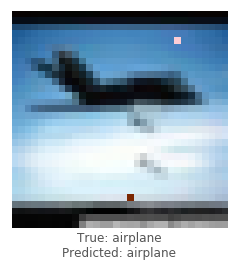

lecun_net - image 7570 - 40 / 100


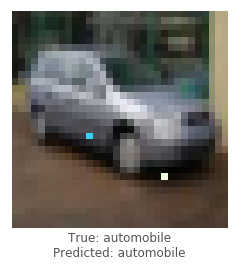

lecun_net - image 103 - 41 / 100


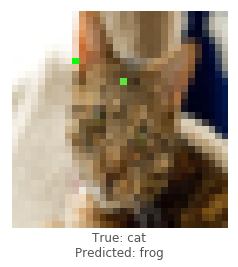

lecun_net - image 1473 - 42 / 100


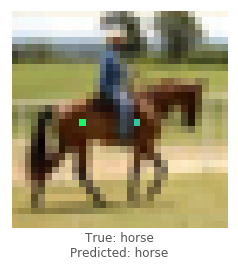

lecun_net - image 8299 - 43 / 100


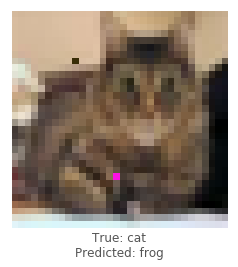

lecun_net - image 163 - 44 / 100


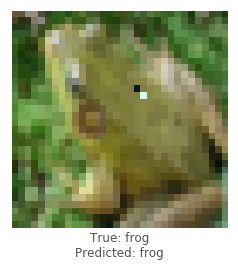

lecun_net - image 8678 - 45 / 100


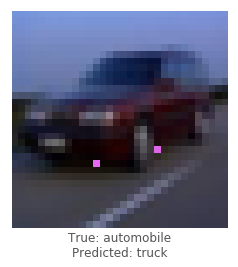

lecun_net - image 5671 - 46 / 100


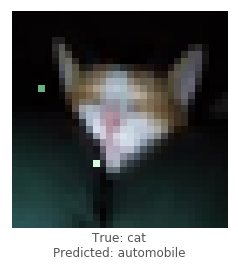

lecun_net - image 5725 - 47 / 100


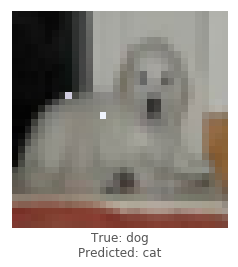

lecun_net - image 1742 - 48 / 100


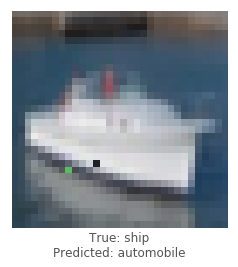

lecun_net - image 7320 - 49 / 100


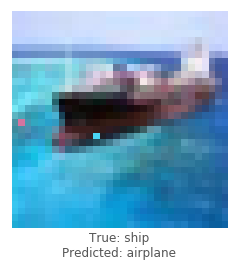

lecun_net - image 1703 - 50 / 100


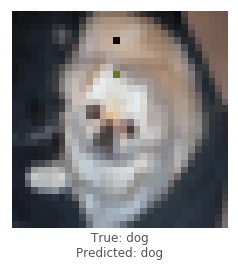

lecun_net - image 5064 - 51 / 100


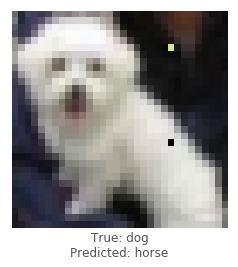

lecun_net - image 4834 - 52 / 100


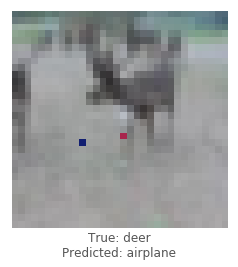

lecun_net - image 6676 - 53 / 100


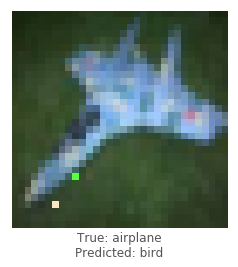

lecun_net - image 7690 - 54 / 100


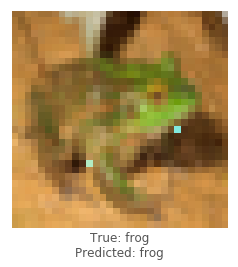

lecun_net - image 4868 - 55 / 100


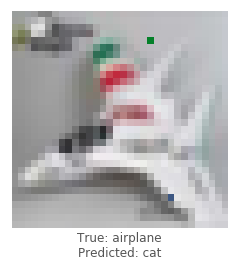

lecun_net - image 6592 - 56 / 100


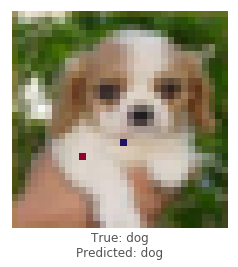

lecun_net - image 2778 - 57 / 100


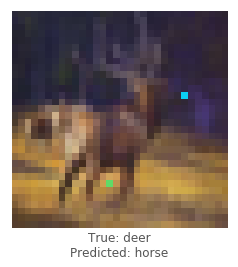

lecun_net - image 9387 - 58 / 100


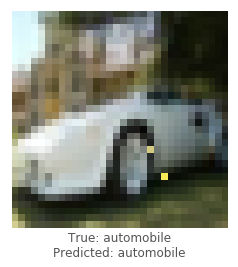

lecun_net - image 4025 - 59 / 100


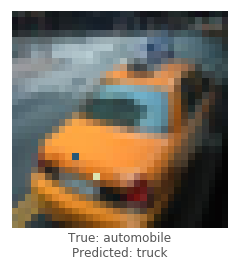

lecun_net - image 6479 - 60 / 100


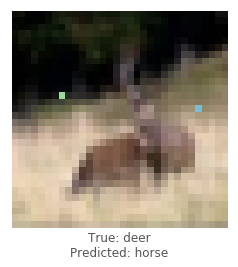

lecun_net - image 5293 - 61 / 100


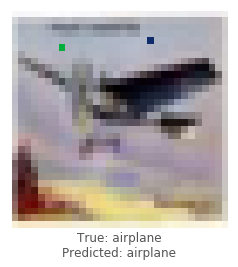

lecun_net - image 2682 - 62 / 100


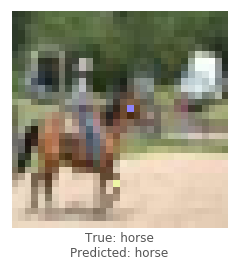

lecun_net - image 5513 - 63 / 100


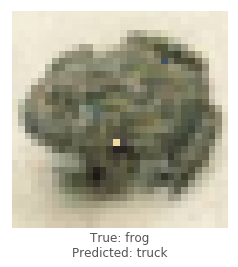

lecun_net - image 9790 - 64 / 100


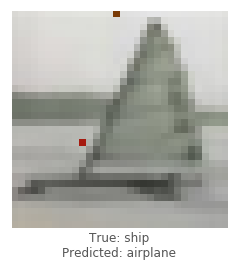

lecun_net - image 9768 - 65 / 100


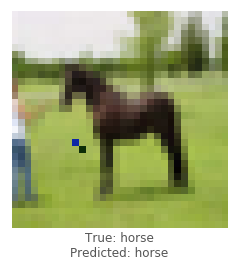

lecun_net - image 6867 - 66 / 100


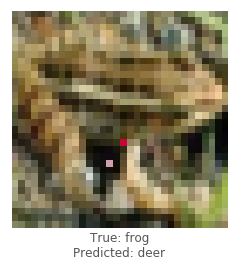

lecun_net - image 3252 - 67 / 100


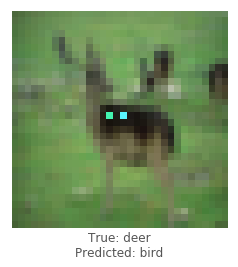

lecun_net - image 9783 - 68 / 100


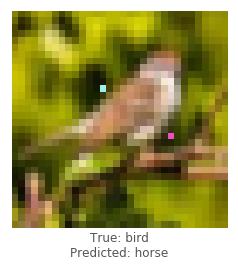

lecun_net - image 5657 - 69 / 100


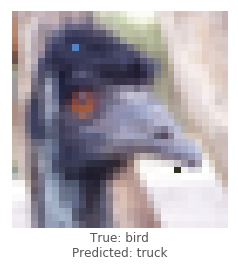

lecun_net - image 2879 - 70 / 100


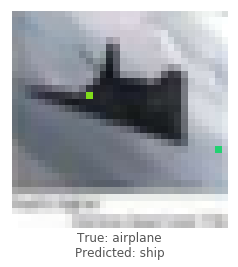

lecun_net - image 7943 - 71 / 100


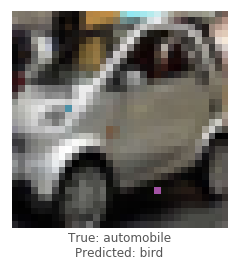

lecun_net - image 7155 - 72 / 100


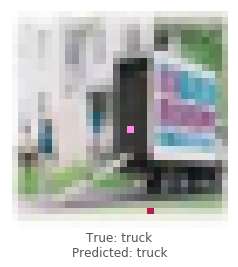

lecun_net - image 2438 - 73 / 100


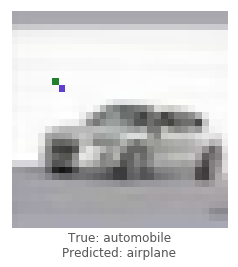

lecun_net - image 9614 - 74 / 100


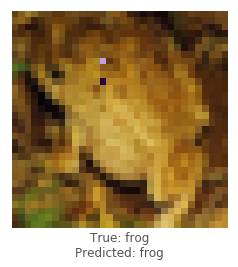

lecun_net - image 5026 - 75 / 100


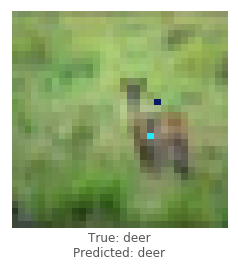

lecun_net - image 9153 - 76 / 100


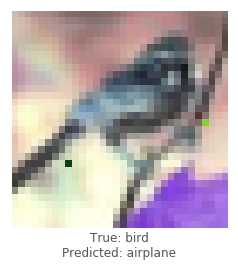

lecun_net - image 1809 - 77 / 100


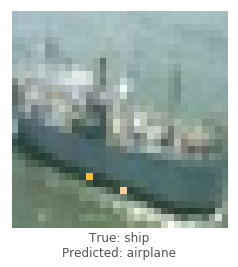

lecun_net - image 7601 - 78 / 100


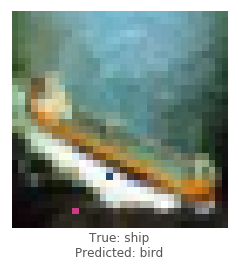

lecun_net - image 2338 - 79 / 100


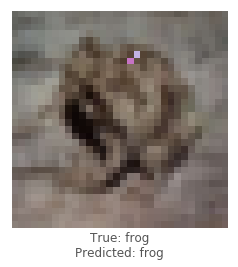

lecun_net - image 2289 - 80 / 100


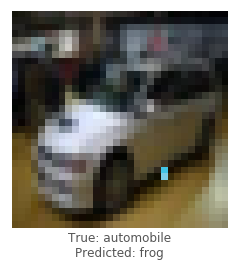

lecun_net - image 9988 - 81 / 100


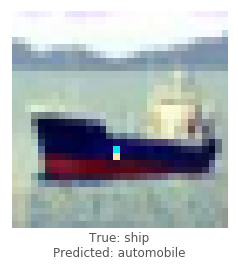

lecun_net - image 608 - 82 / 100


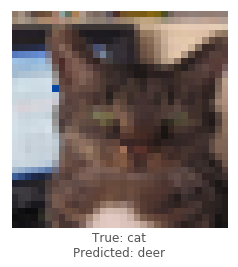

lecun_net - image 4958 - 83 / 100


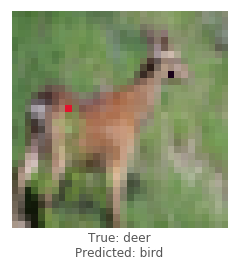

lecun_net - image 4332 - 84 / 100


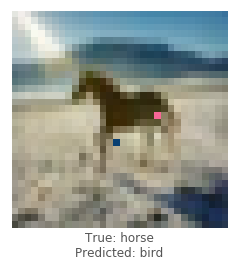

lecun_net - image 2443 - 85 / 100


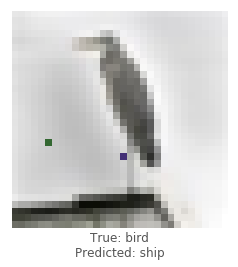

lecun_net - image 6045 - 86 / 100


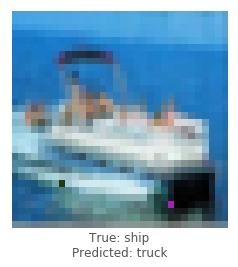

lecun_net - image 9210 - 87 / 100


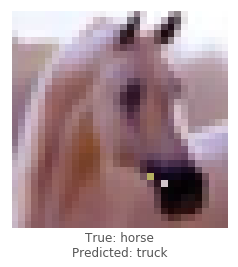

lecun_net - image 3024 - 88 / 100


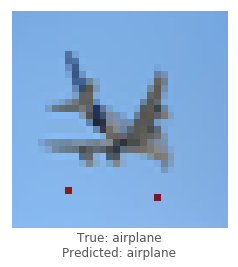

lecun_net - image 6755 - 89 / 100


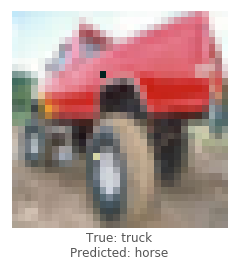

lecun_net - image 2112 - 90 / 100


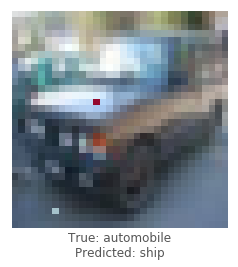

lecun_net - image 9978 - 91 / 100


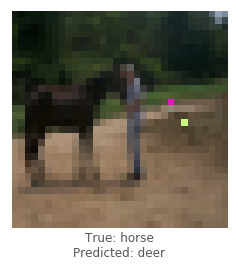

lecun_net - image 7917 - 92 / 100


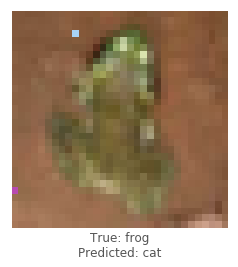

lecun_net - image 5459 - 93 / 100


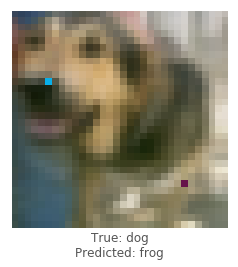

lecun_net - image 7460 - 94 / 100


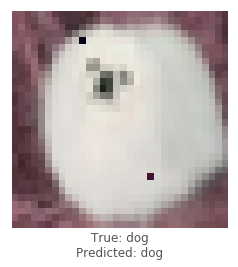

lecun_net - image 4822 - 95 / 100


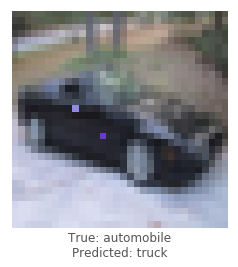

lecun_net - image 4406 - 96 / 100


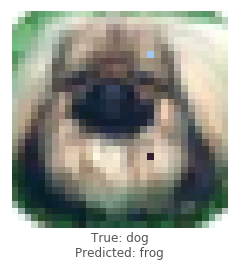

lecun_net - image 5476 - 97 / 100


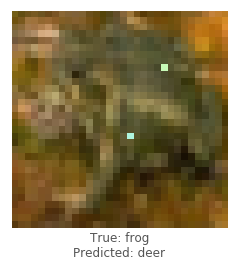

lecun_net - image 5757 - 98 / 100


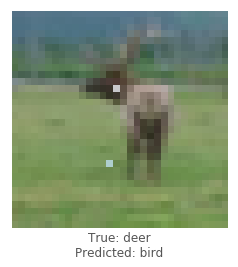

lecun_net - image 2391 - 99 / 100


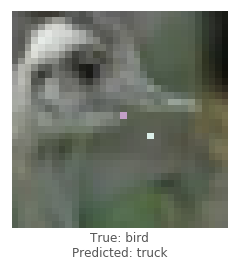

lecun_net - image 5626 - 100 / 100


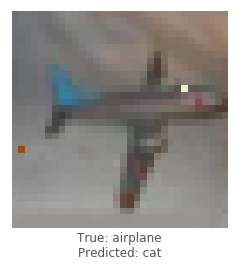

lecun_net - image 3223 - 1 / 100


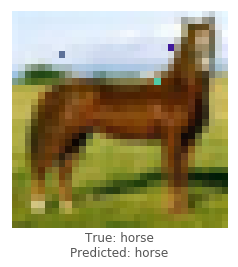

lecun_net - image 601 - 2 / 100


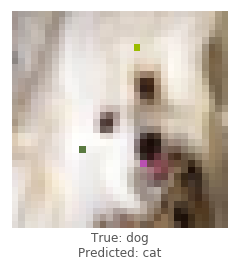

lecun_net - image 4867 - 3 / 100


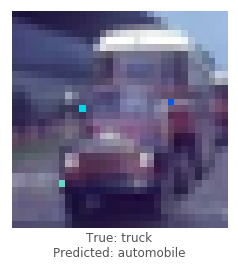

lecun_net - image 8821 - 4 / 100


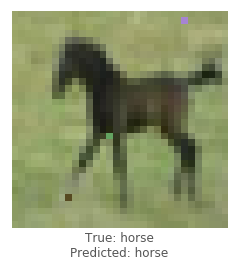

lecun_net - image 5032 - 5 / 100


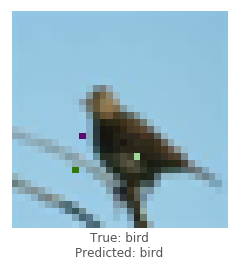

lecun_net - image 4115 - 6 / 100


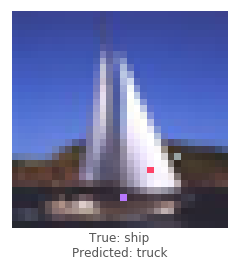

lecun_net - image 2564 - 7 / 100


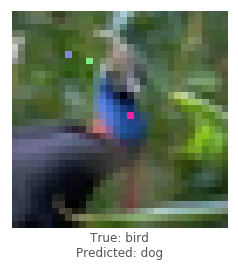

lecun_net - image 4256 - 8 / 100


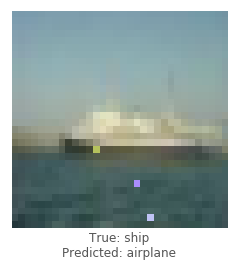

lecun_net - image 4066 - 9 / 100


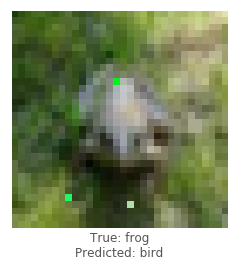

lecun_net - image 8961 - 10 / 100


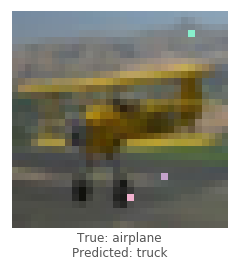

lecun_net - image 3581 - 11 / 100


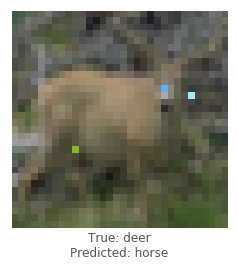

lecun_net - image 4617 - 12 / 100


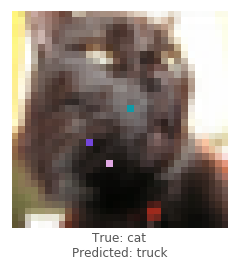

lecun_net - image 4533 - 13 / 100


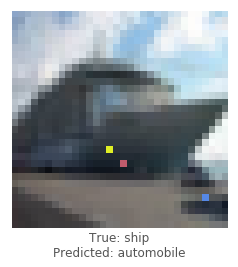

lecun_net - image 230 - 14 / 100


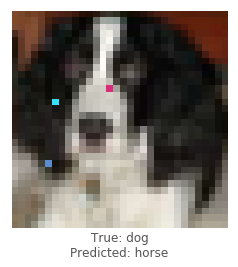

lecun_net - image 7063 - 15 / 100


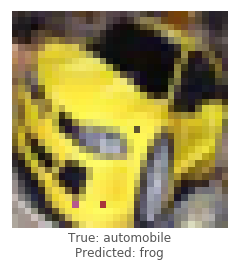

lecun_net - image 7321 - 16 / 100


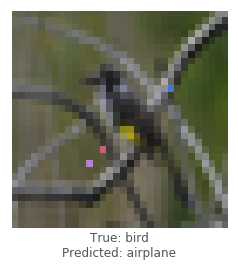

lecun_net - image 9115 - 17 / 100


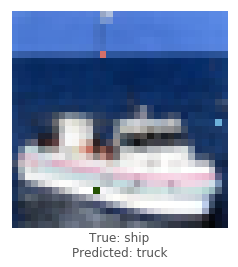

lecun_net - image 4878 - 18 / 100


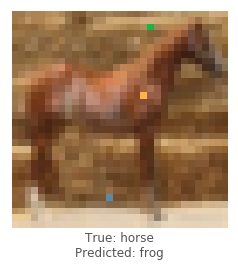

lecun_net - image 5237 - 19 / 100


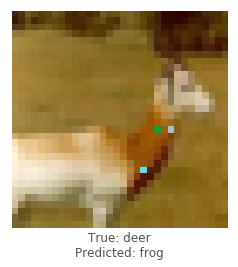

lecun_net - image 8849 - 20 / 100


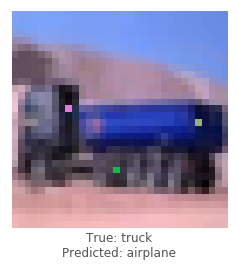

lecun_net - image 5679 - 21 / 100


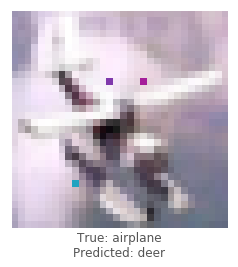

lecun_net - image 8424 - 22 / 100


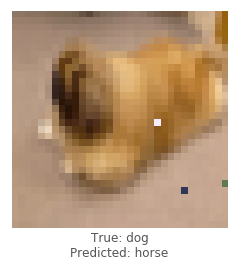

lecun_net - image 4991 - 23 / 100


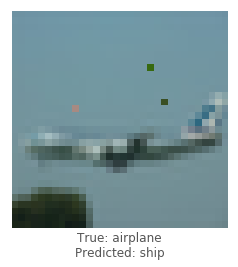

lecun_net - image 2138 - 24 / 100


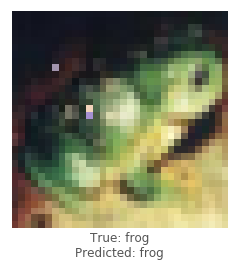

lecun_net - image 6801 - 25 / 100


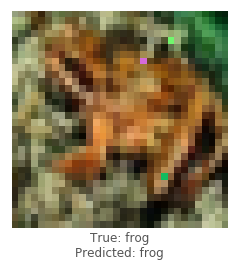

lecun_net - image 3109 - 26 / 100


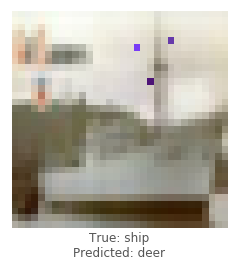

lecun_net - image 9057 - 27 / 100


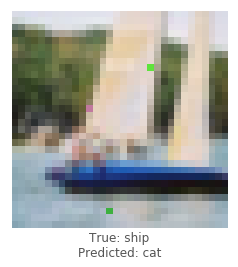

lecun_net - image 2921 - 28 / 100


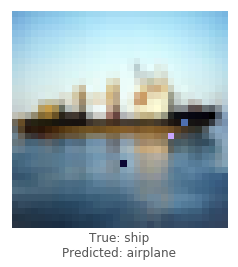

lecun_net - image 1563 - 29 / 100


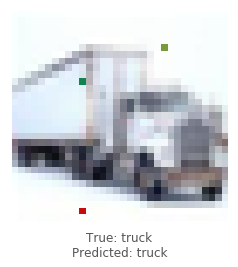

lecun_net - image 4017 - 30 / 100


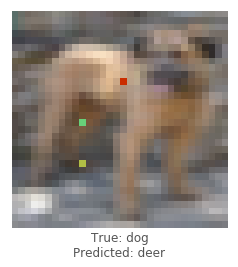

lecun_net - image 4383 - 31 / 100


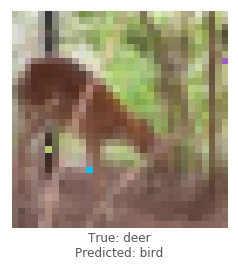

lecun_net - image 6230 - 32 / 100


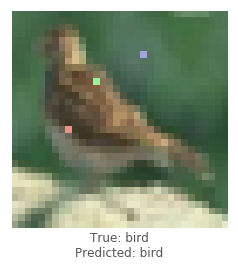

lecun_net - image 4761 - 33 / 100


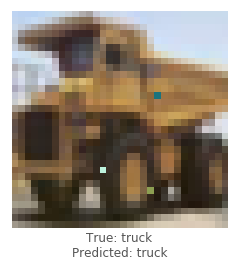

lecun_net - image 2824 - 34 / 100


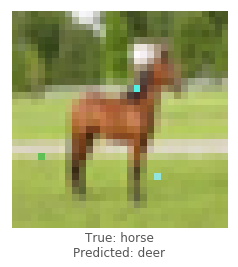

lecun_net - image 5865 - 35 / 100


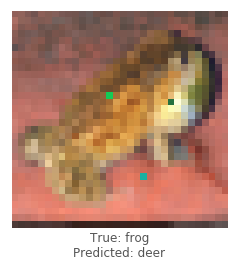

lecun_net - image 7487 - 36 / 100


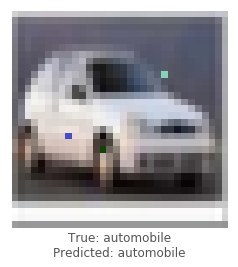

lecun_net - image 2970 - 37 / 100


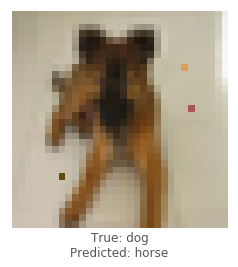

lecun_net - image 1811 - 38 / 100


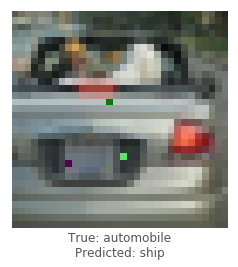

lecun_net - image 7115 - 39 / 100


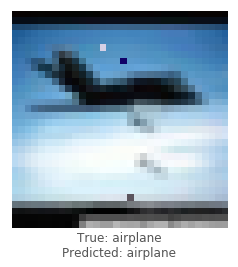

lecun_net - image 7570 - 40 / 100


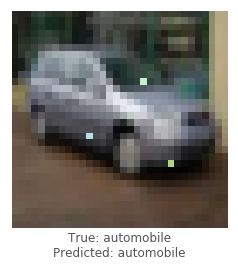

lecun_net - image 103 - 41 / 100


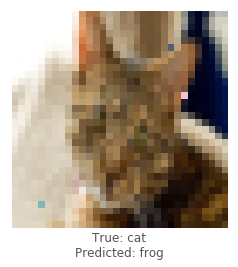

lecun_net - image 1473 - 42 / 100


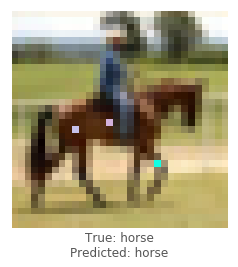

lecun_net - image 8299 - 43 / 100


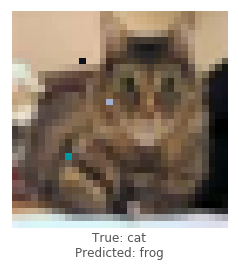

lecun_net - image 163 - 44 / 100


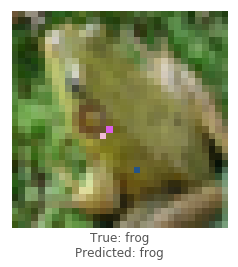

lecun_net - image 8678 - 45 / 100


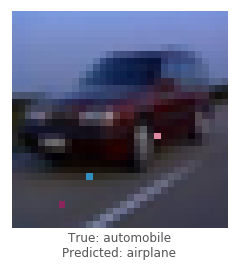

lecun_net - image 5671 - 46 / 100


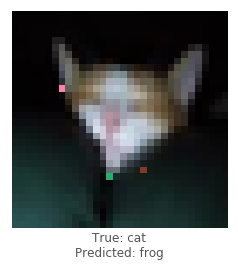

lecun_net - image 5725 - 47 / 100


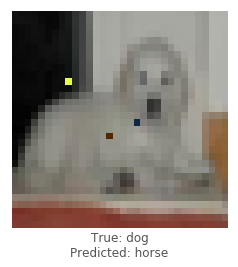

lecun_net - image 1742 - 48 / 100


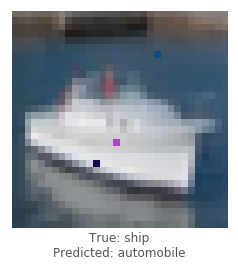

lecun_net - image 7320 - 49 / 100


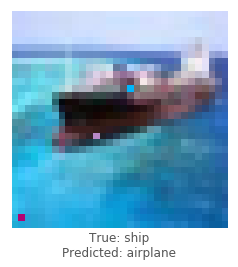

lecun_net - image 1703 - 50 / 100


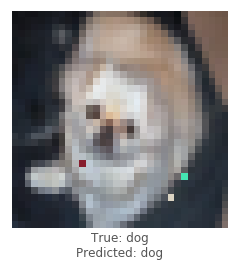

lecun_net - image 5064 - 51 / 100


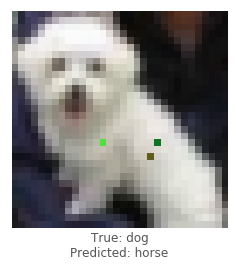

lecun_net - image 4834 - 52 / 100


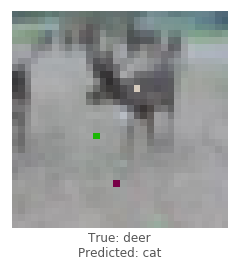

lecun_net - image 6676 - 53 / 100


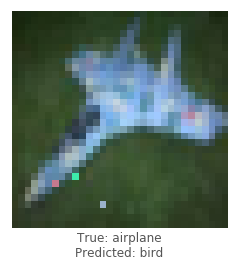

lecun_net - image 7690 - 54 / 100


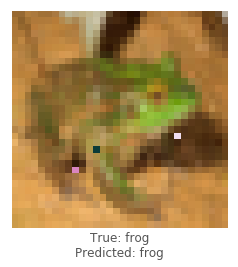

lecun_net - image 4868 - 55 / 100


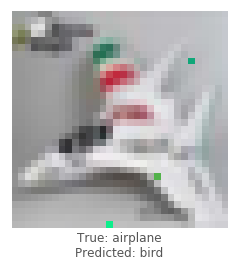

lecun_net - image 6592 - 56 / 100


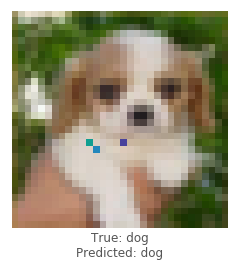

lecun_net - image 2778 - 57 / 100


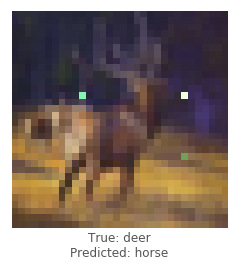

lecun_net - image 9387 - 58 / 100


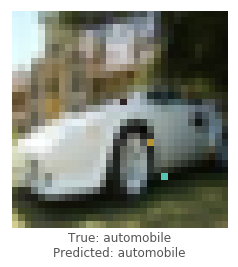

lecun_net - image 4025 - 59 / 100


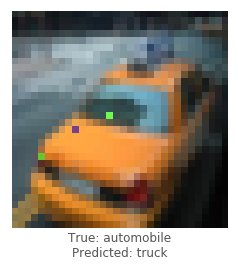

lecun_net - image 6479 - 60 / 100


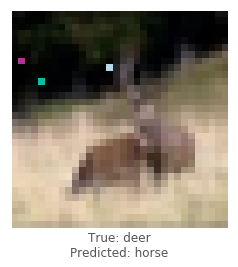

lecun_net - image 5293 - 61 / 100


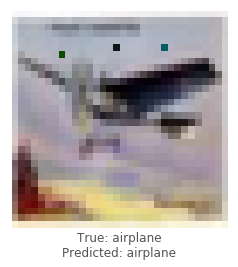

lecun_net - image 2682 - 62 / 100


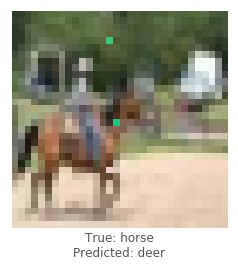

lecun_net - image 5513 - 63 / 100


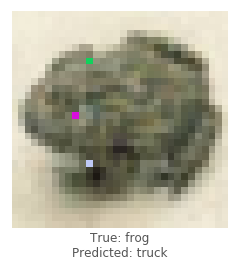

lecun_net - image 9790 - 64 / 100


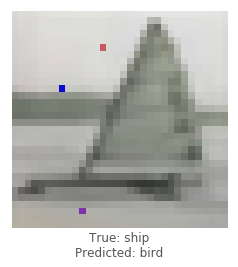

lecun_net - image 9768 - 65 / 100


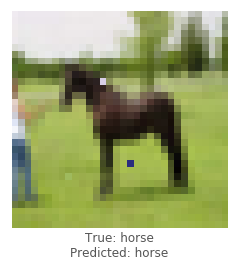

lecun_net - image 6867 - 66 / 100


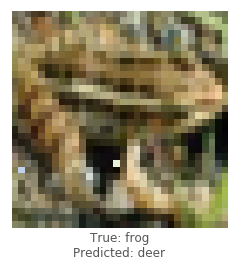

lecun_net - image 3252 - 67 / 100


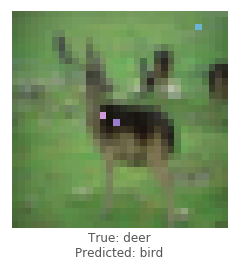

lecun_net - image 9783 - 68 / 100


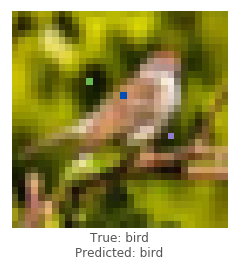

lecun_net - image 5657 - 69 / 100


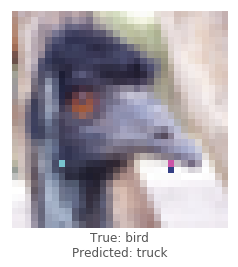

lecun_net - image 2879 - 70 / 100


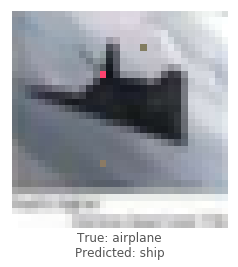

lecun_net - image 7943 - 71 / 100


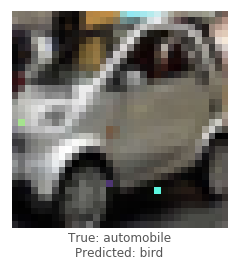

lecun_net - image 7155 - 72 / 100


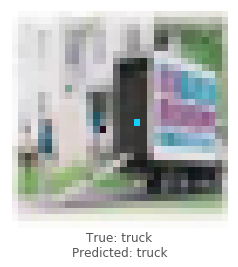

lecun_net - image 2438 - 73 / 100


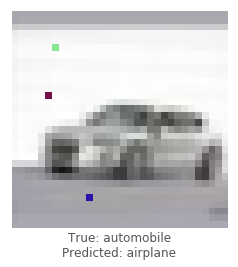

lecun_net - image 9614 - 74 / 100


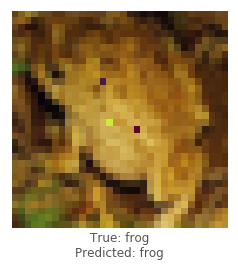

lecun_net - image 5026 - 75 / 100


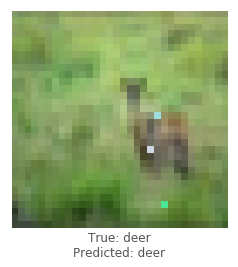

lecun_net - image 9153 - 76 / 100


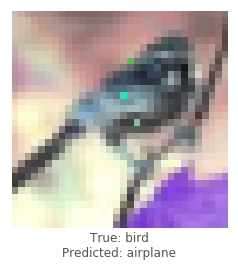

lecun_net - image 1809 - 77 / 100


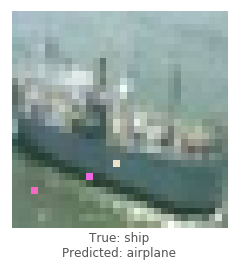

lecun_net - image 7601 - 78 / 100


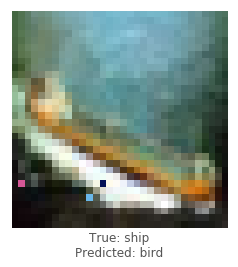

lecun_net - image 2338 - 79 / 100


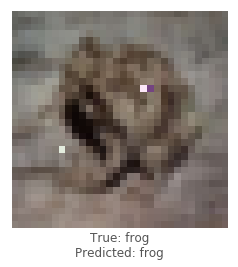

lecun_net - image 2289 - 80 / 100


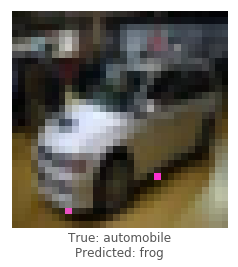

lecun_net - image 9988 - 81 / 100


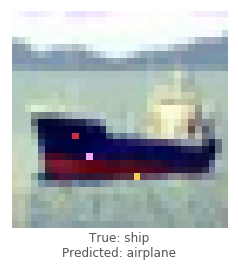

lecun_net - image 608 - 82 / 100


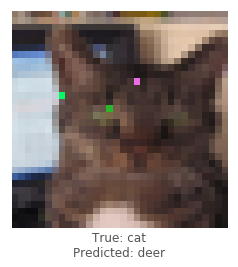

lecun_net - image 4958 - 83 / 100


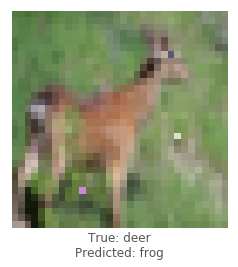

lecun_net - image 4332 - 84 / 100


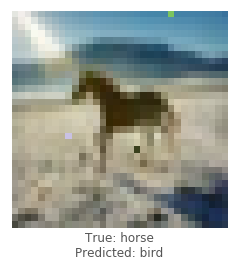

lecun_net - image 2443 - 85 / 100


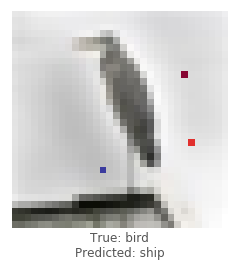

lecun_net - image 6045 - 86 / 100


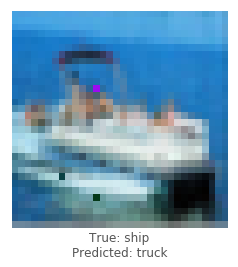

lecun_net - image 9210 - 87 / 100


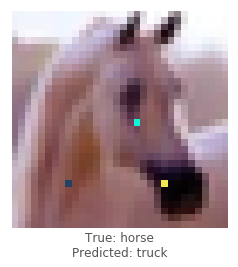

lecun_net - image 3024 - 88 / 100


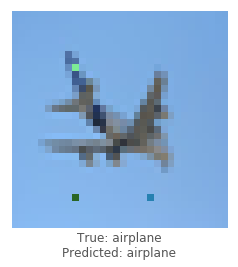

lecun_net - image 6755 - 89 / 100


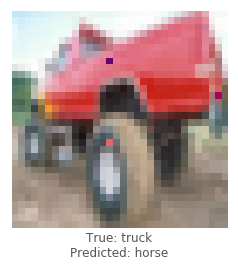

lecun_net - image 2112 - 90 / 100


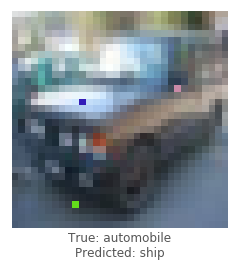

lecun_net - image 9978 - 91 / 100


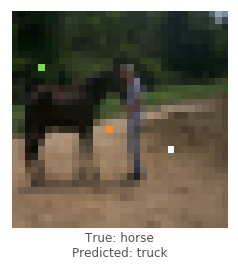

lecun_net - image 7917 - 92 / 100


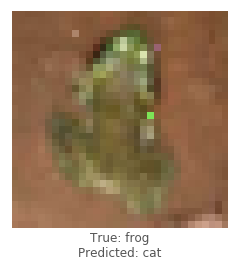

lecun_net - image 5459 - 93 / 100


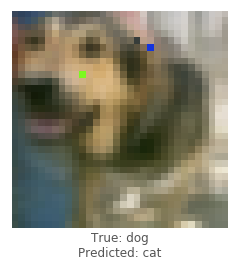

lecun_net - image 7460 - 94 / 100


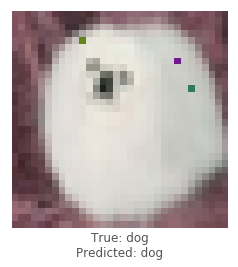

lecun_net - image 4822 - 95 / 100


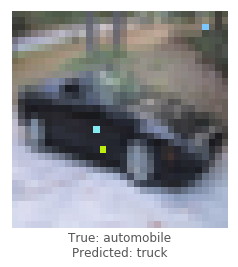

lecun_net - image 4406 - 96 / 100


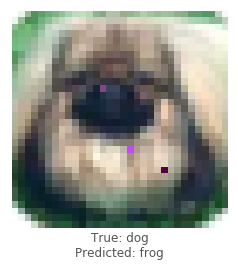

lecun_net - image 5476 - 97 / 100


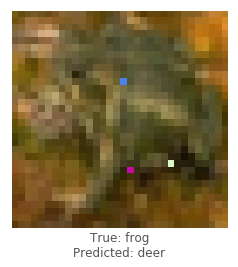

lecun_net - image 5757 - 98 / 100


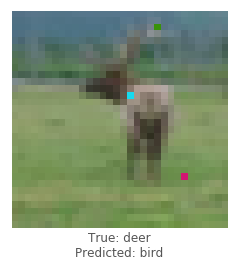

lecun_net - image 2391 - 99 / 100


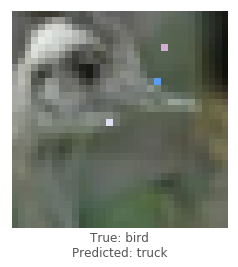

lecun_net - image 5626 - 100 / 100


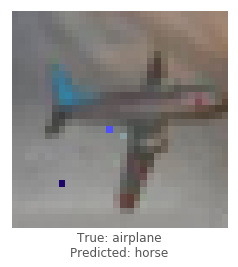

pure_cnn - image 4031 - 1 / 100


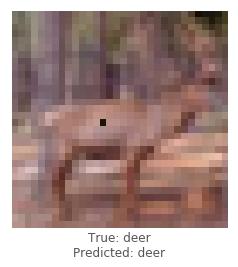

pure_cnn - image 3067 - 2 / 100


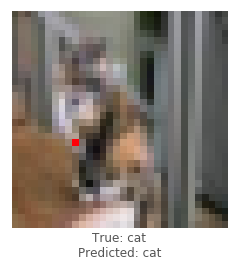

pure_cnn - image 8637 - 3 / 100


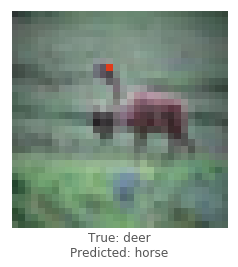

pure_cnn - image 7674 - 4 / 100


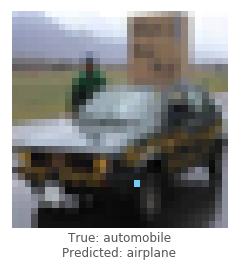

pure_cnn - image 1558 - 5 / 100


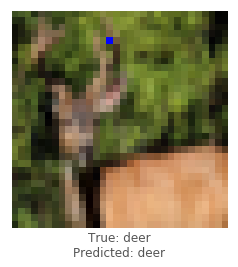

pure_cnn - image 7677 - 6 / 100


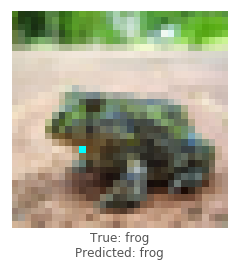

pure_cnn - image 2196 - 7 / 100


/home/hyper/Documents/anaconda3/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:533: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


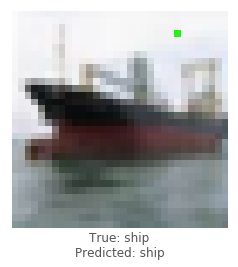

pure_cnn - image 56 - 8 / 100


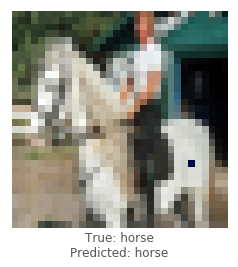

pure_cnn - image 7610 - 9 / 100


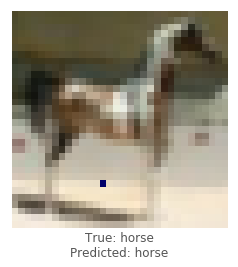

pure_cnn - image 7537 - 10 / 100


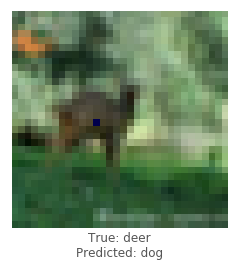

pure_cnn - image 9759 - 11 / 100


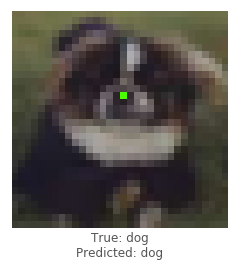

pure_cnn - image 4633 - 12 / 100


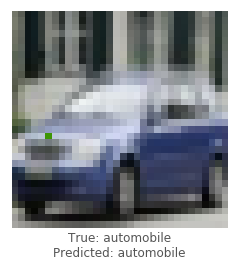

pure_cnn - image 9055 - 13 / 100


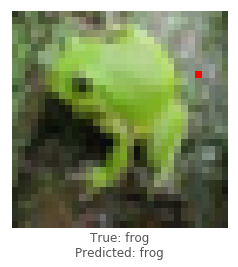

pure_cnn - image 2585 - 14 / 100


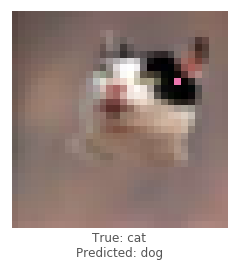

pure_cnn - image 2529 - 15 / 100


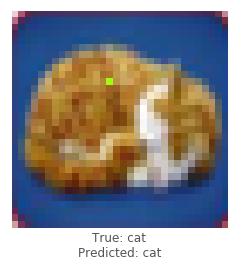

pure_cnn - image 884 - 16 / 100


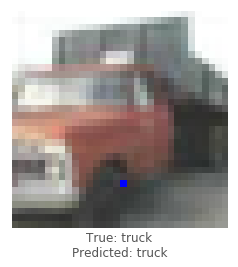

pure_cnn - image 8110 - 17 / 100


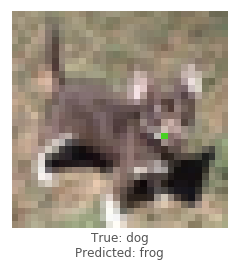

pure_cnn - image 7490 - 18 / 100


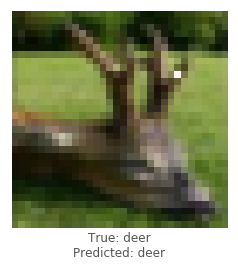

pure_cnn - image 4976 - 19 / 100


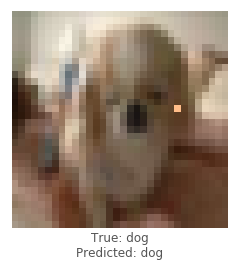

pure_cnn - image 746 - 20 / 100


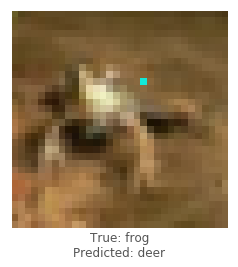

pure_cnn - image 9848 - 21 / 100


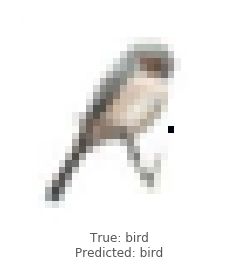

pure_cnn - image 9716 - 22 / 100


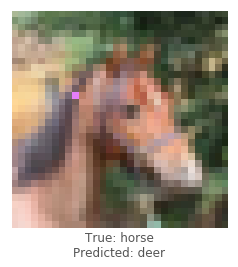

pure_cnn - image 9584 - 23 / 100


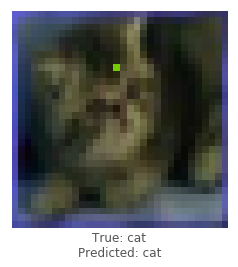

pure_cnn - image 1557 - 24 / 100


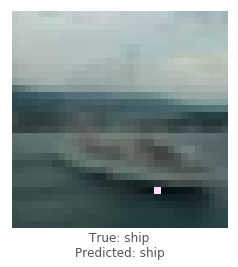

pure_cnn - image 9481 - 25 / 100


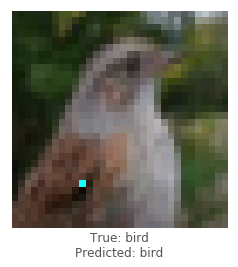

pure_cnn - image 3693 - 26 / 100


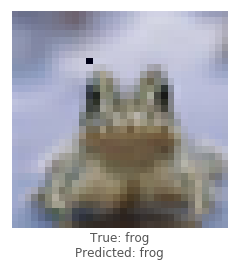

pure_cnn - image 9342 - 27 / 100


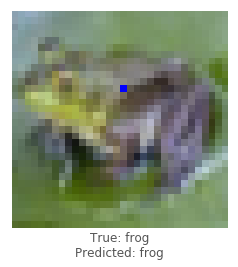

pure_cnn - image 606 - 28 / 100


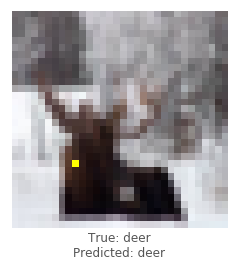

pure_cnn - image 9311 - 29 / 100


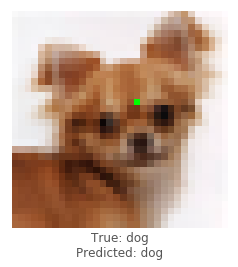

pure_cnn - image 3490 - 30 / 100


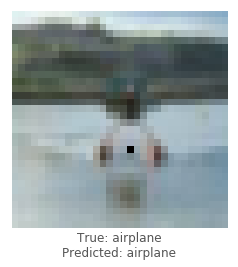

pure_cnn - image 781 - 31 / 100


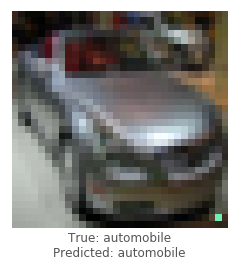

pure_cnn - image 4116 - 32 / 100


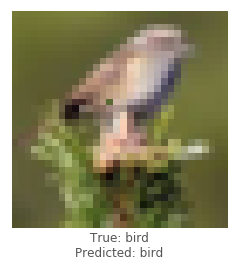

pure_cnn - image 7948 - 33 / 100


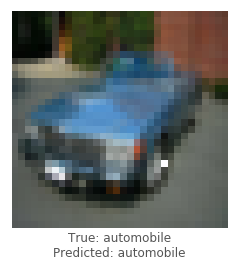

pure_cnn - image 2605 - 34 / 100


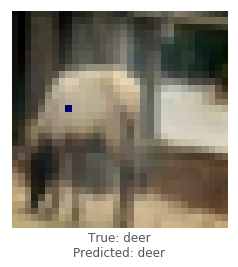

pure_cnn - image 1991 - 35 / 100


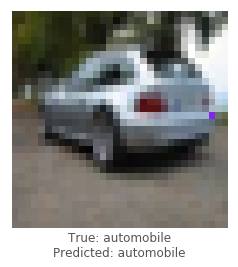

pure_cnn - image 9072 - 36 / 100


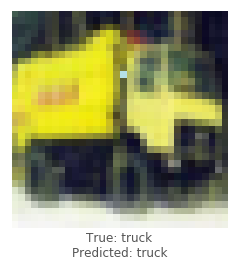

pure_cnn - image 1665 - 37 / 100


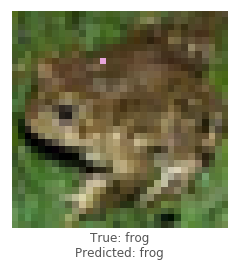

pure_cnn - image 5129 - 38 / 100


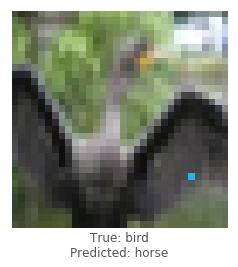

pure_cnn - image 4802 - 39 / 100


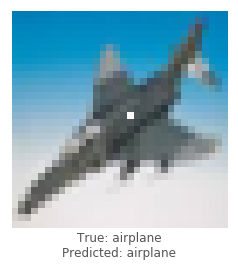

pure_cnn - image 3681 - 40 / 100


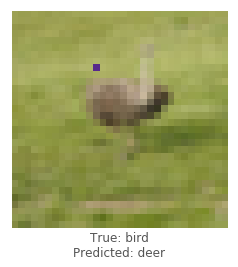

pure_cnn - image 5532 - 41 / 100


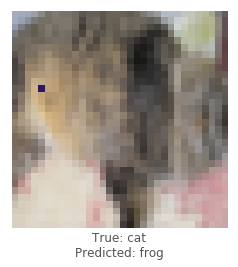

pure_cnn - image 2335 - 42 / 100


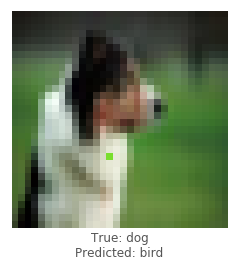

pure_cnn - image 3071 - 43 / 100


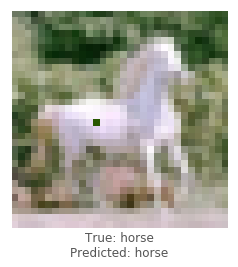

pure_cnn - image 47 - 44 / 100


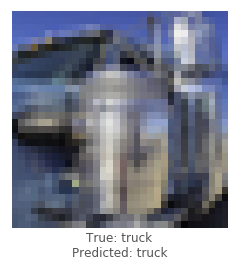

pure_cnn - image 385 - 45 / 100


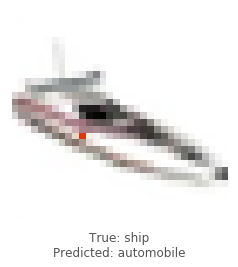

pure_cnn - image 8984 - 46 / 100


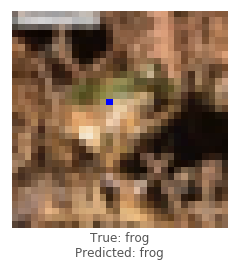

pure_cnn - image 9076 - 47 / 100


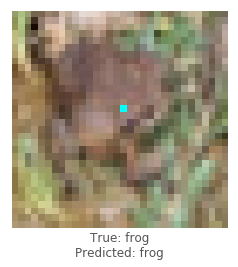

pure_cnn - image 3205 - 48 / 100


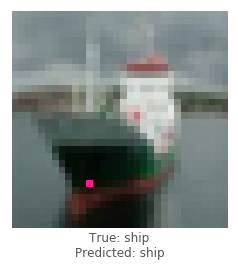

pure_cnn - image 945 - 49 / 100


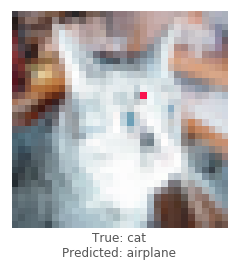

pure_cnn - image 4478 - 50 / 100


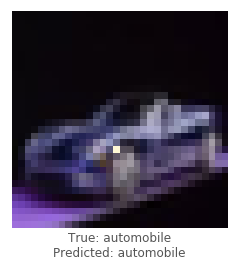

pure_cnn - image 7191 - 51 / 100


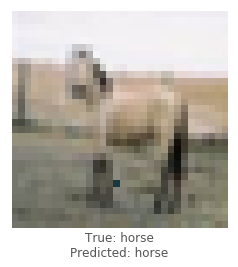

pure_cnn - image 718 - 52 / 100


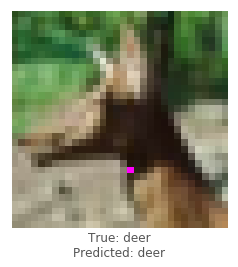

pure_cnn - image 7219 - 53 / 100


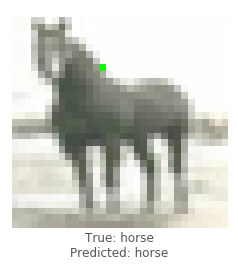

pure_cnn - image 1600 - 54 / 100


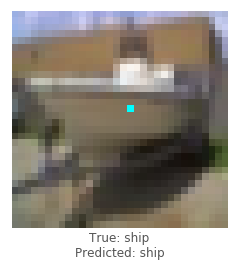

pure_cnn - image 6181 - 55 / 100


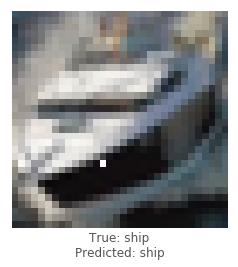

pure_cnn - image 9712 - 56 / 100


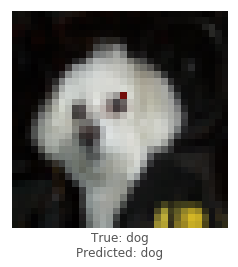

pure_cnn - image 341 - 57 / 100


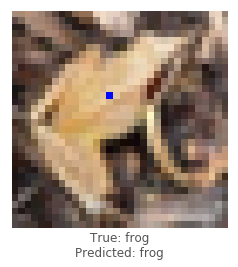

pure_cnn - image 9232 - 58 / 100


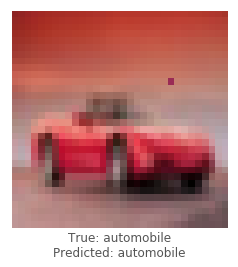

pure_cnn - image 528 - 59 / 100


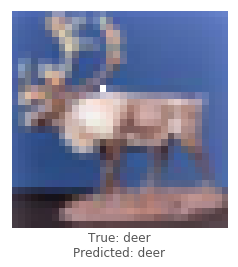

pure_cnn - image 4328 - 60 / 100


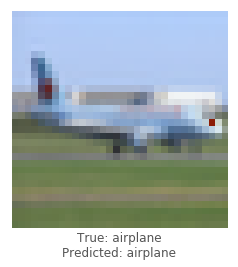

pure_cnn - image 9824 - 61 / 100


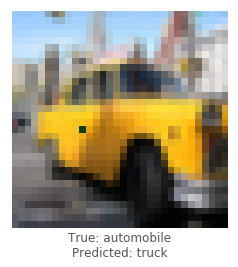

pure_cnn - image 7966 - 62 / 100


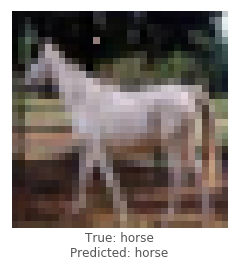

pure_cnn - image 365 - 63 / 100


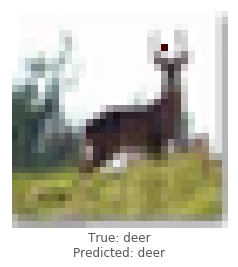

pure_cnn - image 2222 - 64 / 100


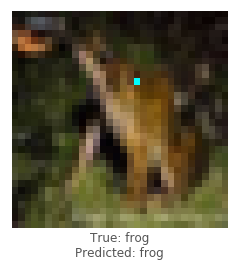

pure_cnn - image 5009 - 65 / 100


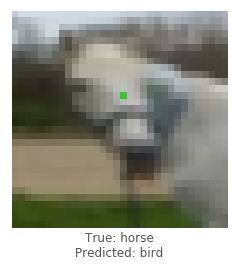

pure_cnn - image 2174 - 66 / 100


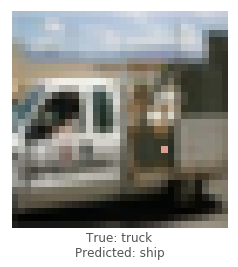

pure_cnn - image 9178 - 67 / 100


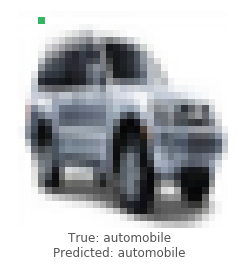

pure_cnn - image 4489 - 68 / 100


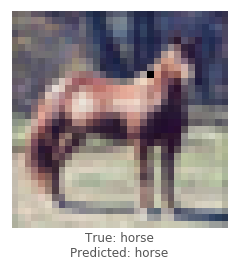

pure_cnn - image 9001 - 69 / 100


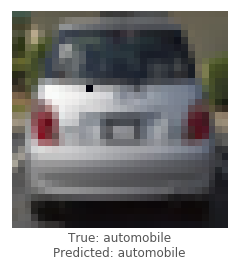

pure_cnn - image 9193 - 70 / 100


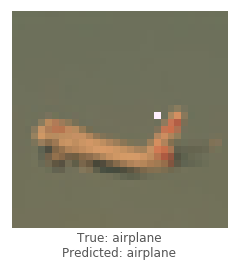

pure_cnn - image 895 - 71 / 100


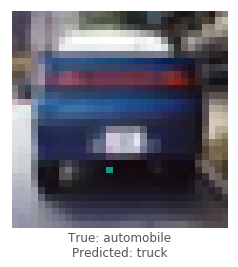

pure_cnn - image 917 - 72 / 100


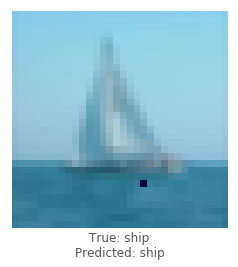

pure_cnn - image 9935 - 73 / 100


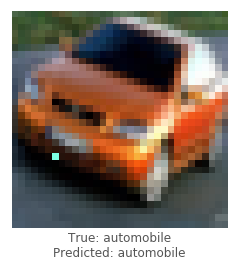

pure_cnn - image 2732 - 74 / 100


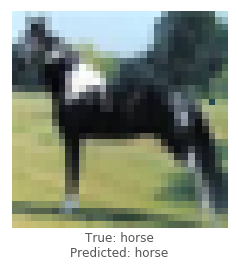

pure_cnn - image 514 - 75 / 100


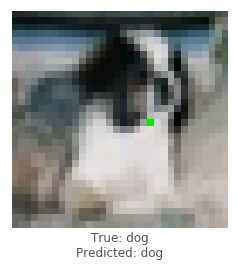

pure_cnn - image 5970 - 76 / 100


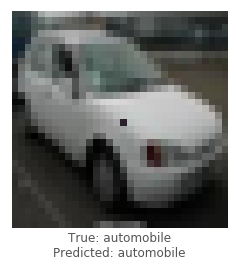

pure_cnn - image 4344 - 77 / 100


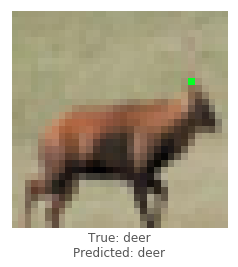

pure_cnn - image 2407 - 78 / 100


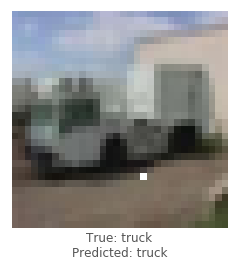

pure_cnn - image 9072 - 79 / 100


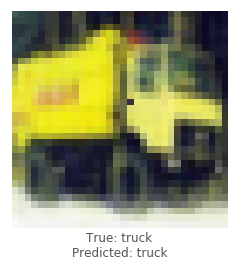

pure_cnn - image 8134 - 80 / 100


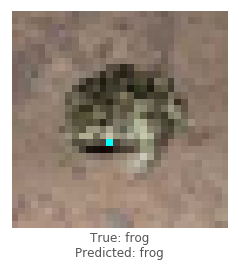

pure_cnn - image 864 - 81 / 100


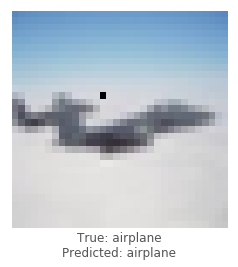

pure_cnn - image 7393 - 82 / 100


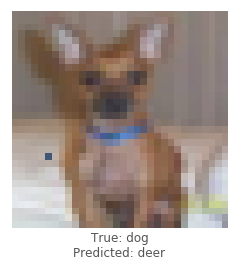

pure_cnn - image 9958 - 83 / 100


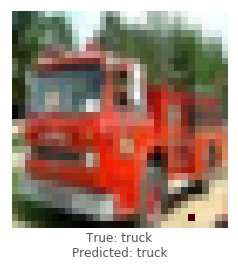

pure_cnn - image 1660 - 84 / 100


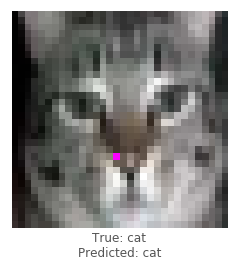

pure_cnn - image 4648 - 85 / 100


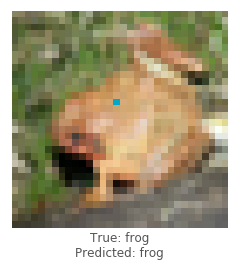

pure_cnn - image 2848 - 86 / 100


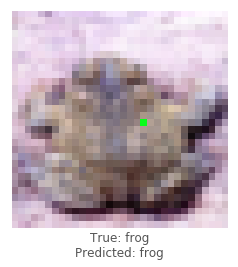

pure_cnn - image 5480 - 87 / 100


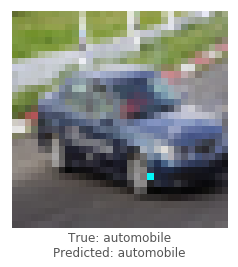

pure_cnn - image 6247 - 88 / 100


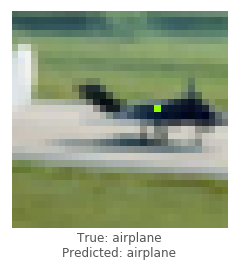

pure_cnn - image 4490 - 89 / 100


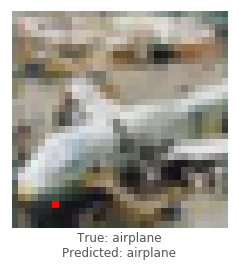

pure_cnn - image 78 - 90 / 100


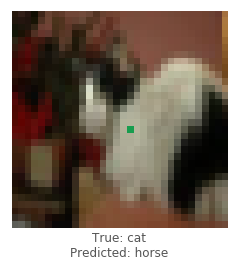

pure_cnn - image 1956 - 91 / 100


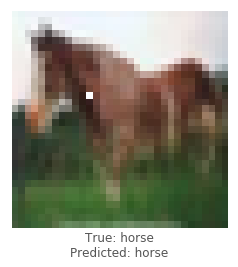

pure_cnn - image 875 - 92 / 100


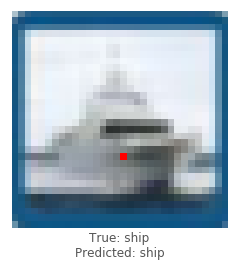

pure_cnn - image 9005 - 93 / 100


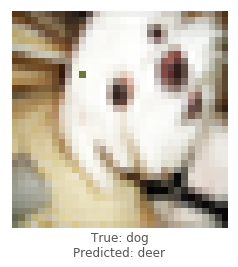

pure_cnn - image 0 - 94 / 100


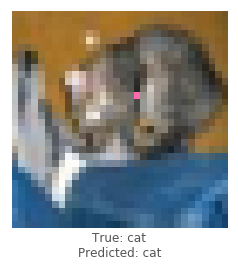

pure_cnn - image 1571 - 95 / 100


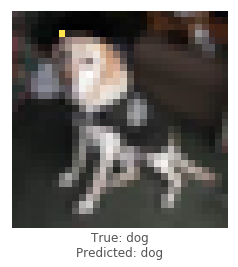

pure_cnn - image 632 - 96 / 100


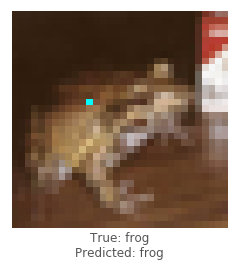

pure_cnn - image 9276 - 97 / 100


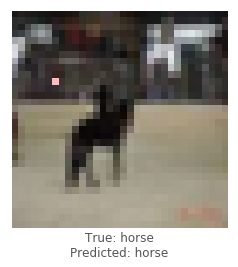

pure_cnn - image 3321 - 98 / 100


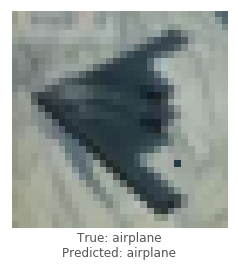

pure_cnn - image 9617 - 99 / 100


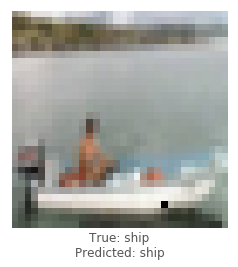

pure_cnn - image 6800 - 100 / 100


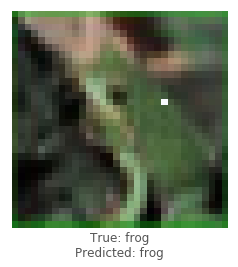

pure_cnn - image 4031 - 1 / 100


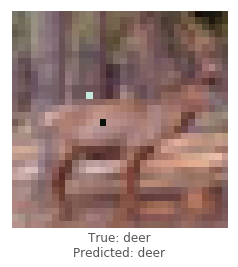

pure_cnn - image 3067 - 2 / 100


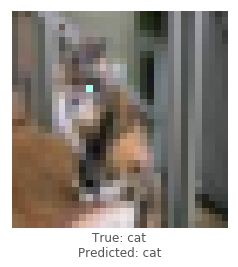

pure_cnn - image 8637 - 3 / 100


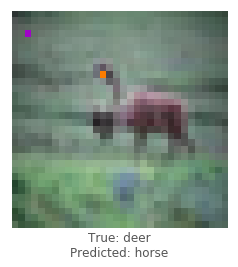

pure_cnn - image 7674 - 4 / 100


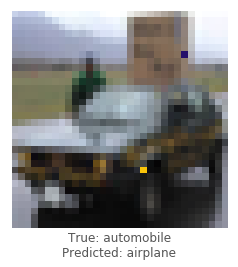

pure_cnn - image 1558 - 5 / 100


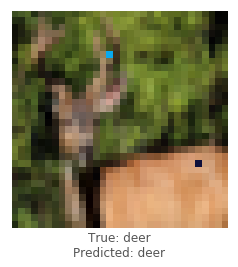

pure_cnn - image 7677 - 6 / 100


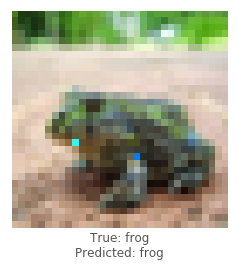

pure_cnn - image 2196 - 7 / 100


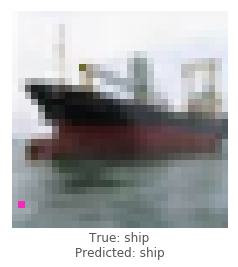

pure_cnn - image 56 - 8 / 100


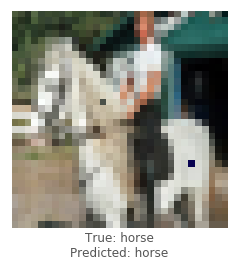

pure_cnn - image 7610 - 9 / 100


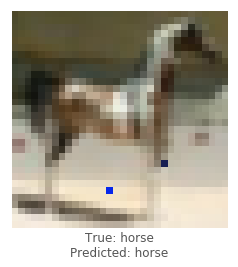

pure_cnn - image 7537 - 10 / 100


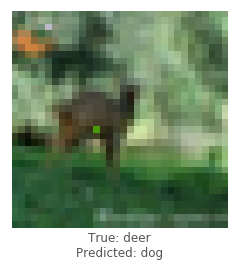

pure_cnn - image 9759 - 11 / 100


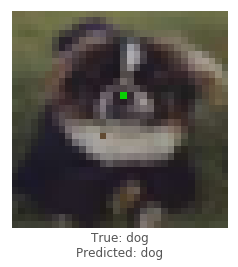

pure_cnn - image 4633 - 12 / 100


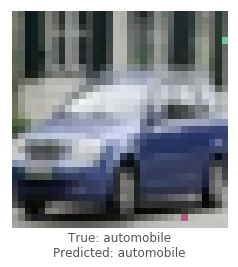

pure_cnn - image 9055 - 13 / 100


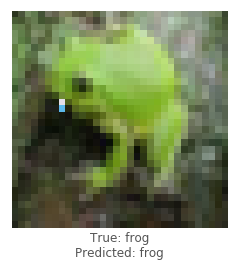

pure_cnn - image 2585 - 14 / 100


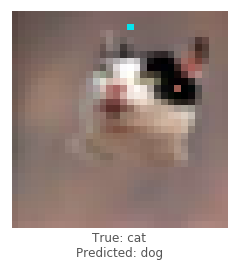

pure_cnn - image 2529 - 15 / 100


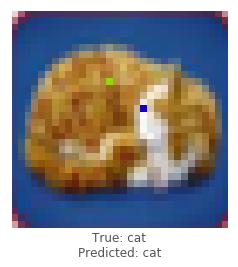

pure_cnn - image 884 - 16 / 100


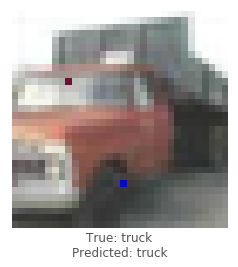

pure_cnn - image 8110 - 17 / 100


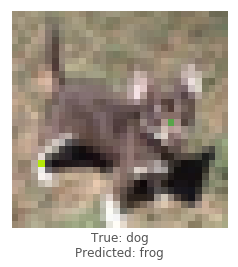

pure_cnn - image 7490 - 18 / 100


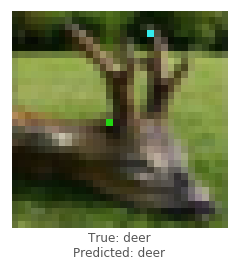

pure_cnn - image 4976 - 19 / 100


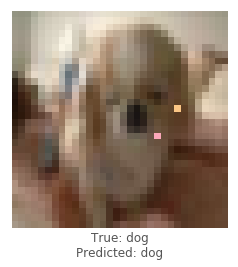

pure_cnn - image 746 - 20 / 100


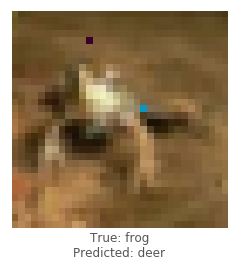

pure_cnn - image 9848 - 21 / 100


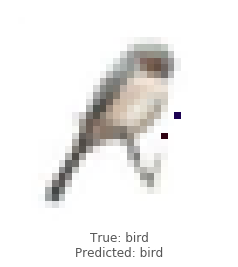

pure_cnn - image 9716 - 22 / 100


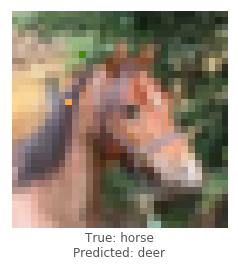

pure_cnn - image 9584 - 23 / 100


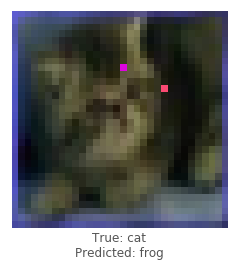

pure_cnn - image 1557 - 24 / 100


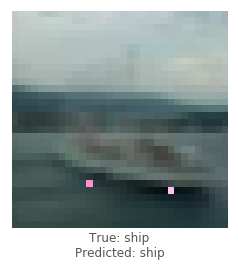

pure_cnn - image 9481 - 25 / 100


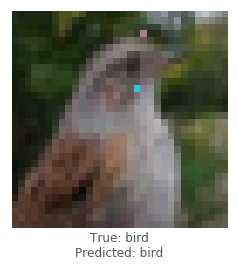

pure_cnn - image 3693 - 26 / 100


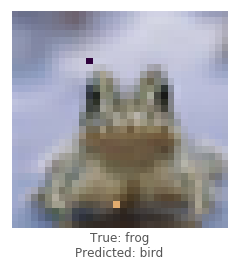

pure_cnn - image 9342 - 27 / 100


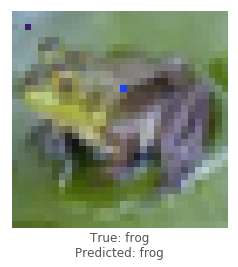

pure_cnn - image 606 - 28 / 100


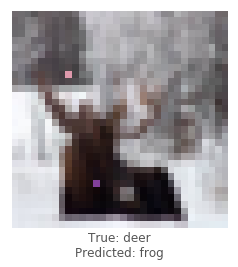

pure_cnn - image 9311 - 29 / 100


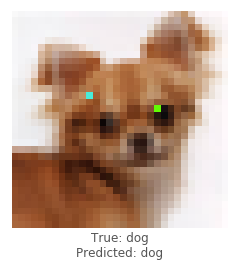

pure_cnn - image 3490 - 30 / 100


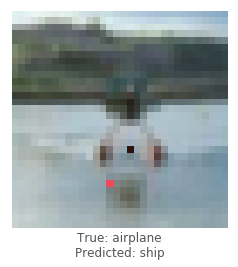

pure_cnn - image 781 - 31 / 100


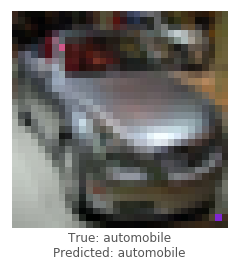

pure_cnn - image 4116 - 32 / 100


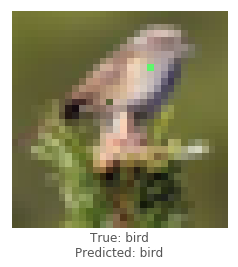

pure_cnn - image 7948 - 33 / 100


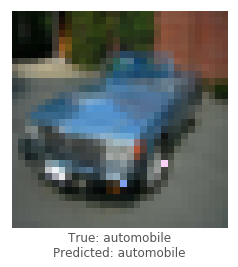

pure_cnn - image 2605 - 34 / 100


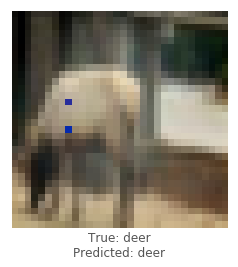

pure_cnn - image 1991 - 35 / 100


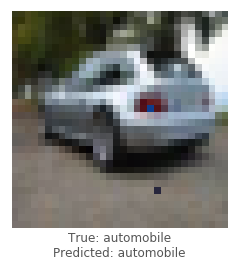

pure_cnn - image 9072 - 36 / 100


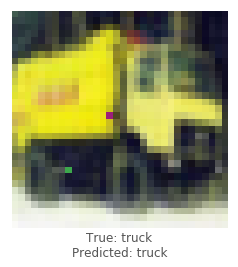

pure_cnn - image 1665 - 37 / 100


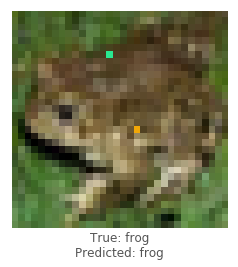

pure_cnn - image 5129 - 38 / 100


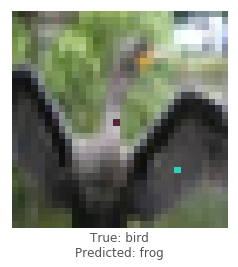

pure_cnn - image 4802 - 39 / 100


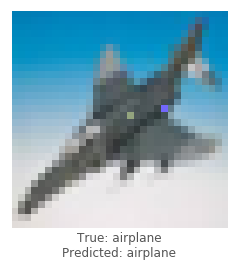

pure_cnn - image 3681 - 40 / 100


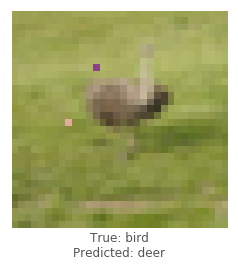

pure_cnn - image 5532 - 41 / 100


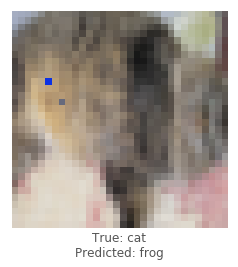

pure_cnn - image 2335 - 42 / 100


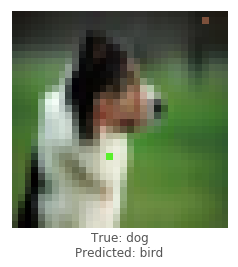

pure_cnn - image 3071 - 43 / 100


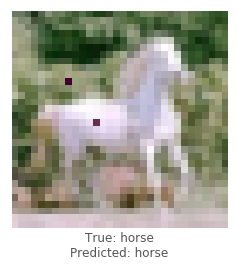

pure_cnn - image 47 - 44 / 100


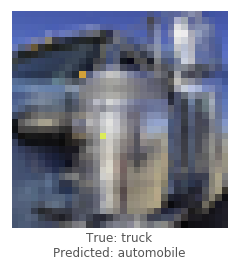

pure_cnn - image 385 - 45 / 100


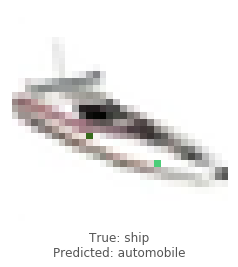

pure_cnn - image 8984 - 46 / 100


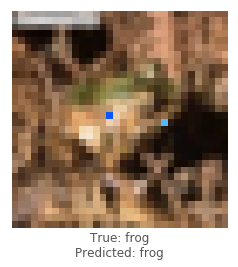

pure_cnn - image 9076 - 47 / 100


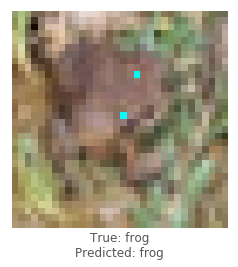

pure_cnn - image 3205 - 48 / 100


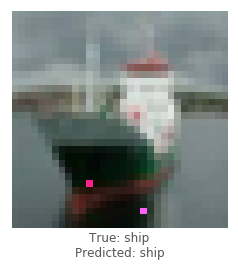

pure_cnn - image 945 - 49 / 100


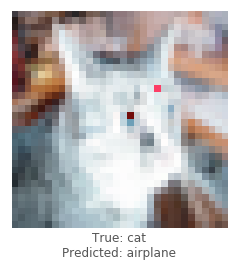

pure_cnn - image 4478 - 50 / 100


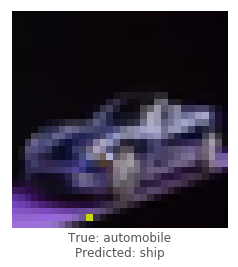

pure_cnn - image 7191 - 51 / 100


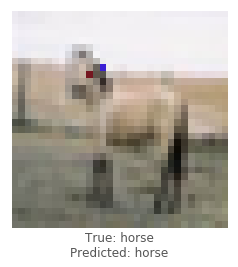

pure_cnn - image 718 - 52 / 100


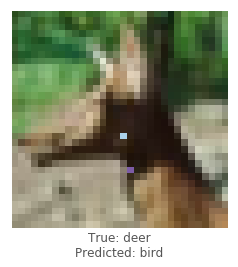

pure_cnn - image 7219 - 53 / 100


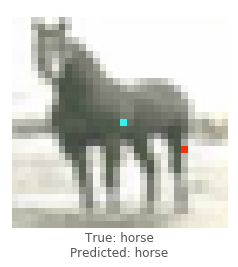

pure_cnn - image 1600 - 54 / 100


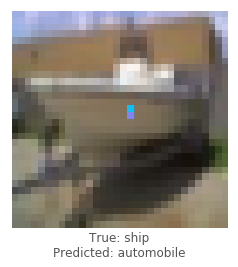

pure_cnn - image 6181 - 55 / 100


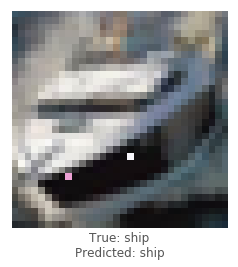

pure_cnn - image 9712 - 56 / 100


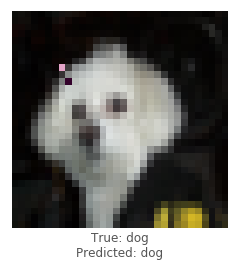

pure_cnn - image 341 - 57 / 100


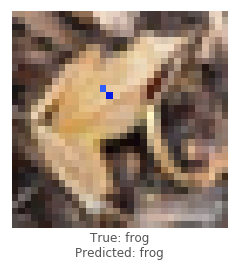

pure_cnn - image 9232 - 58 / 100


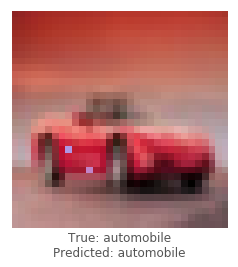

pure_cnn - image 528 - 59 / 100


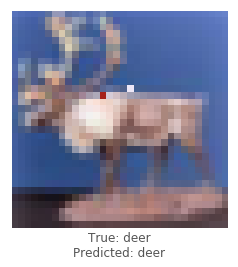

pure_cnn - image 4328 - 60 / 100


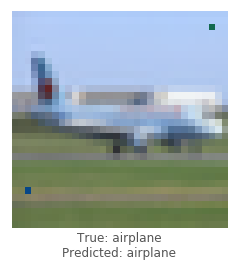

pure_cnn - image 9824 - 61 / 100


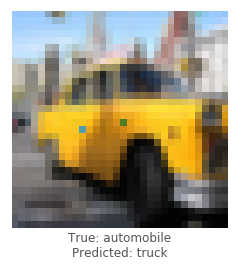

pure_cnn - image 7966 - 62 / 100


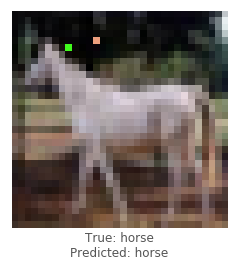

pure_cnn - image 365 - 63 / 100


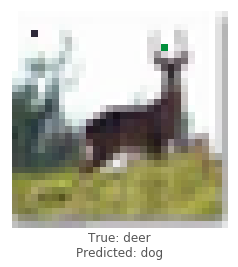

pure_cnn - image 2222 - 64 / 100


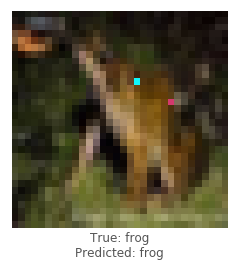

pure_cnn - image 5009 - 65 / 100


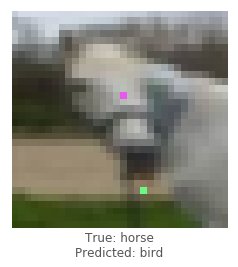

pure_cnn - image 2174 - 66 / 100


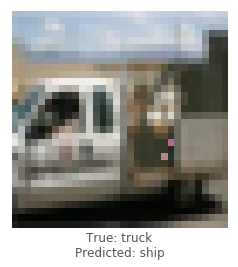

pure_cnn - image 9178 - 67 / 100


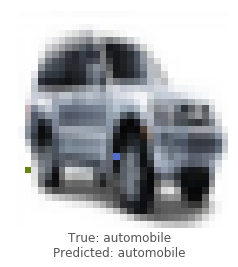

pure_cnn - image 4489 - 68 / 100


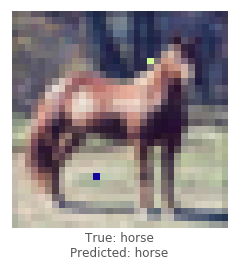

pure_cnn - image 9001 - 69 / 100


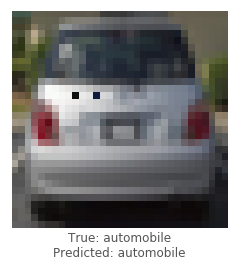

pure_cnn - image 9193 - 70 / 100


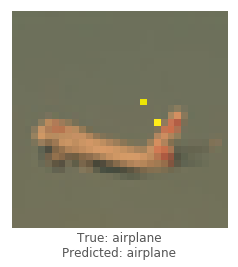

pure_cnn - image 895 - 71 / 100


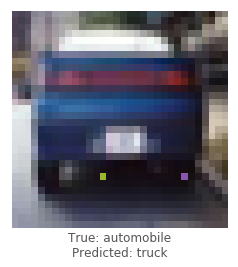

pure_cnn - image 917 - 72 / 100


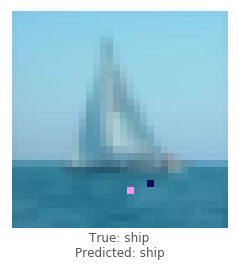

pure_cnn - image 9935 - 73 / 100


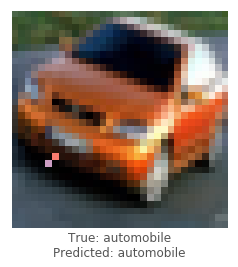

pure_cnn - image 2732 - 74 / 100


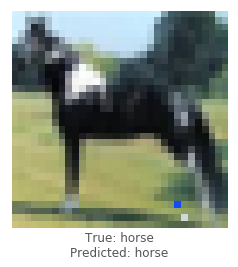

pure_cnn - image 514 - 75 / 100


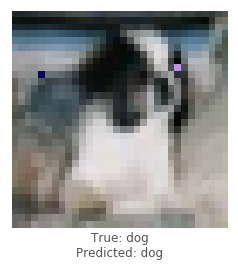

pure_cnn - image 5970 - 76 / 100


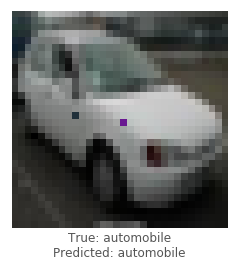

pure_cnn - image 4344 - 77 / 100


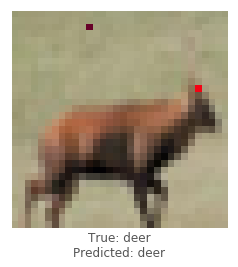

pure_cnn - image 2407 - 78 / 100


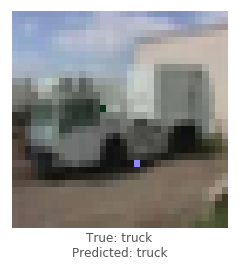

pure_cnn - image 9072 - 79 / 100


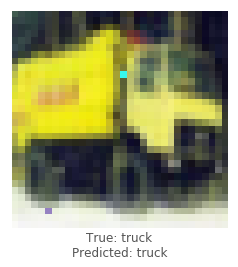

pure_cnn - image 8134 - 80 / 100


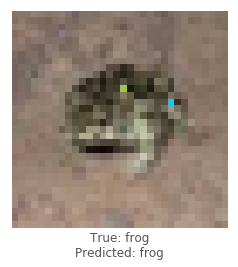

pure_cnn - image 864 - 81 / 100


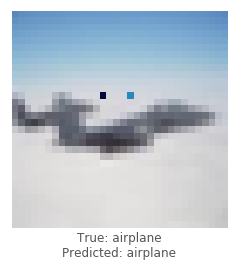

pure_cnn - image 7393 - 82 / 100


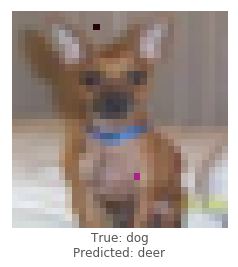

pure_cnn - image 9958 - 83 / 100


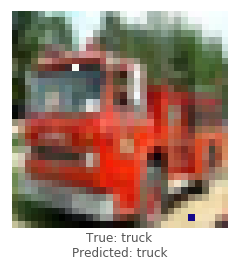

pure_cnn - image 1660 - 84 / 100


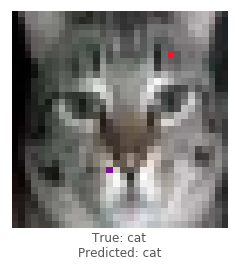

pure_cnn - image 4648 - 85 / 100


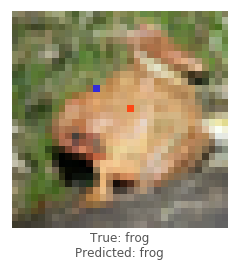

pure_cnn - image 2848 - 86 / 100


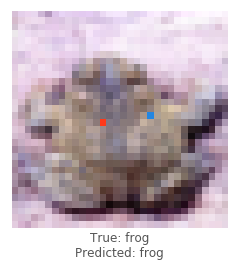

pure_cnn - image 5480 - 87 / 100


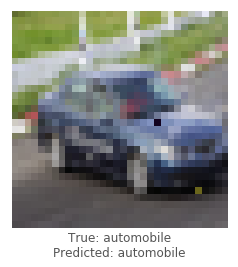

pure_cnn - image 6247 - 88 / 100


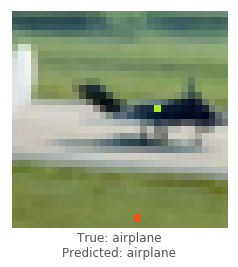

pure_cnn - image 4490 - 89 / 100


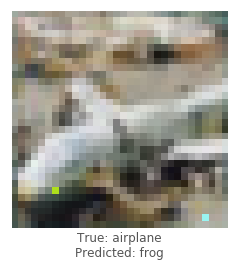

pure_cnn - image 78 - 90 / 100


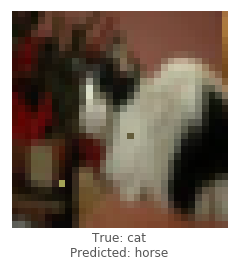

pure_cnn - image 1956 - 91 / 100


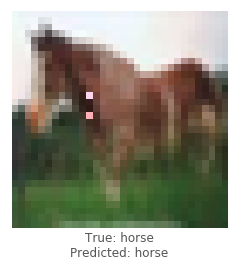

pure_cnn - image 875 - 92 / 100


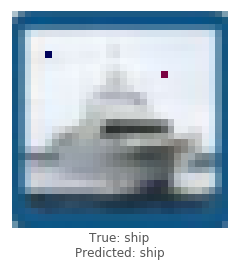

pure_cnn - image 9005 - 93 / 100


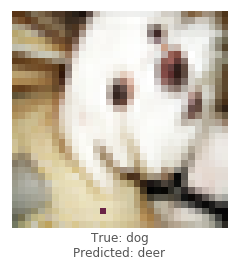

pure_cnn - image 0 - 94 / 100


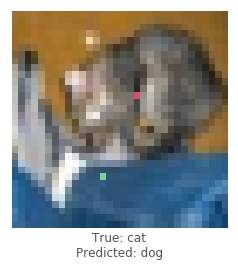

pure_cnn - image 1571 - 95 / 100


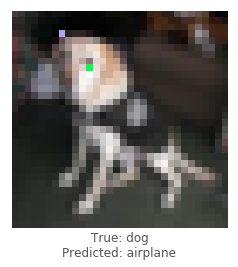

pure_cnn - image 632 - 96 / 100


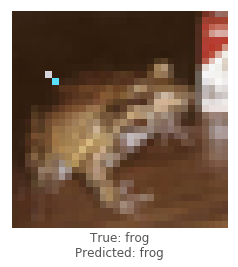

pure_cnn - image 9276 - 97 / 100


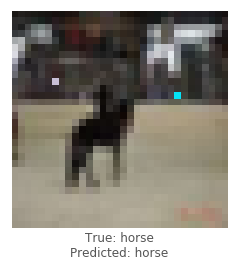

pure_cnn - image 3321 - 98 / 100


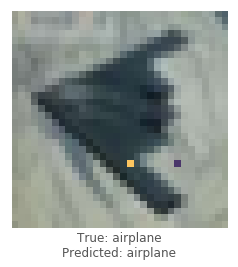

pure_cnn - image 9617 - 99 / 100


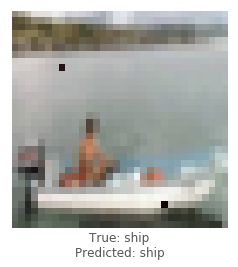

pure_cnn - image 6800 - 100 / 100


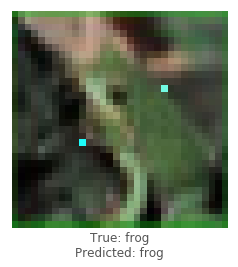

pure_cnn - image 4031 - 1 / 100


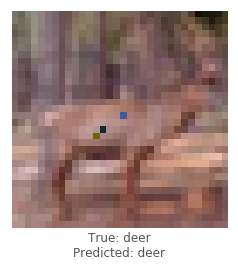

pure_cnn - image 3067 - 2 / 100


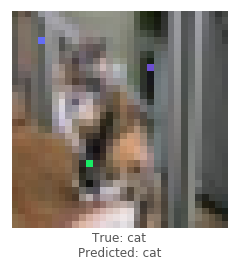

pure_cnn - image 8637 - 3 / 100


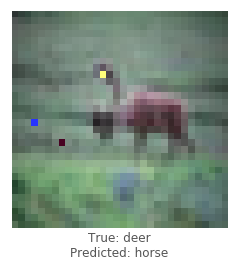

pure_cnn - image 7674 - 4 / 100


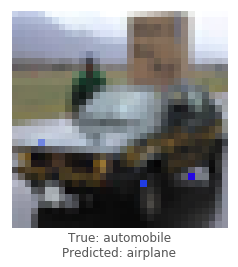

pure_cnn - image 1558 - 5 / 100


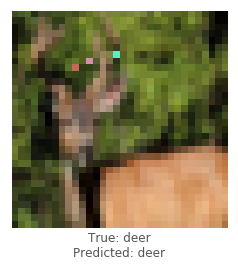

pure_cnn - image 7677 - 6 / 100


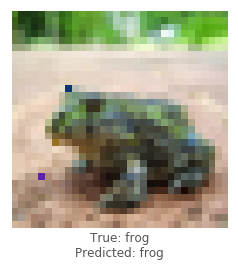

pure_cnn - image 2196 - 7 / 100


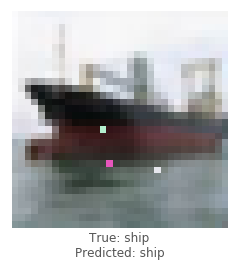

pure_cnn - image 56 - 8 / 100


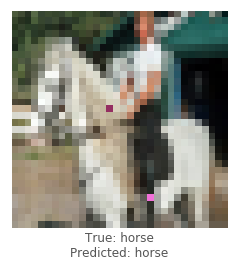

pure_cnn - image 7610 - 9 / 100


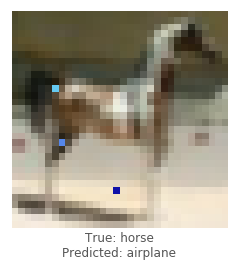

pure_cnn - image 7537 - 10 / 100


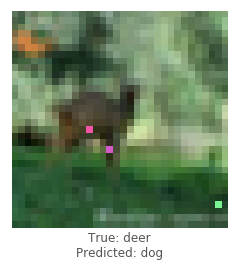

pure_cnn - image 9759 - 11 / 100


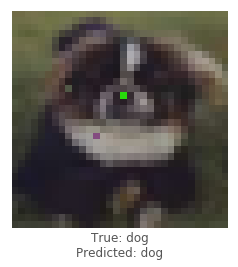

pure_cnn - image 4633 - 12 / 100


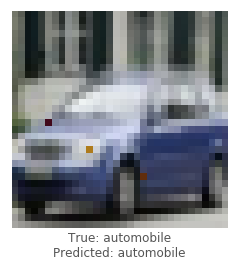

pure_cnn - image 9055 - 13 / 100


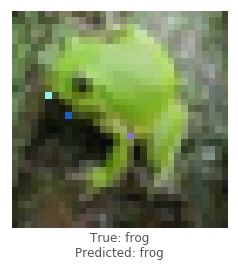

pure_cnn - image 2585 - 14 / 100


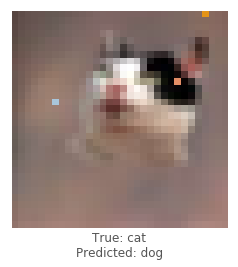

pure_cnn - image 2529 - 15 / 100


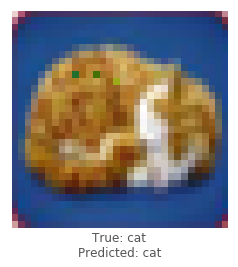

pure_cnn - image 884 - 16 / 100


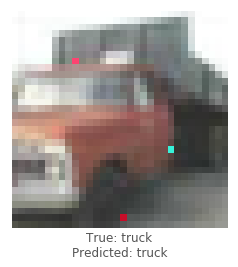

pure_cnn - image 8110 - 17 / 100


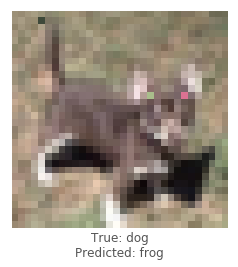

pure_cnn - image 7490 - 18 / 100


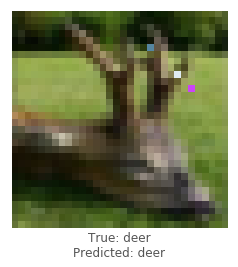

pure_cnn - image 4976 - 19 / 100


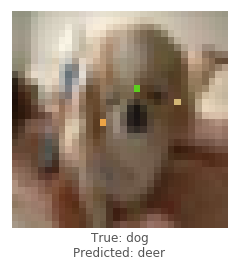

pure_cnn - image 746 - 20 / 100


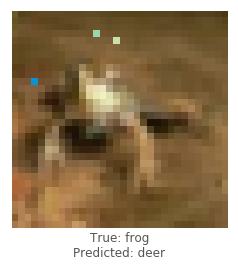

pure_cnn - image 9848 - 21 / 100


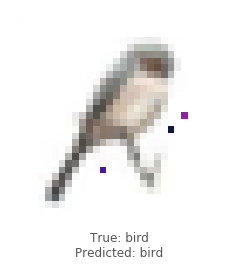

pure_cnn - image 9716 - 22 / 100


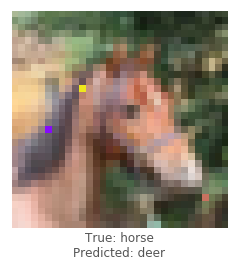

pure_cnn - image 9584 - 23 / 100


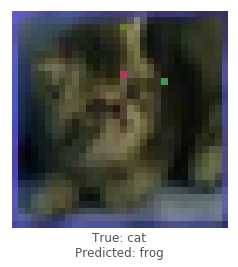

pure_cnn - image 1557 - 24 / 100


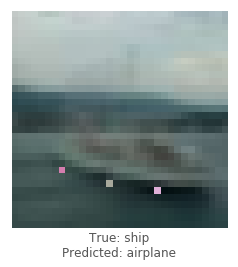

pure_cnn - image 9481 - 25 / 100


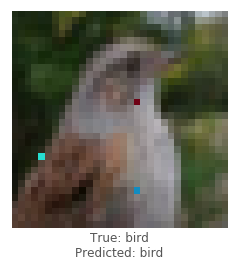

pure_cnn - image 3693 - 26 / 100


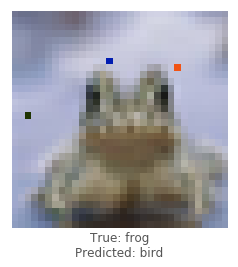

pure_cnn - image 9342 - 27 / 100


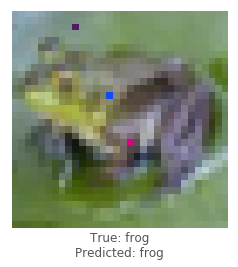

pure_cnn - image 606 - 28 / 100


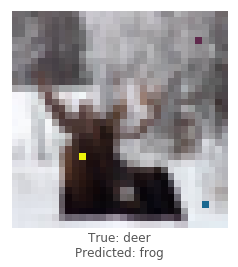

pure_cnn - image 9311 - 29 / 100


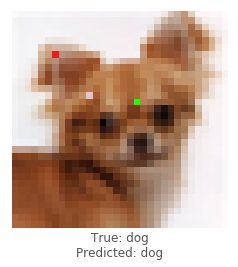

pure_cnn - image 3490 - 30 / 100


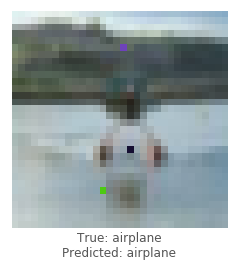

pure_cnn - image 781 - 31 / 100


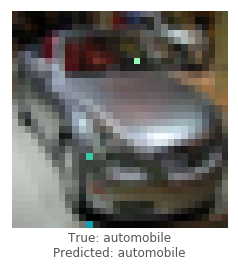

pure_cnn - image 4116 - 32 / 100


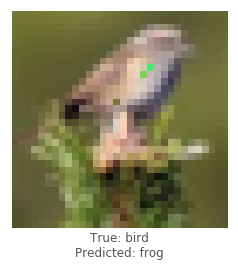

pure_cnn - image 7948 - 33 / 100


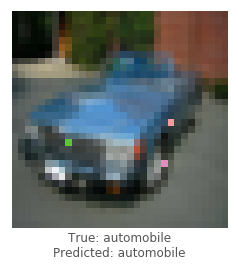

pure_cnn - image 2605 - 34 / 100


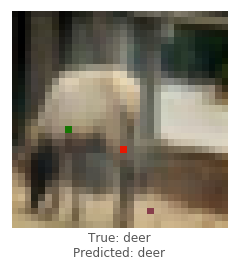

pure_cnn - image 1991 - 35 / 100


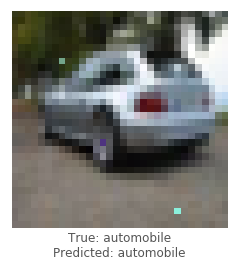

pure_cnn - image 9072 - 36 / 100


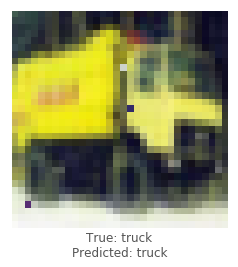

pure_cnn - image 1665 - 37 / 100


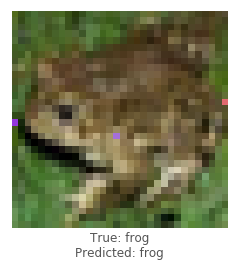

pure_cnn - image 5129 - 38 / 100


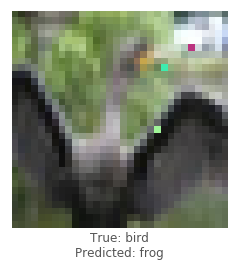

pure_cnn - image 4802 - 39 / 100


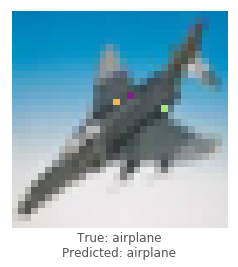

pure_cnn - image 3681 - 40 / 100


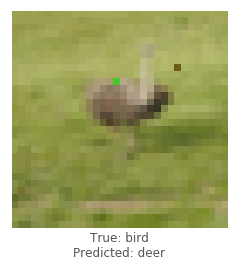

pure_cnn - image 5532 - 41 / 100


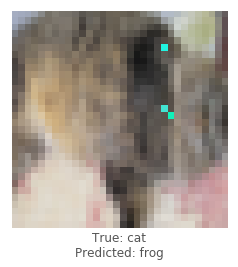

pure_cnn - image 2335 - 42 / 100


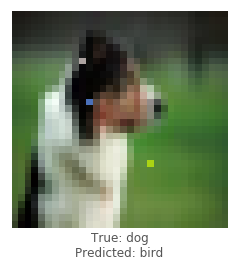

pure_cnn - image 3071 - 43 / 100


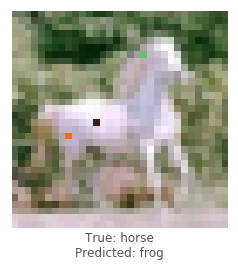

pure_cnn - image 47 - 44 / 100


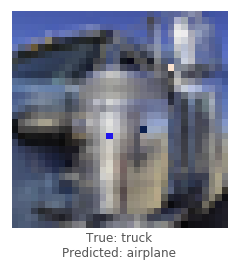

pure_cnn - image 385 - 45 / 100


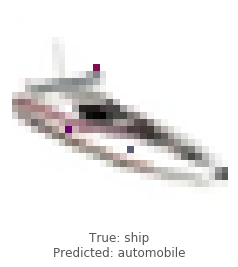

pure_cnn - image 8984 - 46 / 100


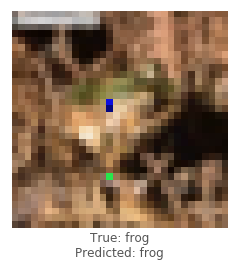

pure_cnn - image 9076 - 47 / 100


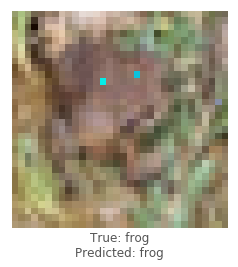

pure_cnn - image 3205 - 48 / 100


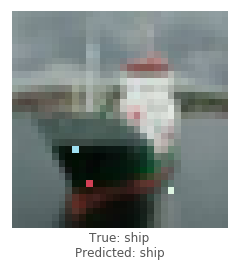

pure_cnn - image 945 - 49 / 100


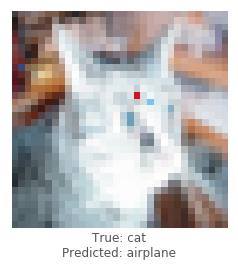

pure_cnn - image 4478 - 50 / 100


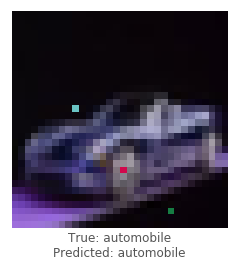

pure_cnn - image 7191 - 51 / 100


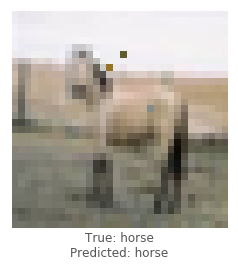

pure_cnn - image 718 - 52 / 100


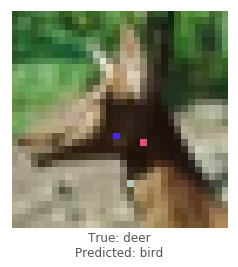

pure_cnn - image 7219 - 53 / 100


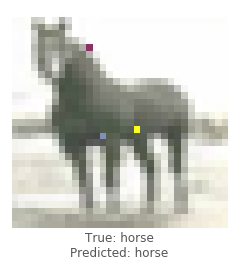

pure_cnn - image 1600 - 54 / 100


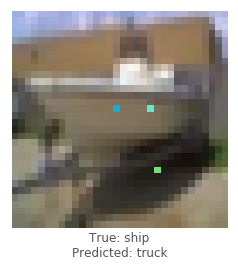

pure_cnn - image 6181 - 55 / 100


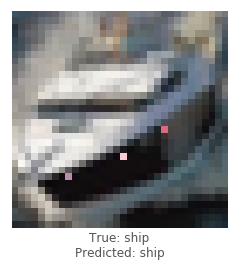

pure_cnn - image 9712 - 56 / 100


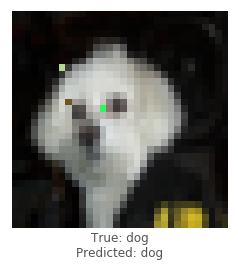

pure_cnn - image 341 - 57 / 100


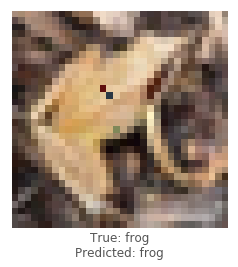

pure_cnn - image 9232 - 58 / 100


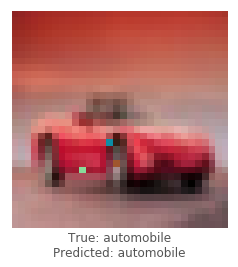

pure_cnn - image 528 - 59 / 100


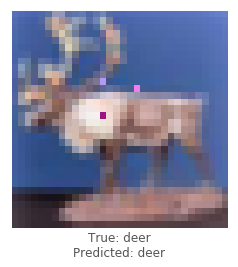

pure_cnn - image 4328 - 60 / 100


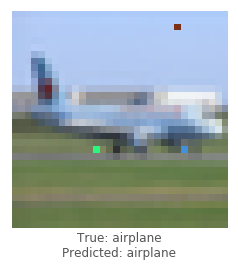

pure_cnn - image 9824 - 61 / 100


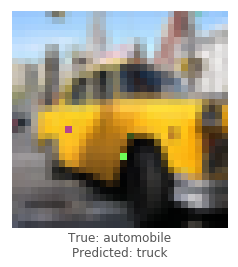

pure_cnn - image 7966 - 62 / 100


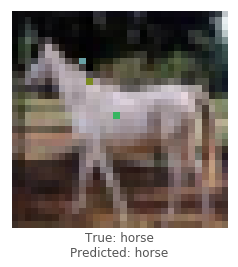

pure_cnn - image 365 - 63 / 100


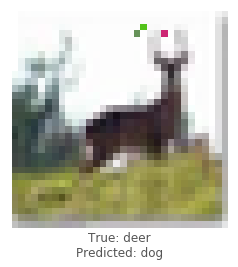

pure_cnn - image 2222 - 64 / 100


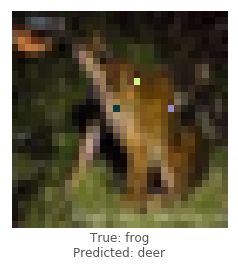

pure_cnn - image 5009 - 65 / 100


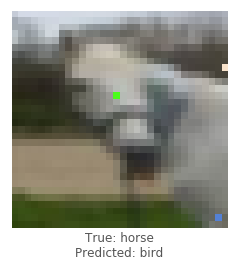

pure_cnn - image 2174 - 66 / 100


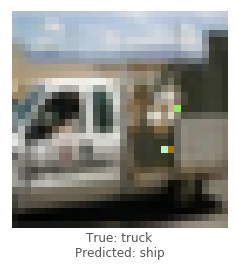

pure_cnn - image 9178 - 67 / 100


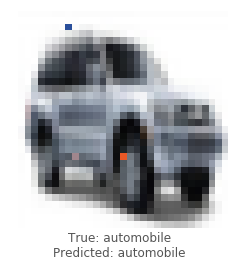

pure_cnn - image 4489 - 68 / 100


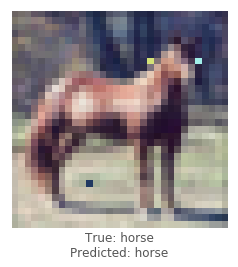

pure_cnn - image 9001 - 69 / 100


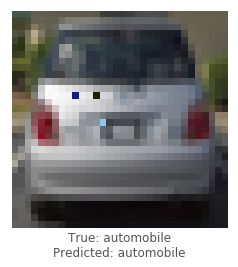

pure_cnn - image 9193 - 70 / 100


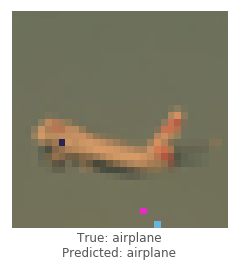

pure_cnn - image 895 - 71 / 100


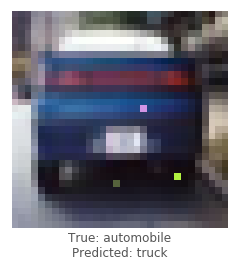

pure_cnn - image 917 - 72 / 100


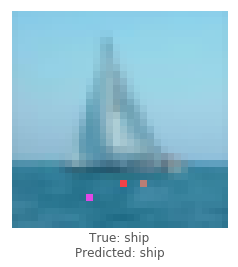

pure_cnn - image 9935 - 73 / 100


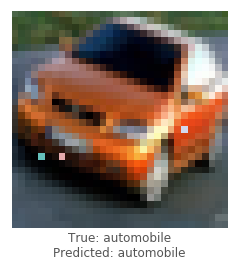

pure_cnn - image 2732 - 74 / 100


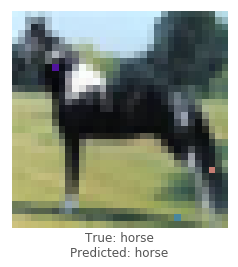

pure_cnn - image 514 - 75 / 100


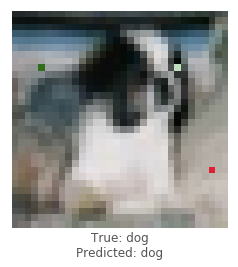

pure_cnn - image 5970 - 76 / 100


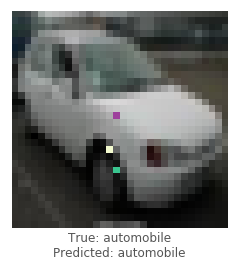

pure_cnn - image 4344 - 77 / 100


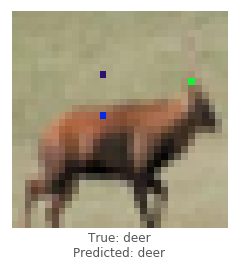

pure_cnn - image 2407 - 78 / 100


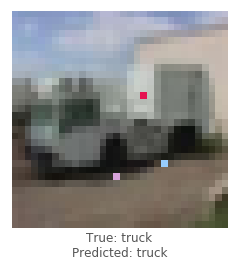

pure_cnn - image 9072 - 79 / 100


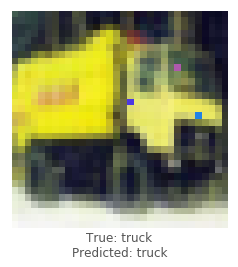

pure_cnn - image 8134 - 80 / 100


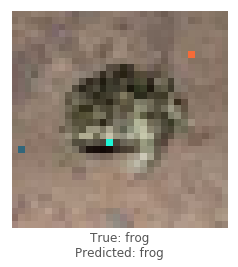

pure_cnn - image 864 - 81 / 100


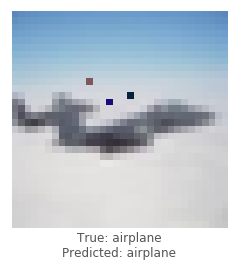

pure_cnn - image 7393 - 82 / 100


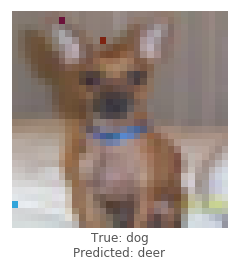

pure_cnn - image 9958 - 83 / 100


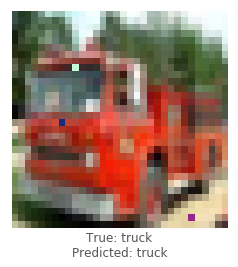

pure_cnn - image 1660 - 84 / 100


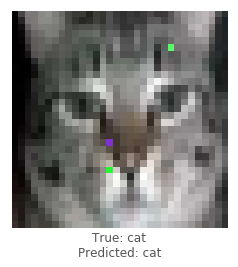

pure_cnn - image 4648 - 85 / 100


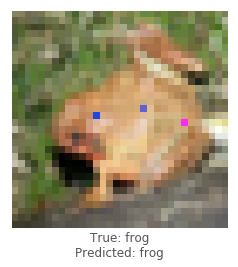

pure_cnn - image 2848 - 86 / 100


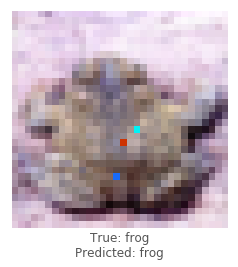

pure_cnn - image 5480 - 87 / 100


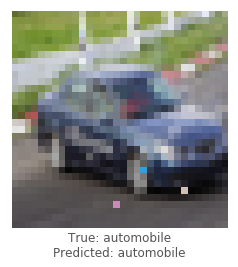

pure_cnn - image 6247 - 88 / 100


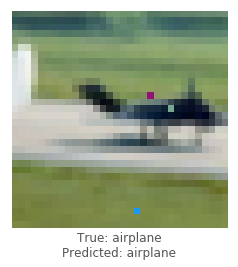

pure_cnn - image 4490 - 89 / 100


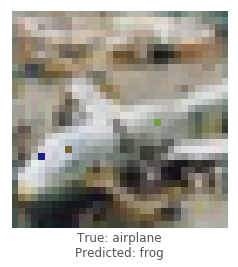

pure_cnn - image 78 - 90 / 100


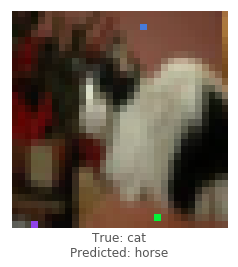

pure_cnn - image 1956 - 91 / 100


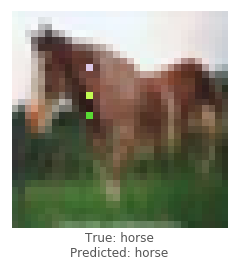

pure_cnn - image 875 - 92 / 100


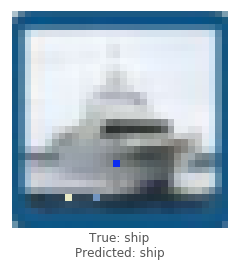

pure_cnn - image 9005 - 93 / 100


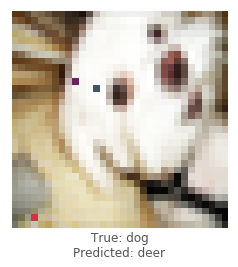

pure_cnn - image 0 - 94 / 100


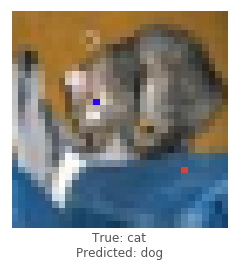

pure_cnn - image 1571 - 95 / 100


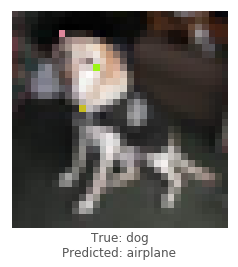

pure_cnn - image 632 - 96 / 100


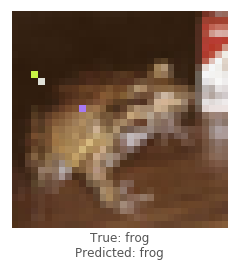

pure_cnn - image 9276 - 97 / 100


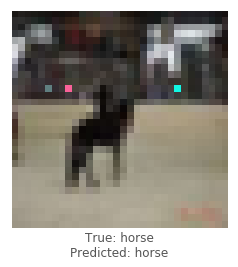

pure_cnn - image 3321 - 98 / 100


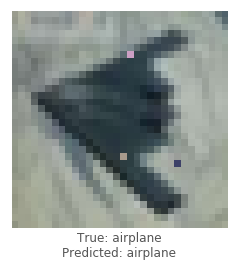

pure_cnn - image 9617 - 99 / 100


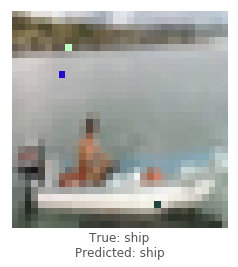

pure_cnn - image 6800 - 100 / 100


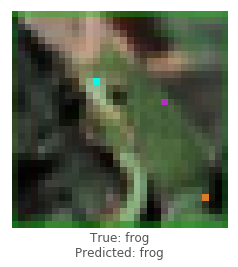

net_in_net - image 9316 - 1 / 100


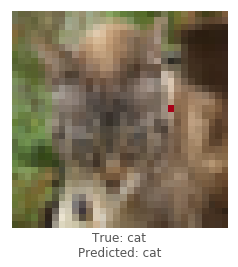

net_in_net - image 8516 - 2 / 100


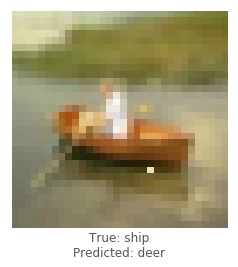

net_in_net - image 5254 - 3 / 100


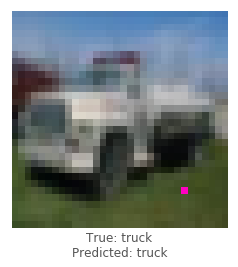

net_in_net - image 2654 - 4 / 100


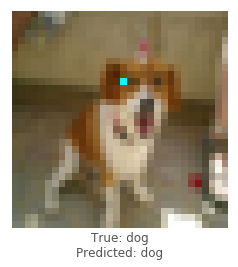

net_in_net - image 9708 - 5 / 100


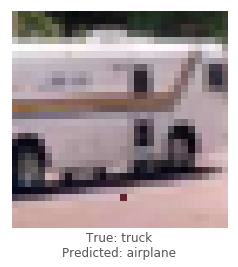

net_in_net - image 7286 - 6 / 100


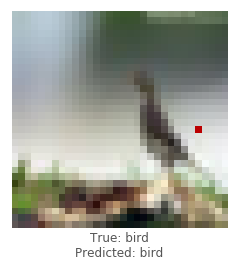

net_in_net - image 999 - 7 / 100


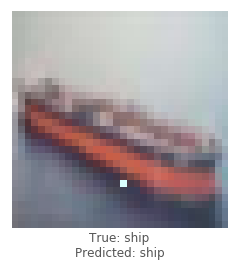

net_in_net - image 5480 - 8 / 100


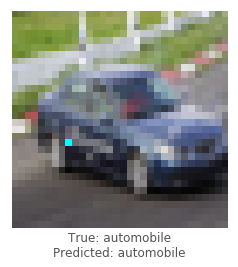

net_in_net - image 3158 - 9 / 100


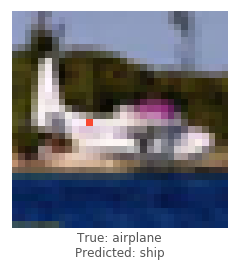

net_in_net - image 6740 - 10 / 100


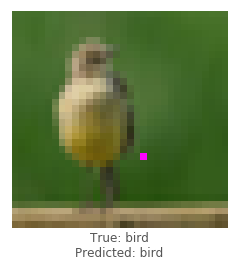

net_in_net - image 9197 - 11 / 100


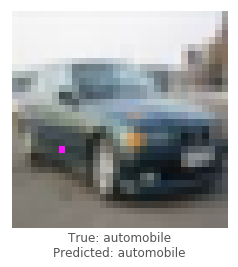

net_in_net - image 9093 - 12 / 100


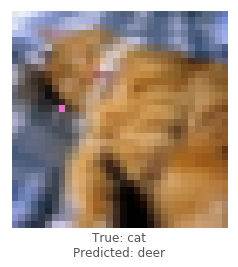

net_in_net - image 1105 - 13 / 100


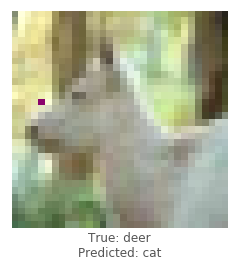

net_in_net - image 3703 - 14 / 100


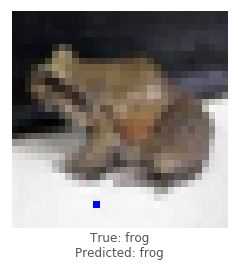

net_in_net - image 3908 - 15 / 100


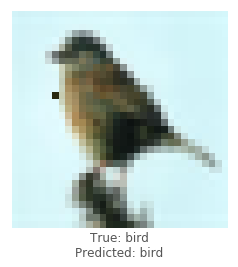

net_in_net - image 7409 - 16 / 100


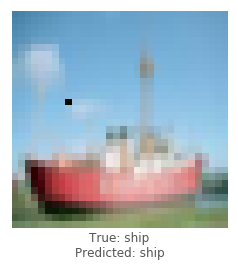

net_in_net - image 6193 - 17 / 100


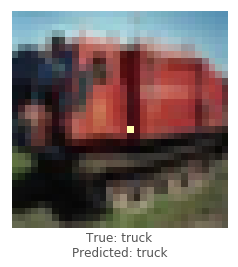

net_in_net - image 874 - 18 / 100


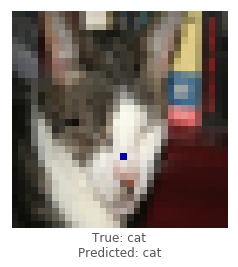

net_in_net - image 5982 - 19 / 100


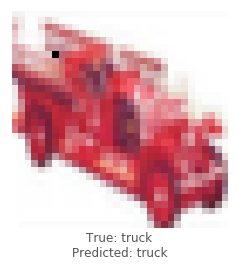

net_in_net - image 861 - 20 / 100


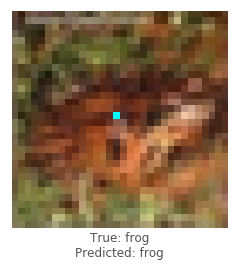

net_in_net - image 6795 - 21 / 100


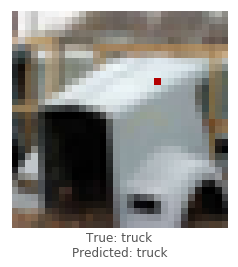

net_in_net - image 5657 - 22 / 100


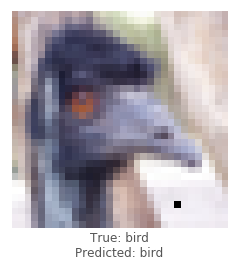

net_in_net - image 4088 - 23 / 100


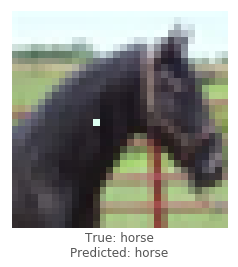

net_in_net - image 2236 - 24 / 100


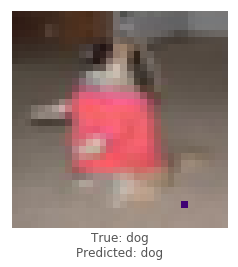

net_in_net - image 2371 - 25 / 100


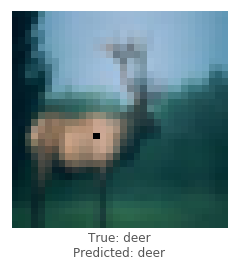

net_in_net - image 8152 - 26 / 100


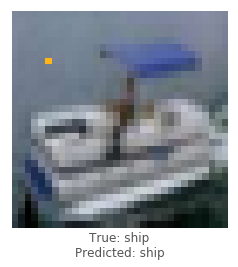

net_in_net - image 3473 - 27 / 100


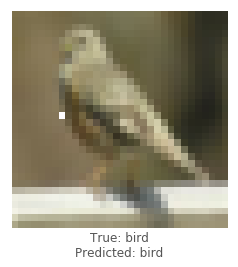

net_in_net - image 9317 - 28 / 100


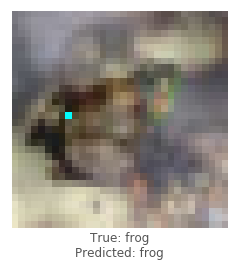

net_in_net - image 9730 - 29 / 100


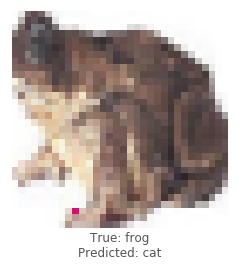

net_in_net - image 202 - 30 / 100


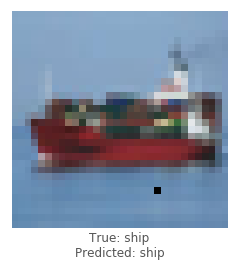

net_in_net - image 4228 - 31 / 100


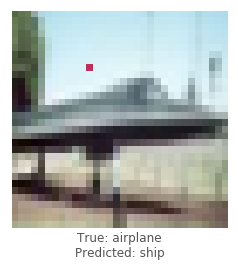

net_in_net - image 9432 - 32 / 100


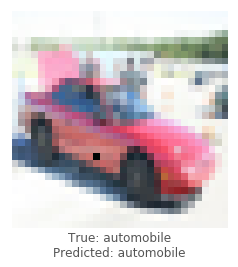

net_in_net - image 7303 - 33 / 100


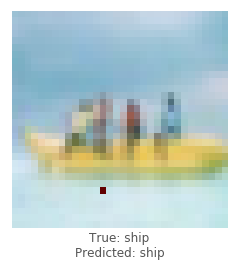

net_in_net - image 6617 - 34 / 100


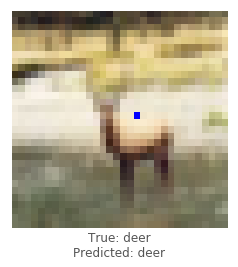

net_in_net - image 5421 - 35 / 100


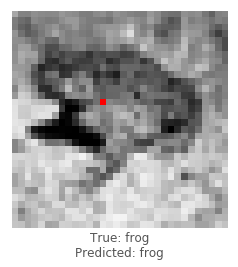

net_in_net - image 427 - 36 / 100


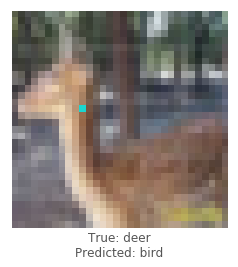

net_in_net - image 9113 - 37 / 100


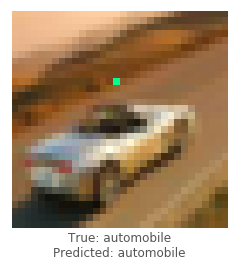

net_in_net - image 5221 - 38 / 100


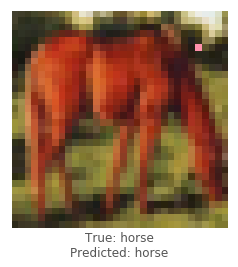

net_in_net - image 4955 - 39 / 100


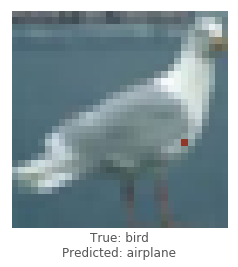

net_in_net - image 5204 - 40 / 100


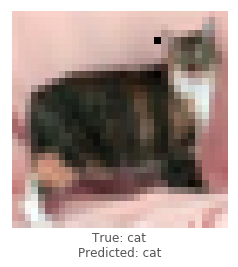

net_in_net - image 9903 - 41 / 100


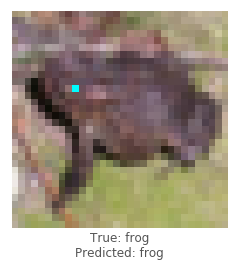

net_in_net - image 5071 - 42 / 100


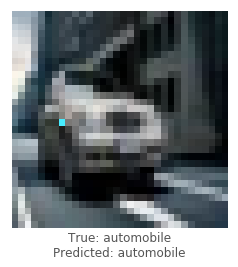

net_in_net - image 2573 - 43 / 100


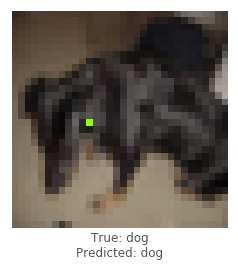

net_in_net - image 3748 - 44 / 100


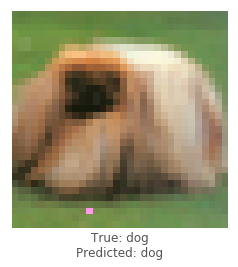

net_in_net - image 9797 - 45 / 100


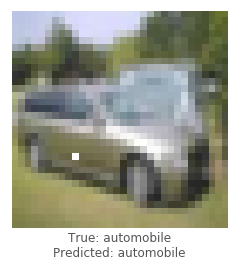

net_in_net - image 256 - 46 / 100


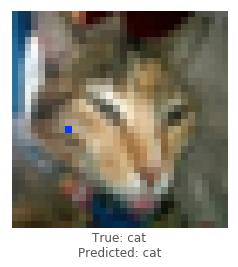

net_in_net - image 3554 - 47 / 100


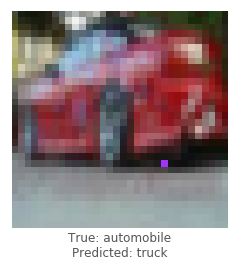

net_in_net - image 419 - 48 / 100


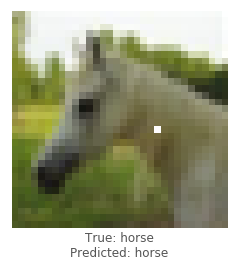

net_in_net - image 4322 - 49 / 100


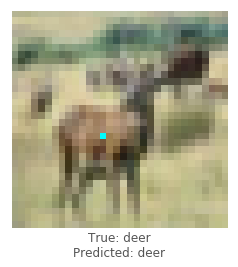

net_in_net - image 8797 - 50 / 100


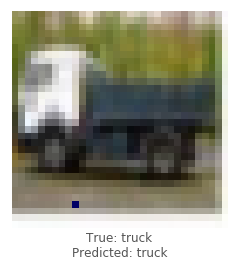

net_in_net - image 43 - 51 / 100


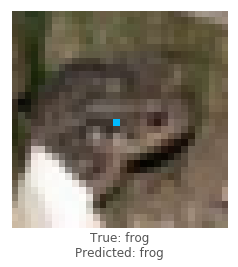

net_in_net - image 9613 - 52 / 100


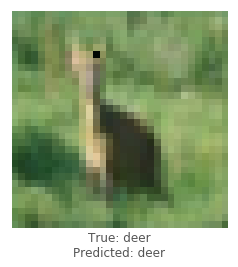

net_in_net - image 5625 - 53 / 100


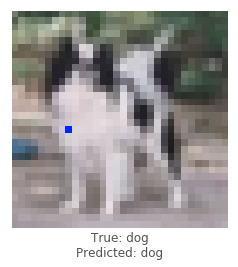

net_in_net - image 4123 - 54 / 100


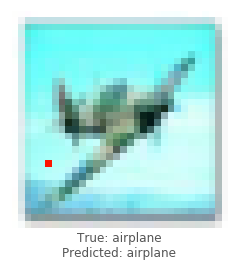

net_in_net - image 2198 - 55 / 100


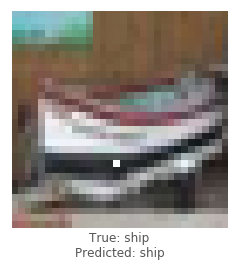

net_in_net - image 1742 - 56 / 100


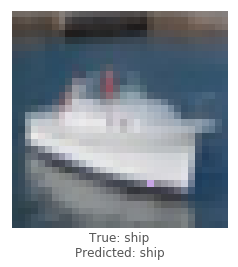

net_in_net - image 1439 - 57 / 100


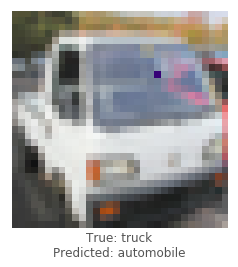

net_in_net - image 572 - 58 / 100


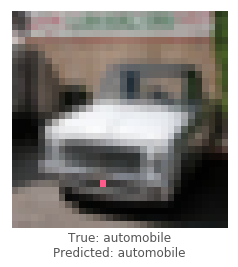

net_in_net - image 7686 - 59 / 100


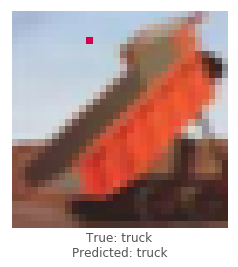

net_in_net - image 9376 - 60 / 100


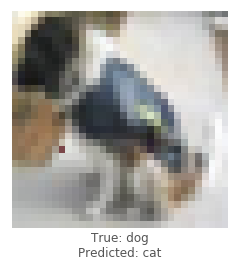

net_in_net - image 6902 - 61 / 100


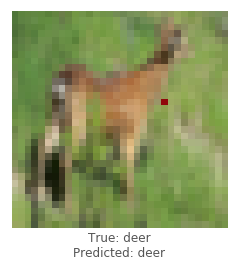

net_in_net - image 7093 - 62 / 100


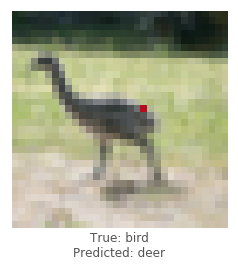

net_in_net - image 319 - 63 / 100


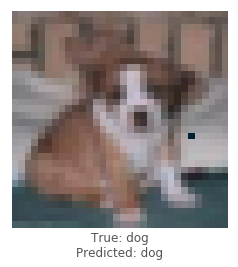

net_in_net - image 480 - 64 / 100


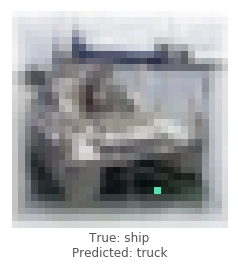

net_in_net - image 3207 - 65 / 100


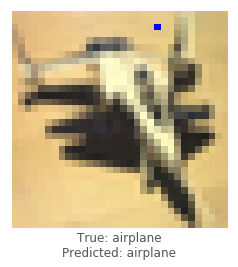

net_in_net - image 1373 - 66 / 100


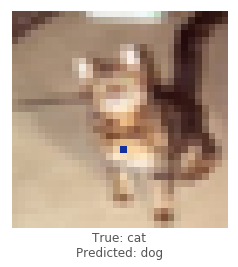

net_in_net - image 6110 - 67 / 100


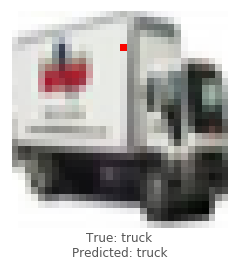

net_in_net - image 6514 - 68 / 100


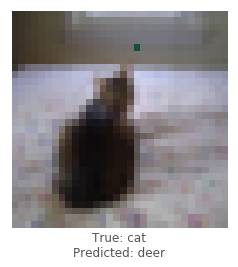

net_in_net - image 6755 - 69 / 100


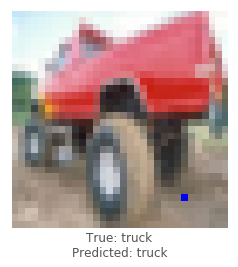

net_in_net - image 150 - 70 / 100


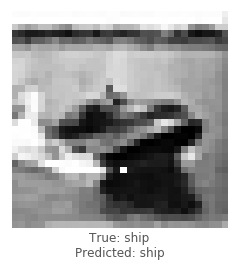

net_in_net - image 3939 - 71 / 100


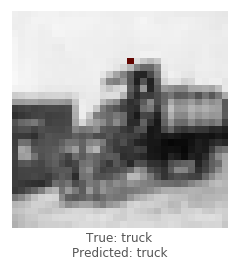

net_in_net - image 8962 - 72 / 100


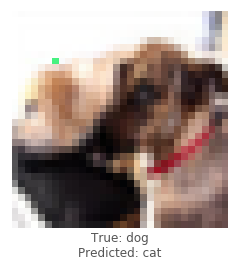

net_in_net - image 6478 - 73 / 100


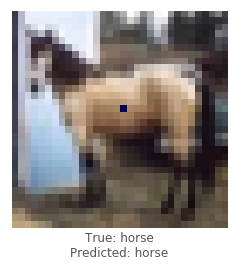

net_in_net - image 8453 - 74 / 100


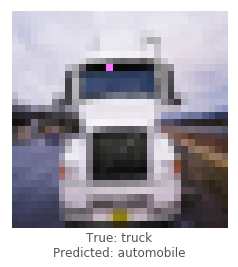

net_in_net - image 9024 - 75 / 100


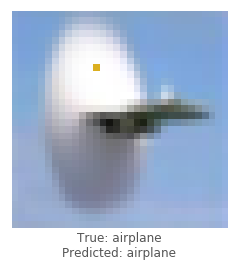

net_in_net - image 708 - 76 / 100


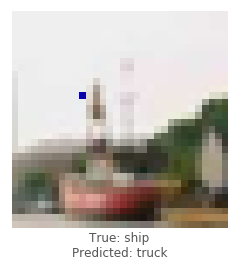

net_in_net - image 7065 - 77 / 100


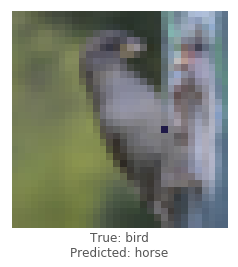

net_in_net - image 2591 - 78 / 100


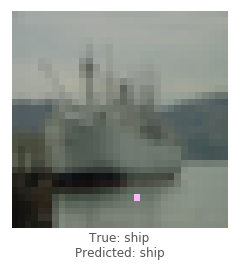

net_in_net - image 8511 - 79 / 100


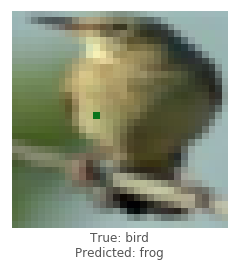

net_in_net - image 7187 - 80 / 100


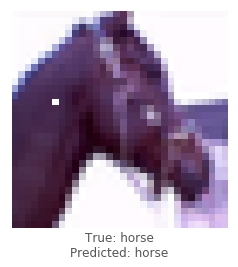

net_in_net - image 9359 - 81 / 100


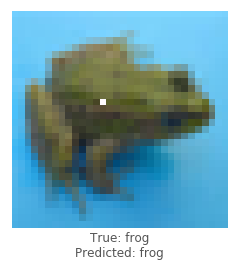

net_in_net - image 9289 - 82 / 100


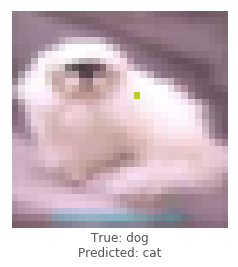

net_in_net - image 0 - 83 / 100


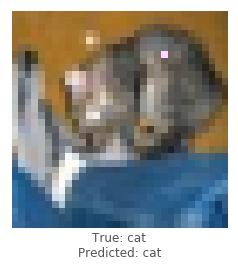

net_in_net - image 4318 - 84 / 100


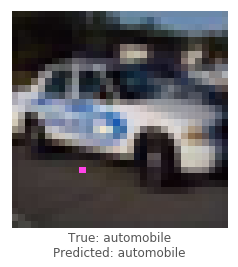

net_in_net - image 391 - 85 / 100


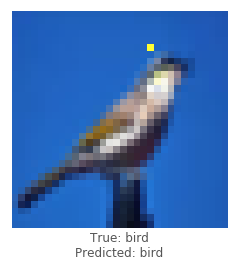

net_in_net - image 6775 - 86 / 100


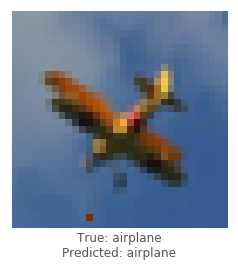

net_in_net - image 8104 - 87 / 100


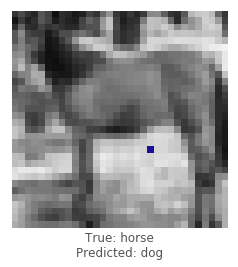

net_in_net - image 4108 - 88 / 100


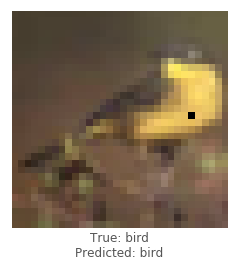

net_in_net - image 6806 - 89 / 100


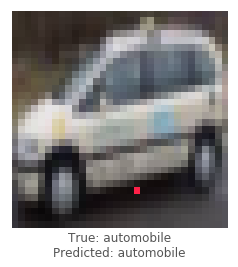

net_in_net - image 3328 - 90 / 100


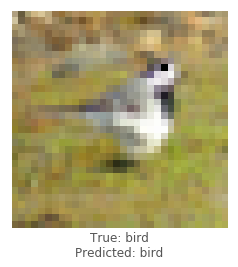

net_in_net - image 5827 - 91 / 100


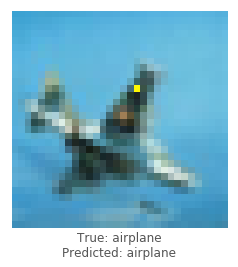

net_in_net - image 7380 - 92 / 100


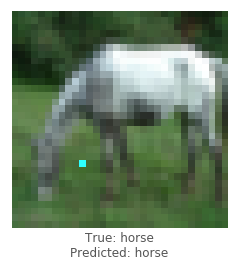

net_in_net - image 746 - 93 / 100


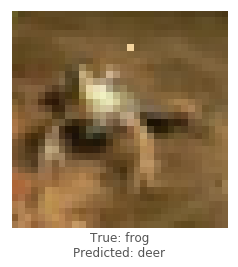

net_in_net - image 7167 - 94 / 100


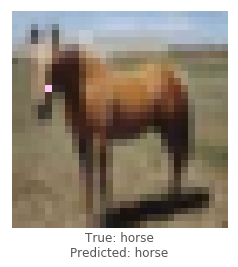

net_in_net - image 3245 - 95 / 100


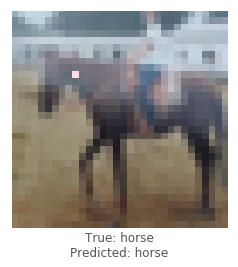

net_in_net - image 3409 - 96 / 100


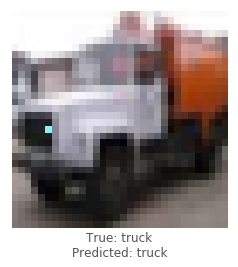

net_in_net - image 7070 - 97 / 100


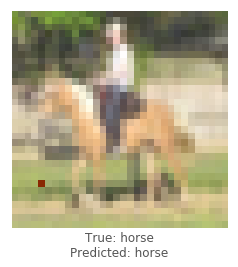

net_in_net - image 4852 - 98 / 100


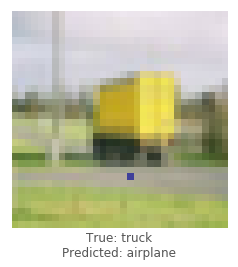

net_in_net - image 3701 - 99 / 100


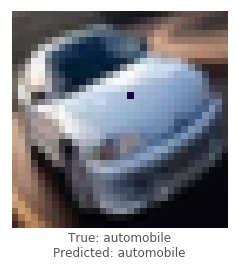

net_in_net - image 1306 - 100 / 100


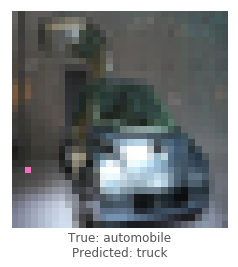

net_in_net - image 9316 - 1 / 100


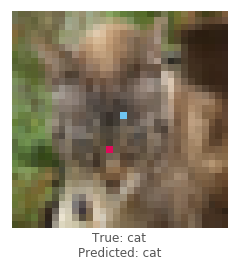

net_in_net - image 8516 - 2 / 100


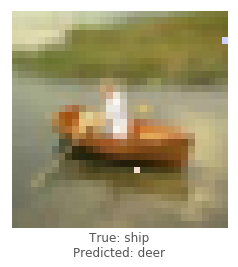

net_in_net - image 5254 - 3 / 100


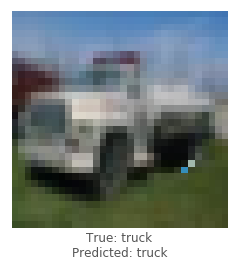

net_in_net - image 2654 - 4 / 100


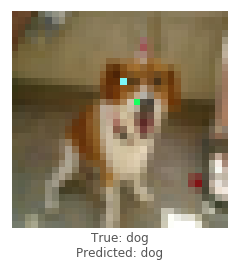

net_in_net - image 9708 - 5 / 100


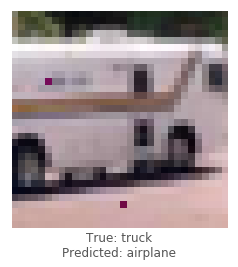

net_in_net - image 7286 - 6 / 100


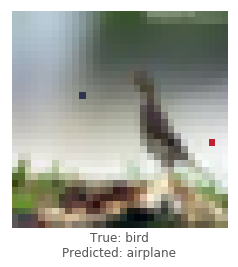

net_in_net - image 999 - 7 / 100


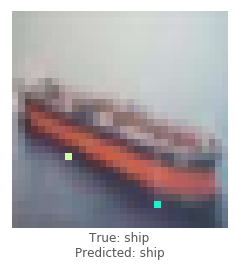

net_in_net - image 5480 - 8 / 100


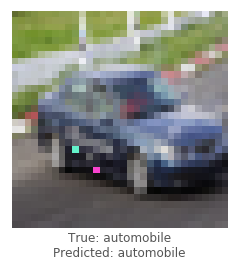

net_in_net - image 3158 - 9 / 100


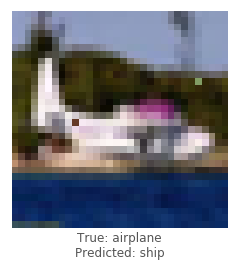

net_in_net - image 6740 - 10 / 100


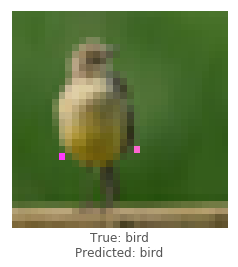

net_in_net - image 9197 - 11 / 100


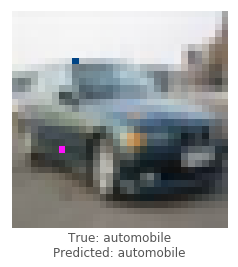

net_in_net - image 9093 - 12 / 100


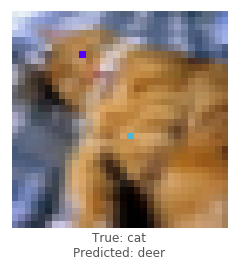

net_in_net - image 1105 - 13 / 100


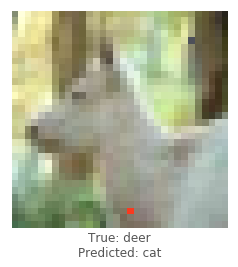

net_in_net - image 3703 - 14 / 100


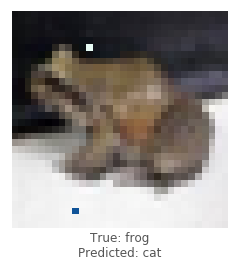

net_in_net - image 3908 - 15 / 100


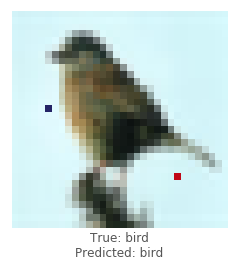

net_in_net - image 7409 - 16 / 100


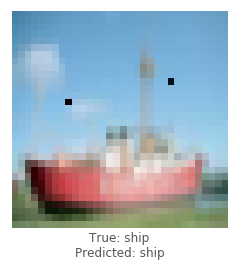

net_in_net - image 6193 - 17 / 100


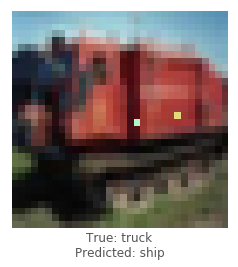

net_in_net - image 874 - 18 / 100


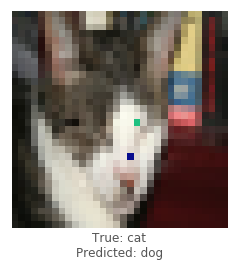

net_in_net - image 5982 - 19 / 100


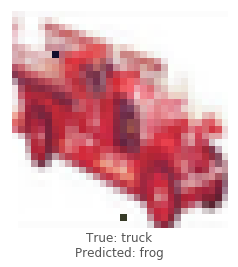

net_in_net - image 861 - 20 / 100


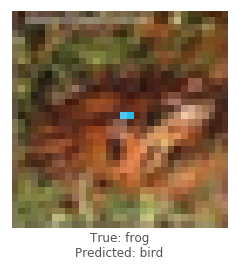

net_in_net - image 6795 - 21 / 100


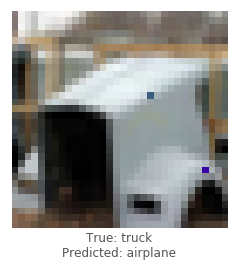

net_in_net - image 5657 - 22 / 100


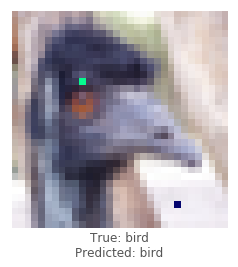

net_in_net - image 4088 - 23 / 100


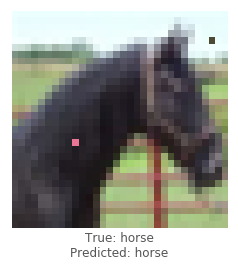

net_in_net - image 2236 - 24 / 100


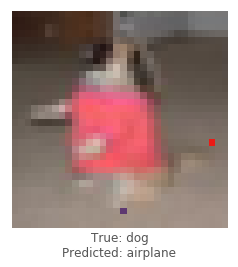

net_in_net - image 2371 - 25 / 100


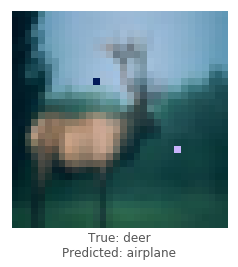

net_in_net - image 8152 - 26 / 100


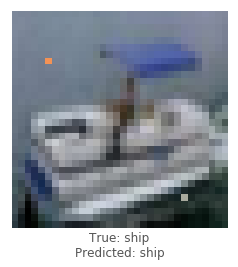

net_in_net - image 3473 - 27 / 100


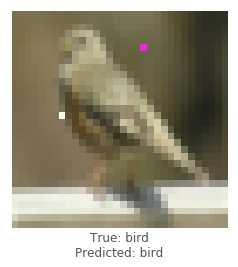

net_in_net - image 9317 - 28 / 100


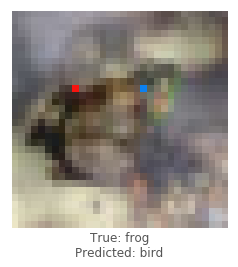

net_in_net - image 9730 - 29 / 100


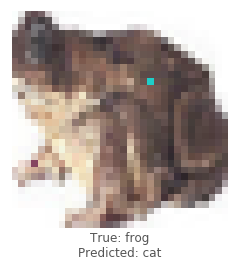

net_in_net - image 202 - 30 / 100


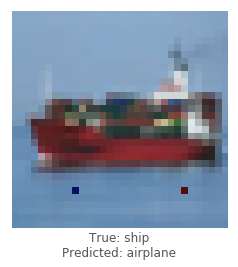

net_in_net - image 4228 - 31 / 100


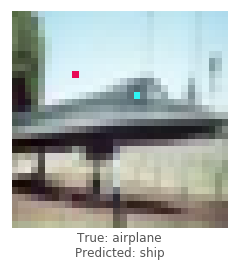

net_in_net - image 9432 - 32 / 100


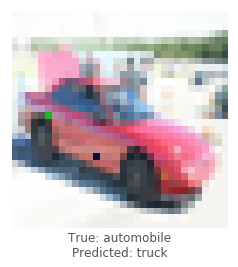

net_in_net - image 7303 - 33 / 100


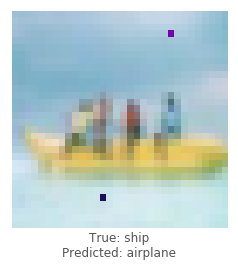

net_in_net - image 6617 - 34 / 100


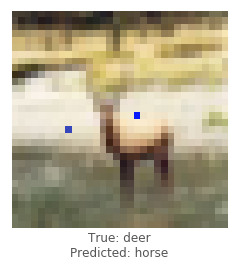

net_in_net - image 5421 - 35 / 100


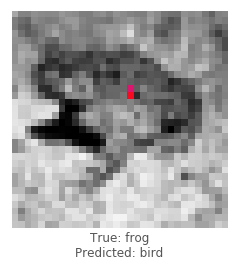

net_in_net - image 427 - 36 / 100


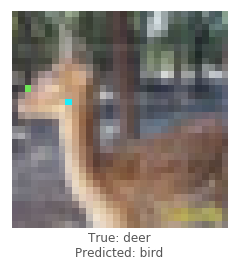

net_in_net - image 9113 - 37 / 100


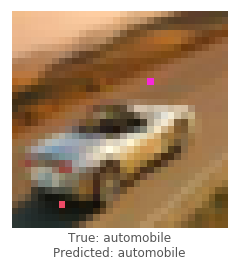

net_in_net - image 5221 - 38 / 100


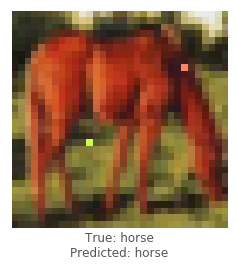

net_in_net - image 4955 - 39 / 100


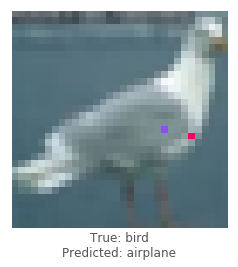

net_in_net - image 5204 - 40 / 100


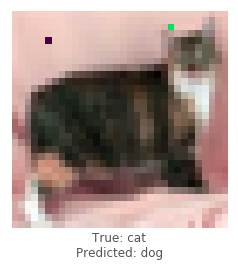

net_in_net - image 9903 - 41 / 100


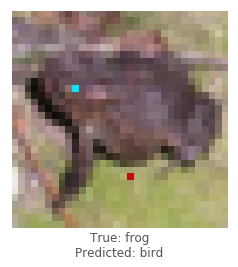

net_in_net - image 5071 - 42 / 100


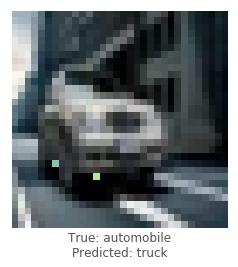

net_in_net - image 2573 - 43 / 100


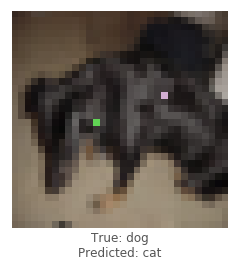

net_in_net - image 3748 - 44 / 100


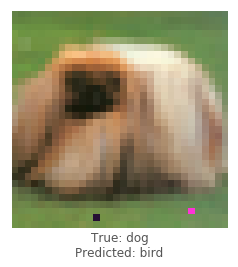

net_in_net - image 9797 - 45 / 100


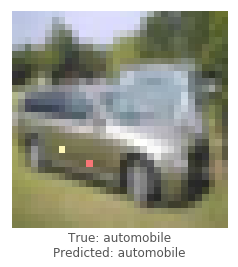

net_in_net - image 256 - 46 / 100


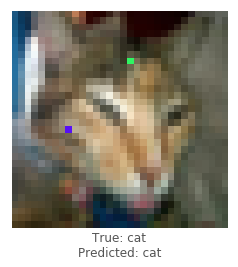

net_in_net - image 3554 - 47 / 100


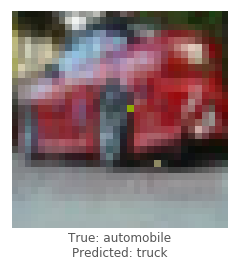

net_in_net - image 419 - 48 / 100


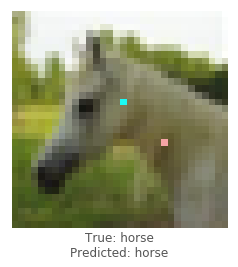

net_in_net - image 4322 - 49 / 100


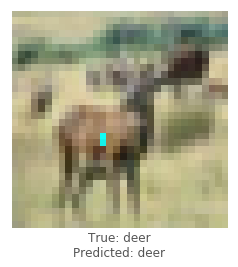

net_in_net - image 8797 - 50 / 100


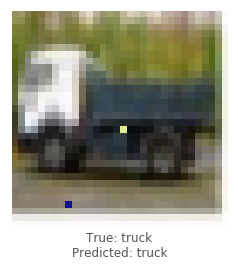

net_in_net - image 43 - 51 / 100


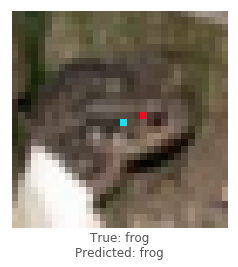

net_in_net - image 9613 - 52 / 100


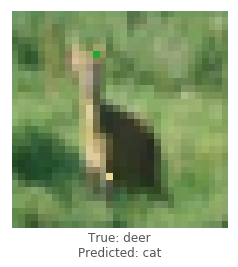

net_in_net - image 5625 - 53 / 100


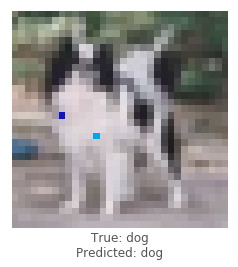

net_in_net - image 4123 - 54 / 100


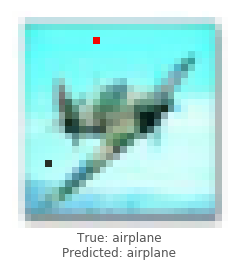

net_in_net - image 2198 - 55 / 100


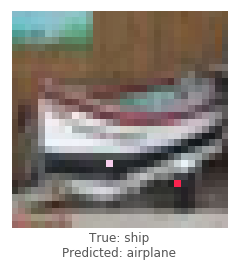

net_in_net - image 1742 - 56 / 100


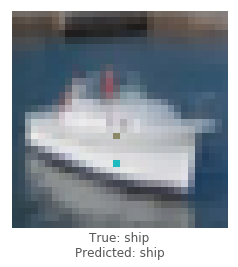

net_in_net - image 1439 - 57 / 100


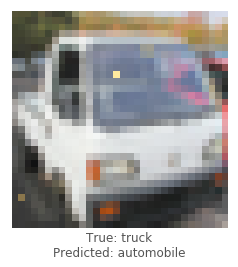

net_in_net - image 572 - 58 / 100


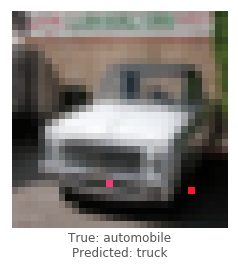

net_in_net - image 7686 - 59 / 100


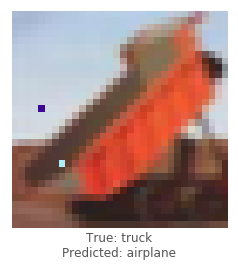

net_in_net - image 9376 - 60 / 100


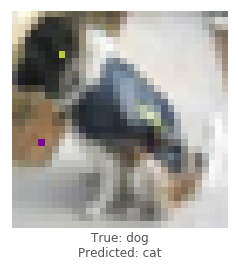

net_in_net - image 6902 - 61 / 100


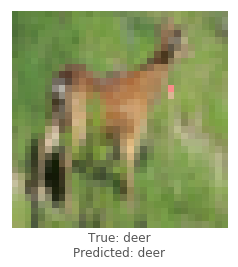

net_in_net - image 7093 - 62 / 100


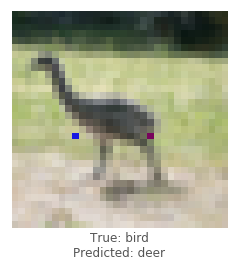

net_in_net - image 319 - 63 / 100


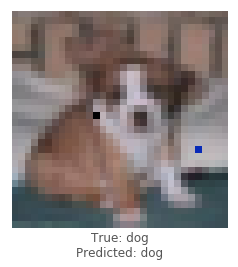

net_in_net - image 480 - 64 / 100


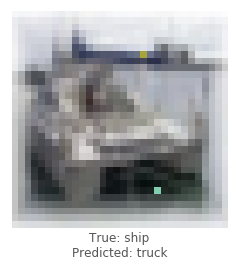

net_in_net - image 3207 - 65 / 100


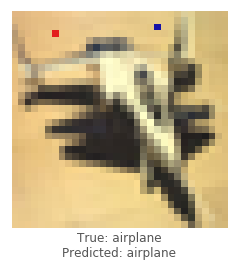

net_in_net - image 1373 - 66 / 100


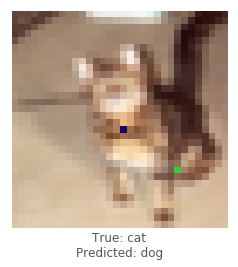

net_in_net - image 6110 - 67 / 100


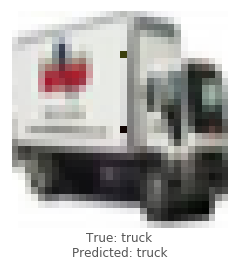

net_in_net - image 6514 - 68 / 100


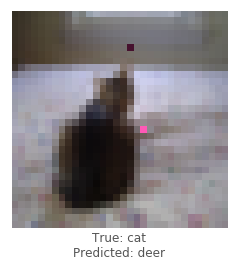

net_in_net - image 6755 - 69 / 100


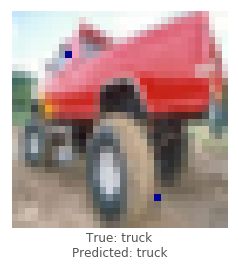

net_in_net - image 150 - 70 / 100


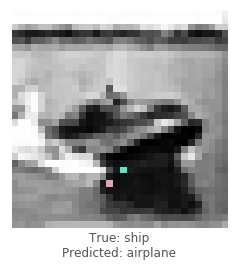

net_in_net - image 3939 - 71 / 100


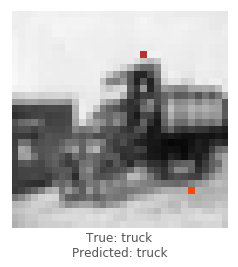

net_in_net - image 8962 - 72 / 100


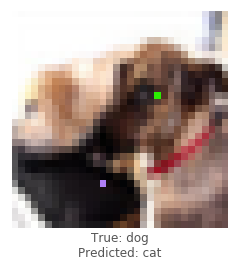

net_in_net - image 6478 - 73 / 100


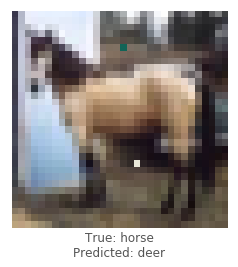

net_in_net - image 8453 - 74 / 100


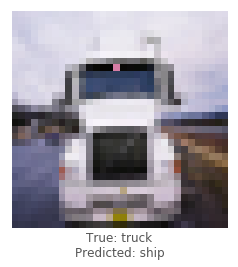

net_in_net - image 9024 - 75 / 100


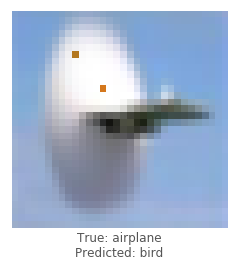

net_in_net - image 708 - 76 / 100


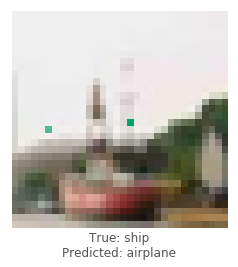

net_in_net - image 7065 - 77 / 100


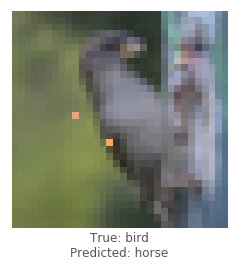

net_in_net - image 2591 - 78 / 100


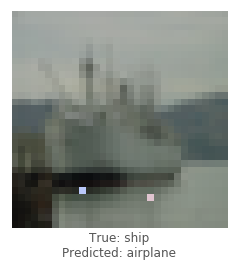

net_in_net - image 8511 - 79 / 100


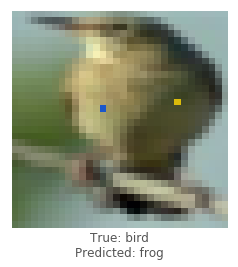

net_in_net - image 7187 - 80 / 100


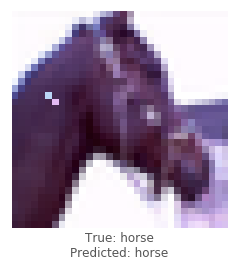

net_in_net - image 9359 - 81 / 100


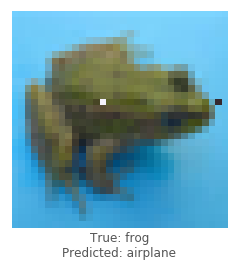

net_in_net - image 9289 - 82 / 100


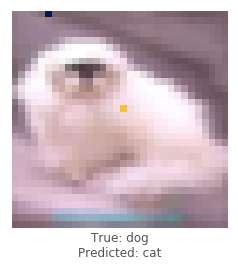

net_in_net - image 0 - 83 / 100


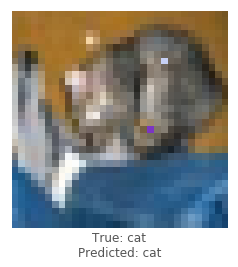

net_in_net - image 4318 - 84 / 100


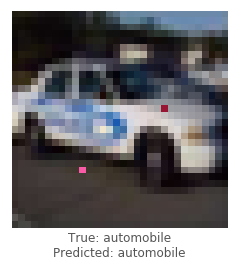

net_in_net - image 391 - 85 / 100


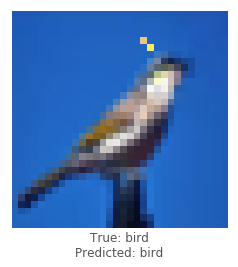

net_in_net - image 6775 - 86 / 100


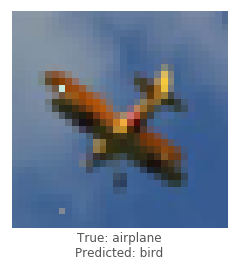

net_in_net - image 8104 - 87 / 100


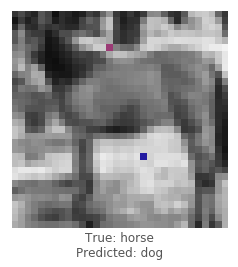

net_in_net - image 4108 - 88 / 100


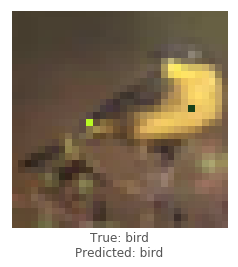

net_in_net - image 6806 - 89 / 100


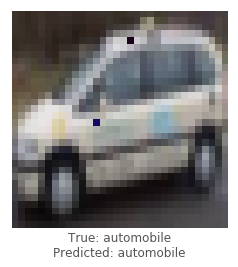

net_in_net - image 3328 - 90 / 100


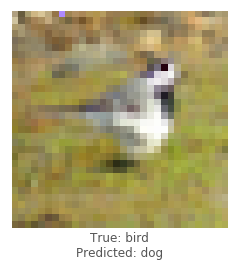

net_in_net - image 5827 - 91 / 100


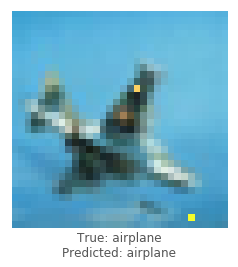

net_in_net - image 7380 - 92 / 100


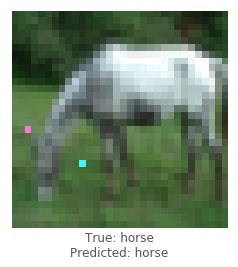

net_in_net - image 746 - 93 / 100


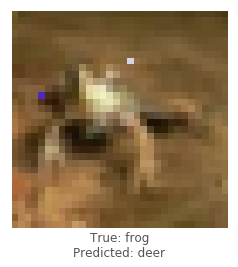

net_in_net - image 7167 - 94 / 100


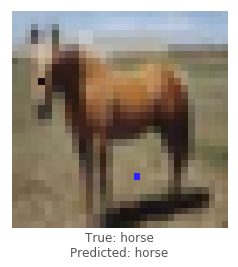

net_in_net - image 3245 - 95 / 100


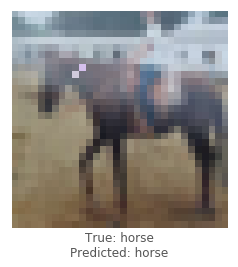

net_in_net - image 3409 - 96 / 100


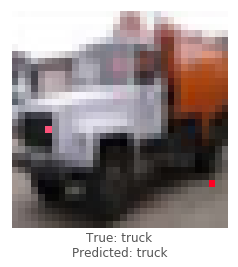

net_in_net - image 7070 - 97 / 100


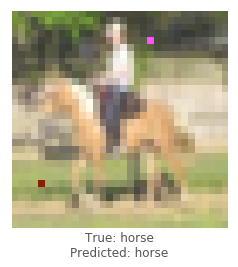

net_in_net - image 4852 - 98 / 100


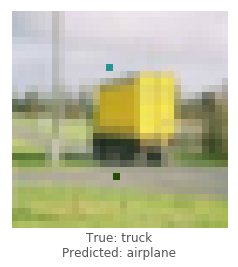

net_in_net - image 3701 - 99 / 100


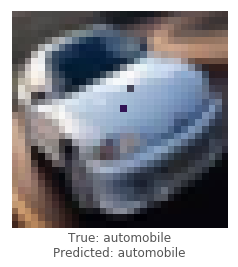

net_in_net - image 1306 - 100 / 100


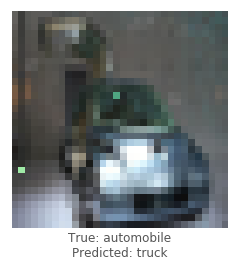

net_in_net - image 9316 - 1 / 100


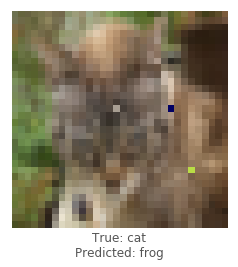

net_in_net - image 8516 - 2 / 100


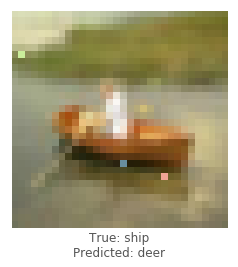

net_in_net - image 5254 - 3 / 100


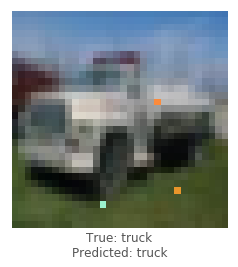

net_in_net - image 2654 - 4 / 100


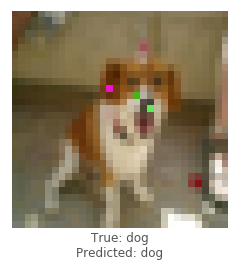

net_in_net - image 9708 - 5 / 100


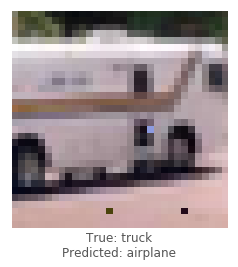

net_in_net - image 7286 - 6 / 100


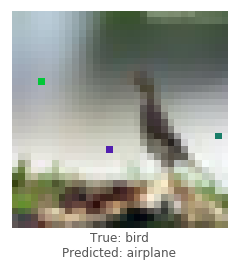

net_in_net - image 999 - 7 / 100


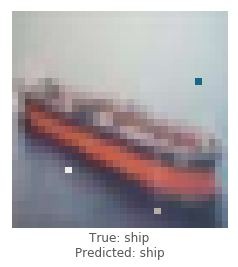

net_in_net - image 5480 - 8 / 100


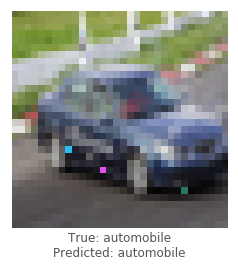

net_in_net - image 3158 - 9 / 100


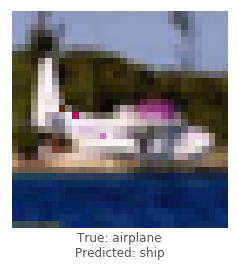

net_in_net - image 6740 - 10 / 100


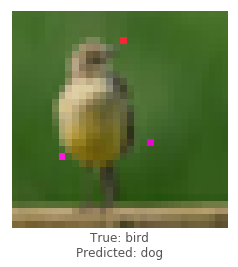

net_in_net - image 9197 - 11 / 100


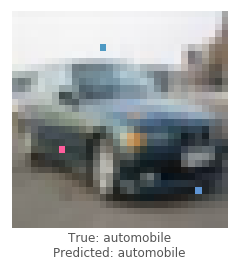

net_in_net - image 9093 - 12 / 100


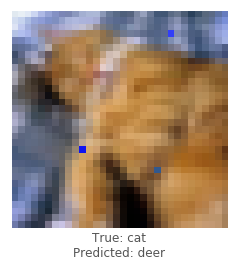

net_in_net - image 1105 - 13 / 100


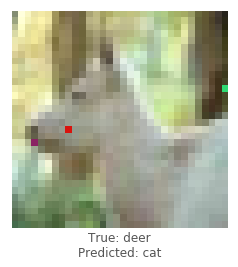

net_in_net - image 3703 - 14 / 100


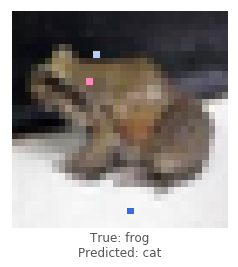

net_in_net - image 3908 - 15 / 100


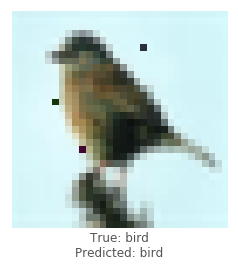

net_in_net - image 7409 - 16 / 100


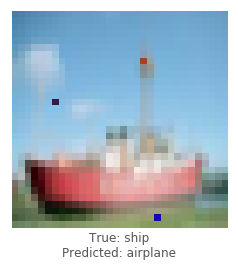

net_in_net - image 6193 - 17 / 100


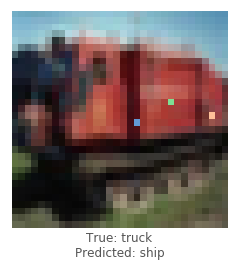

net_in_net - image 874 - 18 / 100


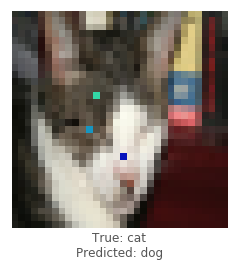

net_in_net - image 5982 - 19 / 100


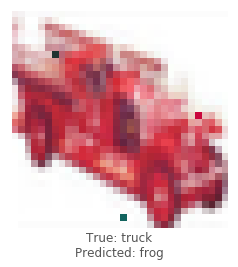

net_in_net - image 861 - 20 / 100


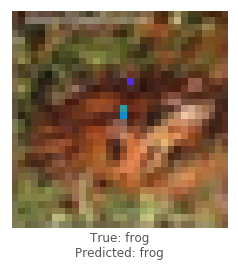

net_in_net - image 6795 - 21 / 100


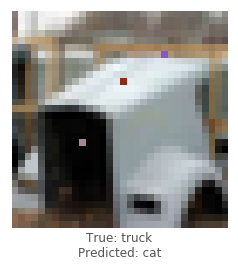

net_in_net - image 5657 - 22 / 100


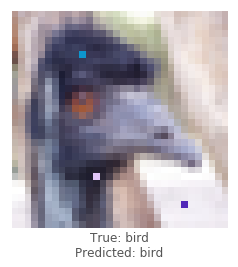

net_in_net - image 4088 - 23 / 100


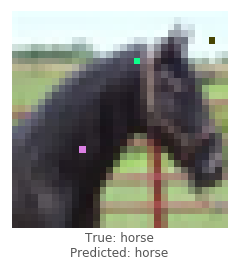

net_in_net - image 2236 - 24 / 100


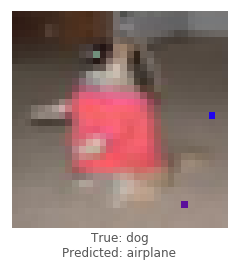

net_in_net - image 2371 - 25 / 100


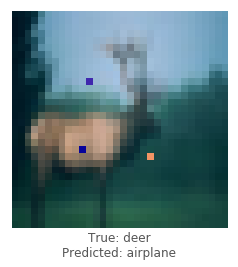

net_in_net - image 8152 - 26 / 100


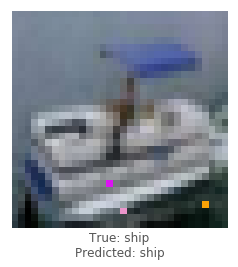

net_in_net - image 3473 - 27 / 100


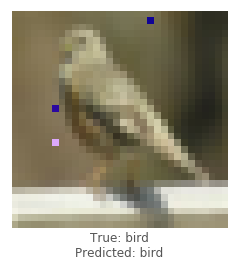

net_in_net - image 9317 - 28 / 100


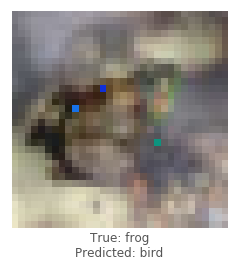

net_in_net - image 9730 - 29 / 100


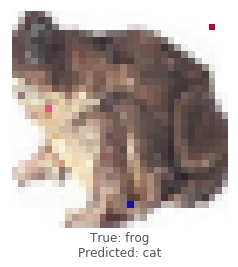

net_in_net - image 202 - 30 / 100


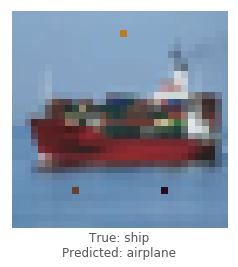

net_in_net - image 4228 - 31 / 100


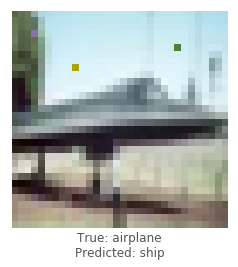

net_in_net - image 9432 - 32 / 100


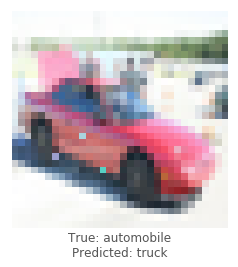

net_in_net - image 7303 - 33 / 100


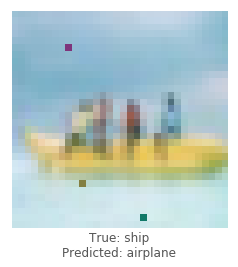

net_in_net - image 6617 - 34 / 100


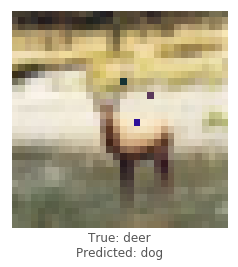

net_in_net - image 5421 - 35 / 100


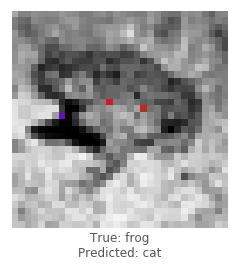

net_in_net - image 427 - 36 / 100


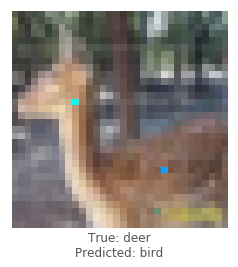

net_in_net - image 9113 - 37 / 100


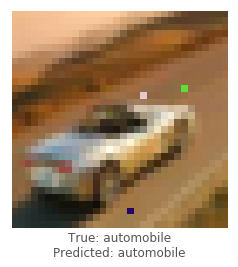

net_in_net - image 5221 - 38 / 100


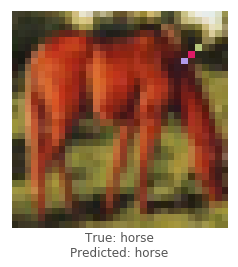

net_in_net - image 4955 - 39 / 100


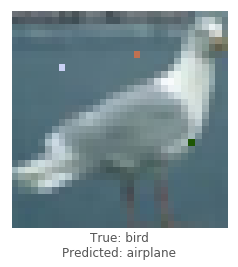

net_in_net - image 5204 - 40 / 100


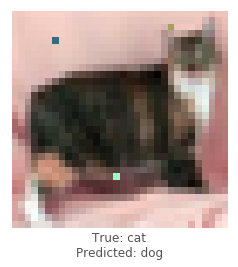

net_in_net - image 9903 - 41 / 100


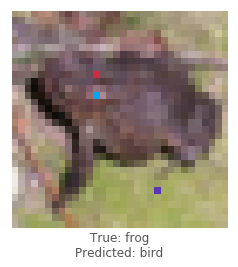

net_in_net - image 5071 - 42 / 100


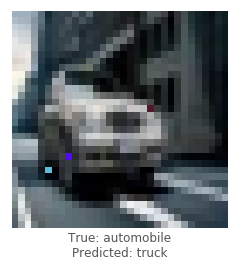

net_in_net - image 2573 - 43 / 100


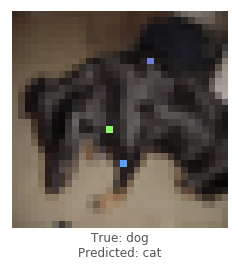

net_in_net - image 3748 - 44 / 100


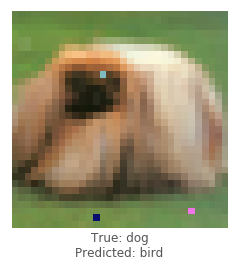

net_in_net - image 9797 - 45 / 100


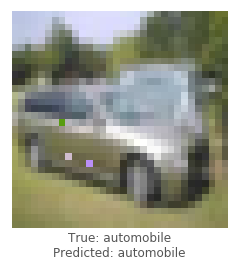

net_in_net - image 256 - 46 / 100


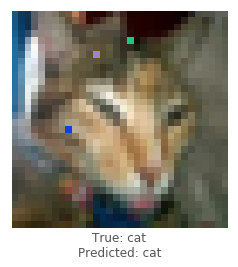

net_in_net - image 3554 - 47 / 100


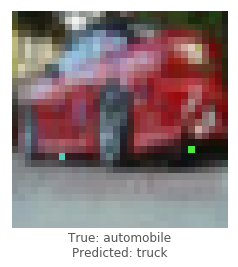

net_in_net - image 419 - 48 / 100


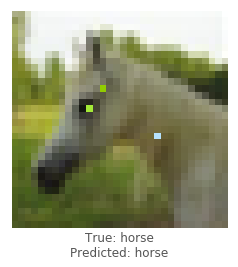

net_in_net - image 4322 - 49 / 100


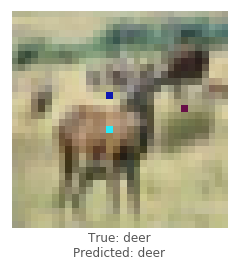

net_in_net - image 8797 - 50 / 100


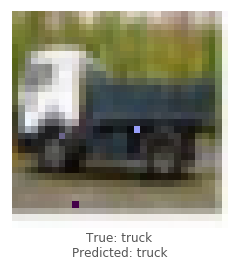

net_in_net - image 43 - 51 / 100


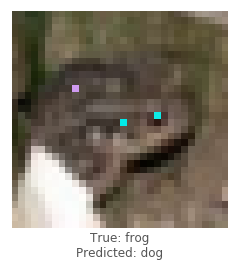

net_in_net - image 9613 - 52 / 100


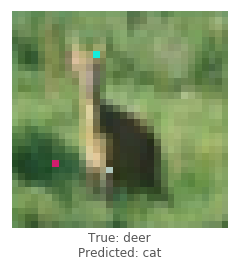

net_in_net - image 5625 - 53 / 100


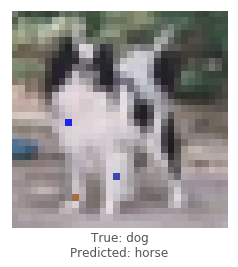

net_in_net - image 4123 - 54 / 100


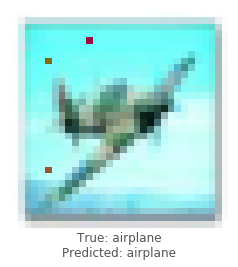

net_in_net - image 2198 - 55 / 100


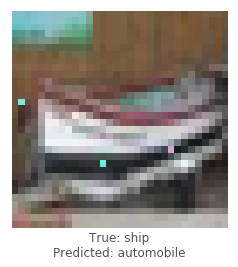

net_in_net - image 1742 - 56 / 100


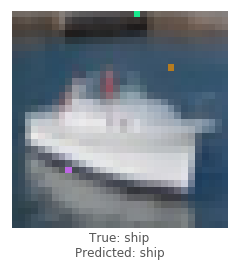

net_in_net - image 1439 - 57 / 100


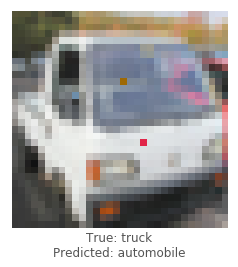

net_in_net - image 572 - 58 / 100


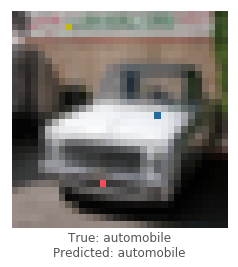

net_in_net - image 7686 - 59 / 100


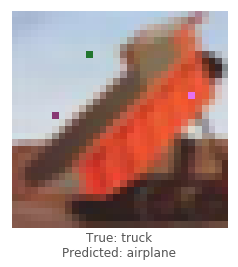

net_in_net - image 9376 - 60 / 100


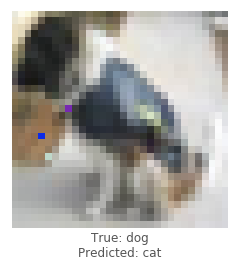

net_in_net - image 6902 - 61 / 100


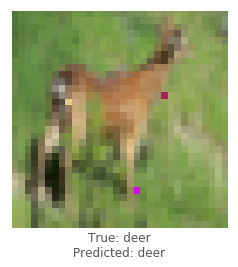

net_in_net - image 7093 - 62 / 100


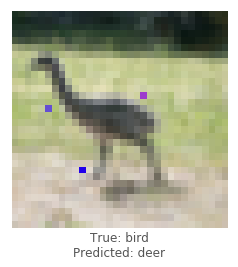

net_in_net - image 319 - 63 / 100


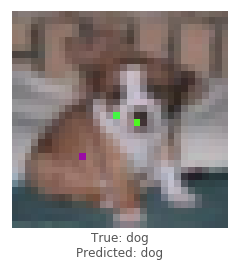

net_in_net - image 480 - 64 / 100


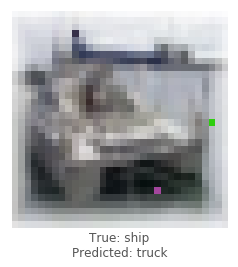

net_in_net - image 3207 - 65 / 100


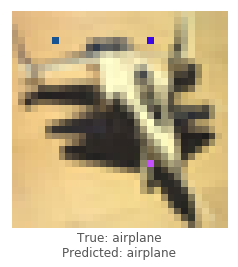

net_in_net - image 1373 - 66 / 100


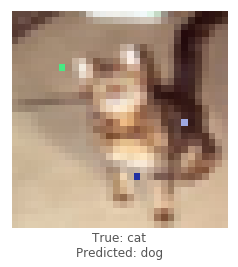

net_in_net - image 6110 - 67 / 100


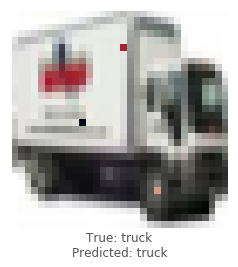

net_in_net - image 6514 - 68 / 100


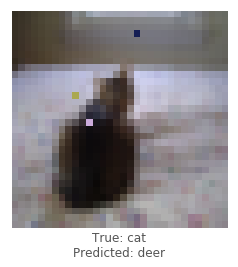

net_in_net - image 6755 - 69 / 100


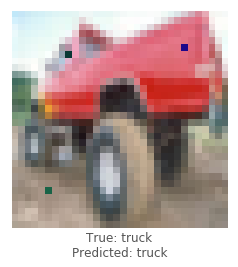

net_in_net - image 150 - 70 / 100


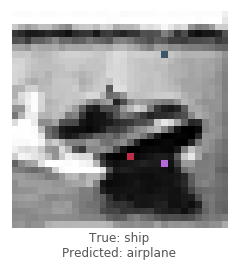

net_in_net - image 3939 - 71 / 100


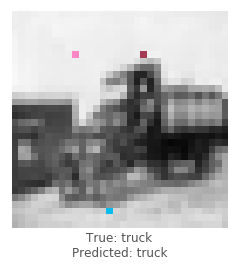

net_in_net - image 8962 - 72 / 100


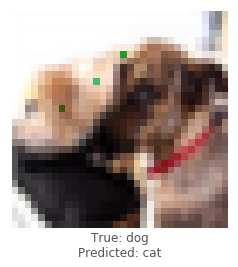

net_in_net - image 6478 - 73 / 100


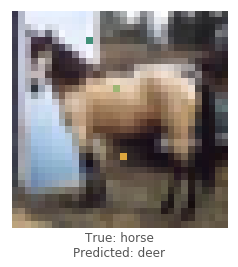

net_in_net - image 8453 - 74 / 100


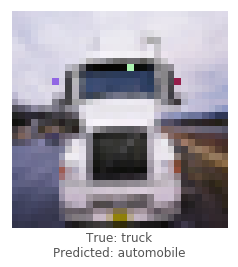

net_in_net - image 9024 - 75 / 100


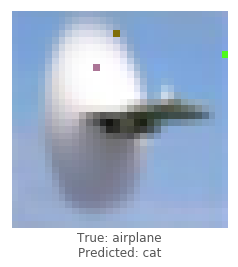

net_in_net - image 708 - 76 / 100


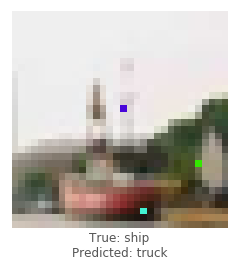

net_in_net - image 7065 - 77 / 100


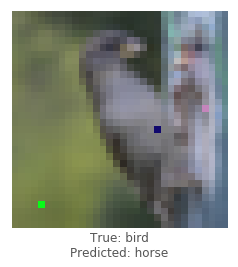

net_in_net - image 2591 - 78 / 100


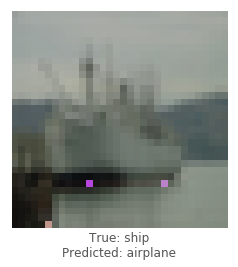

net_in_net - image 8511 - 79 / 100


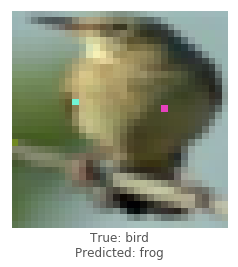

net_in_net - image 7187 - 80 / 100


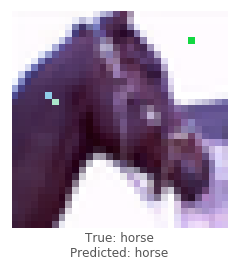

net_in_net - image 9359 - 81 / 100


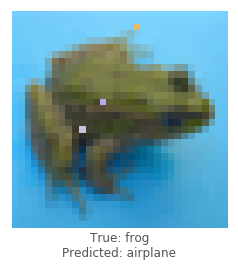

net_in_net - image 9289 - 82 / 100


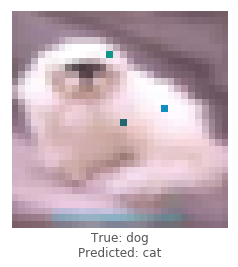

net_in_net - image 0 - 83 / 100


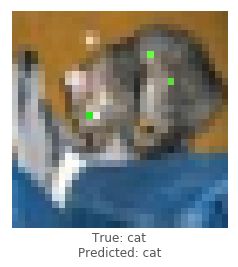

net_in_net - image 4318 - 84 / 100


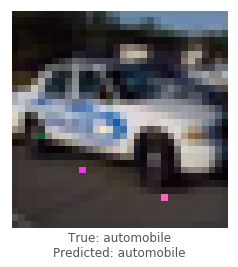

net_in_net - image 391 - 85 / 100


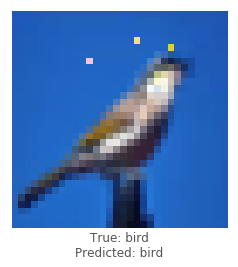

net_in_net - image 6775 - 86 / 100


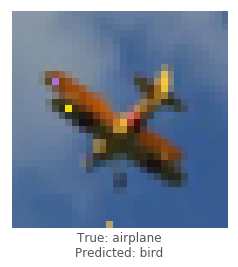

net_in_net - image 8104 - 87 / 100


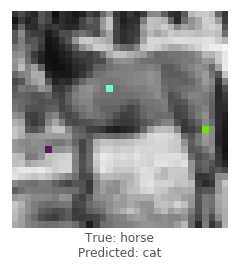

net_in_net - image 4108 - 88 / 100


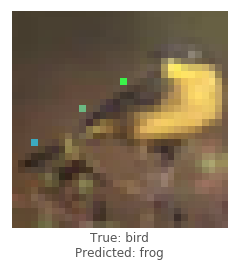

net_in_net - image 6806 - 89 / 100


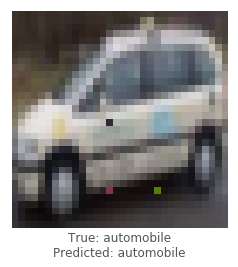

net_in_net - image 3328 - 90 / 100


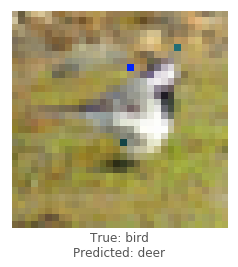

net_in_net - image 5827 - 91 / 100


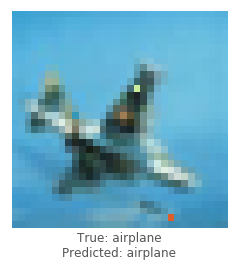

net_in_net - image 7380 - 92 / 100


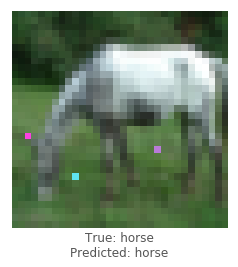

net_in_net - image 746 - 93 / 100


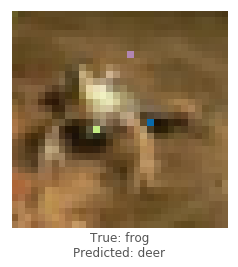

net_in_net - image 7167 - 94 / 100


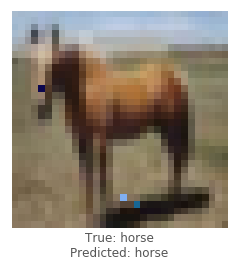

net_in_net - image 3245 - 95 / 100


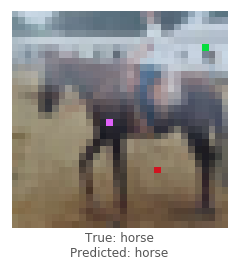

net_in_net - image 3409 - 96 / 100


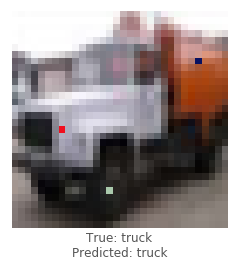

net_in_net - image 7070 - 97 / 100


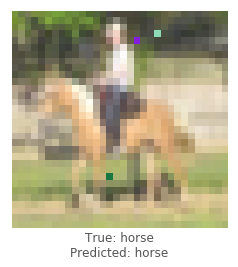

net_in_net - image 4852 - 98 / 100


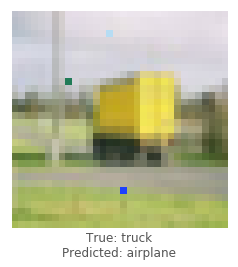

net_in_net - image 3701 - 99 / 100


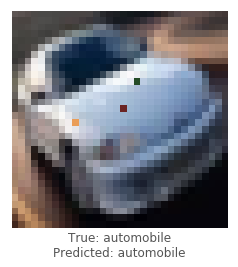

net_in_net - image 1306 - 100 / 100


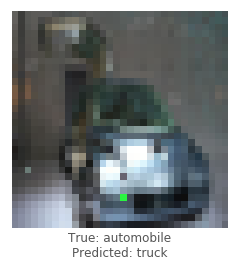

resnet - image 3558 - 1 / 100


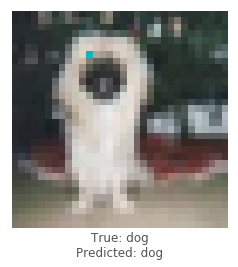

resnet - image 917 - 2 / 100


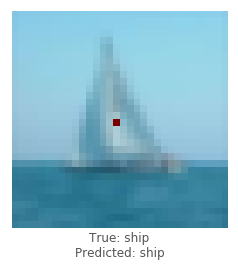

resnet - image 7731 - 3 / 100


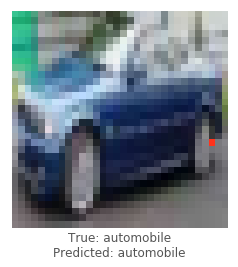

resnet - image 125 - 4 / 100


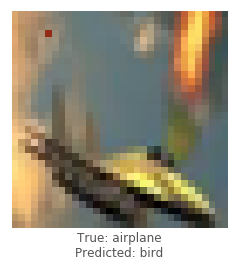

resnet - image 5423 - 5 / 100


In [ ]:
untargeted = attack_all(models, samples=100, targeted=False)

In [ ]:
targeted = attack_all(models, samples=10, pixels=[1], targeted=True)

### Attack Statistics

In [ ]:
columns = ['model', 'pixels', 'image', 'true', 'predicted', 'success', 'cdiff', 'prior_probs', 'predicted_probs', 'attack_image']
untargeted_results = pd.DataFrame(untargeted, columns=columns)
targeted_results = pd.DataFrame(targeted, columns=columns)

#### Untargeted

In [ ]:
attack_stats(untargeted_results)

#### Targeted

In [ ]:
attack_stats(targeted_results)

### Show some successful attacks

Plot 9 random misclassified images

In [ ]:
visualize_attack(untargeted_results, class_names)

In [ ]:
visualize_attack(targeted_results, class_names)

## Credits
 -  This implemenation is based off of the [original paper](https://arxiv.org/abs/1710.08864) describing the one pixel attack.
 - Base code taken from https://github.com/09rohanchopra/cifar10
 - https://arxiv.org/pdf/1412.6806.pdf
 - https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py
 - https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/06_CIFAR-10.ipynb
 - http://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/
 - https://parneetk.github.io/blog/cnn-cifar10/
 - https://github.com/dnlcrl/deep-residual-networks-pyfunt/blob/master/docs/CIFAR-10%20Experiments.ipynb